In [40]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

In [47]:
NX = 201
NY = 201
NL = 8

if NL == 8:
    idxs_dir = [0, 4,  1,  5, 2,  6,  3,  7]
    cxs      = [1, 0, -1,  0, 1, -1, -1,  1]
    cys      = [0, 1,  0, -1, 1,  1, -1, -1]
elif NL == 16:
    idxs_dir = [0, 4,  1,  5, 2,  6,  3,  7, 8, 9, 10, 11, 12, 13, 14, 15]
    # cxs      = [1, 0, -1,  0, 1, -1, -1,  1, 2, 1, -1, -2, -2, -1,  1,  2]
    # cys      = [0, 1,  0, -1, 1,  1, -1, -1, 1, 2,  2,  1, -1, -2, -2, -1]
    cxs      = [3, 0, -3,  0, 2, -2, -2,  2, 3, 1, -1, -3, -3, -1,  1,  3]
    cys      = [0, 3,  0, -3, 2,  2, -2, -2, 1, 3,  3,  1, -1, -3, -3, -1]

max_c = np.max(np.abs(cxs + cys))

if False:
    for i, (cx, cy) in enumerate(zip(cxs, cys)):
        max_norm = max(np.abs(cx), np.abs(cy))
        
        norm_factor = max_c/max_norm
        assert np.floor(norm_factor) == np.ceil(norm_factor)
        norm_factor = int(norm_factor)
        
        cxs[i] *= norm_factor
        cys[i] *= norm_factor

print(list(zip(cxs, cys)))

[(1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, 1), (-1, -1), (1, -1)]


In [48]:
def stream(xi, redist_coeff=1, adjust_velocity=False):
    # xf = np.array(xi, copy=True)
    xf = np.zeros_like(xi)

    for dir_i, i_dir in enumerate(idxs_dir):
        nl = i_dir
        cy = cys[i_dir]
        cx = cxs[i_dir]

        for j in range(NY):
            for i in range(NX):
                l_src = xi[j, i, nl]

                dir_i_next = (dir_i+1) % NL
                dir_i_prev = (dir_i-1) % NL
                nl_next = idxs_dir[dir_i_next]
                nl_prev = idxs_dir[dir_i_prev]

                cx_next = cxs[nl_next]
                cy_next = cys[nl_next]
                cx_prev = cxs[nl_prev]
                cy_prev = cys[nl_prev]

                l_stream = l_src
                if adjust_velocity:
                    v = (cx**2 + cy**2)**0.5
                    l_stream = l_src * v
                    xf[j, i, nl] += l_src - l_stream

                    if l_stream != 0 or l_src != 0:
                        print(l_src, l_stream, xf[j, i, nl], v)

                # print(f"xf[{(j + cy) % NY}, {(i + cx) % NX}, {nl}] += {l_src}")
                xf[(j + cy) % NY, (i + cx) % NX, nl] += l_src

                # redistribute the value to the next adjacent lattices in the adjacent directions
                xf[(j + cy_next) % NY, (i + cx_next) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                xf[(j + cy_prev) % NY, (i + cx_prev) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

                # redistribute the value to the next lattice in the adjacent directions
                # xf[(j + cy) % NY, (i + cx) % NX, nl_next] += (1-redist_coeff)/2 * l_stream
                # xf[(j + cy) % NY, (i + cx) % NX, nl_prev] += (1-redist_coeff)/2 * l_stream

        # @TODO - this could work if I code it better :/
        # for j in range(NY):
        #     for i in range(NX):
        #         l_pt = xf[j, i, nl]

        #         dir_i_next = (dir_i+1) % NL
        #         dir_i_prev = (dir_i-1) % NL
        #         nl_next = idxs_dir[dir_i_next]
        #         nl_prev = idxs_dir[dir_i_prev]
                
        #         if l_pt == 0:
        #             xf[j, i, nl] = (xi[j, i, nl_prev] + xi[j, i, nl_next])/2

    return xf

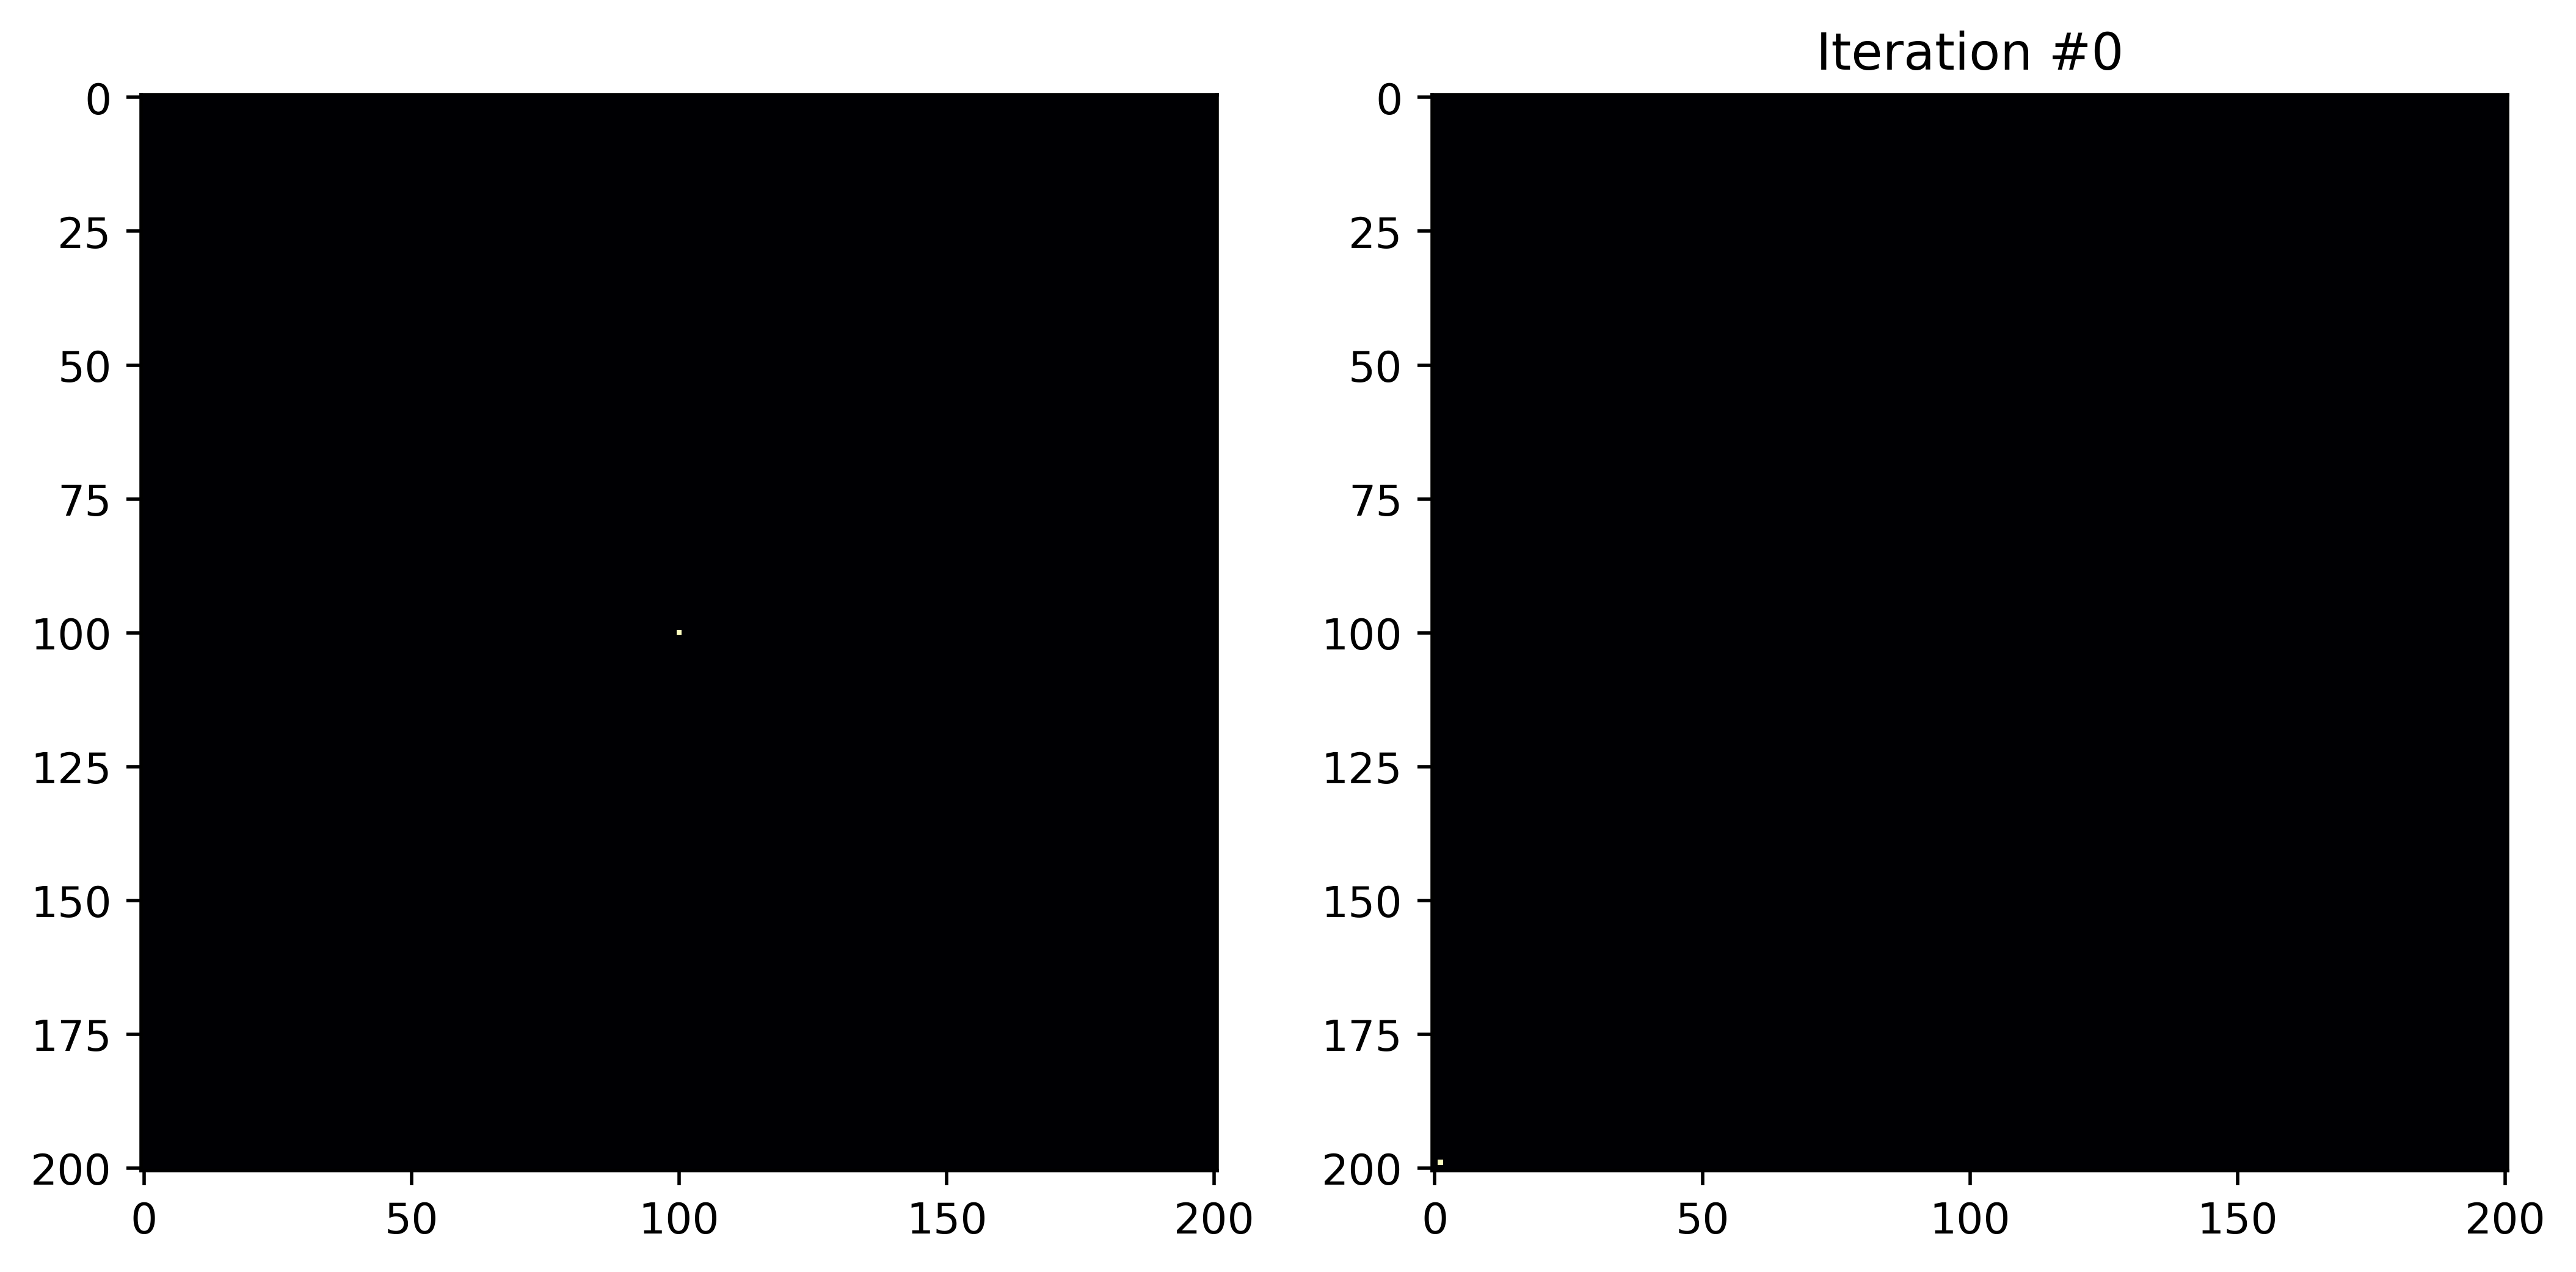

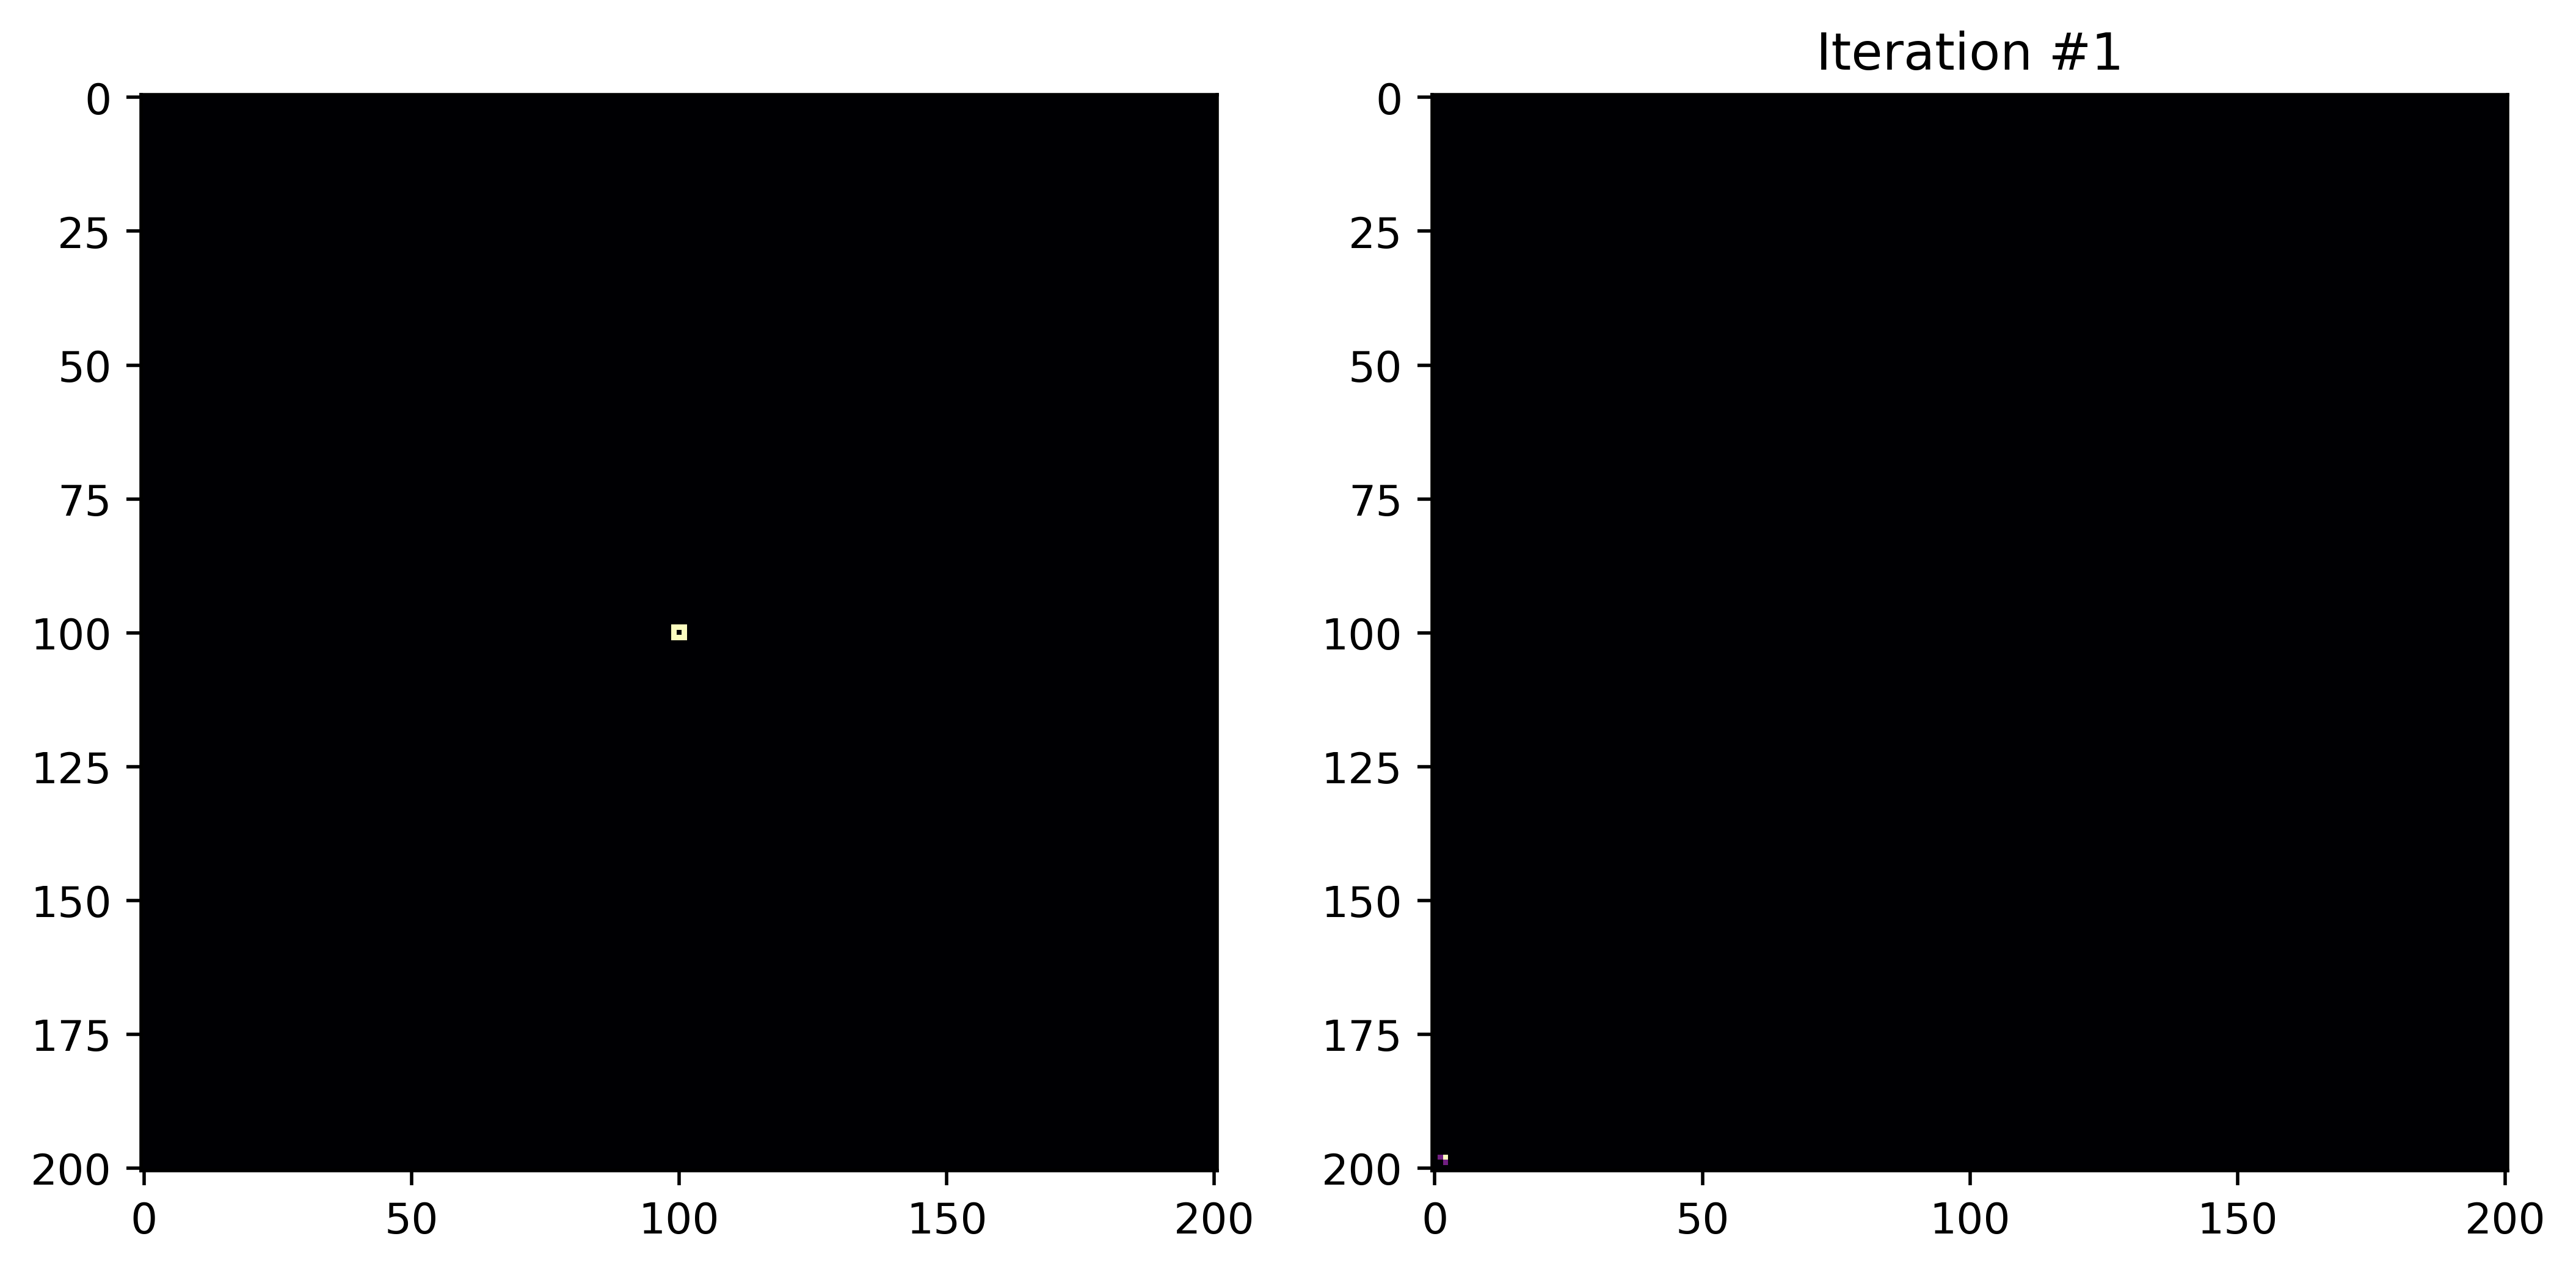

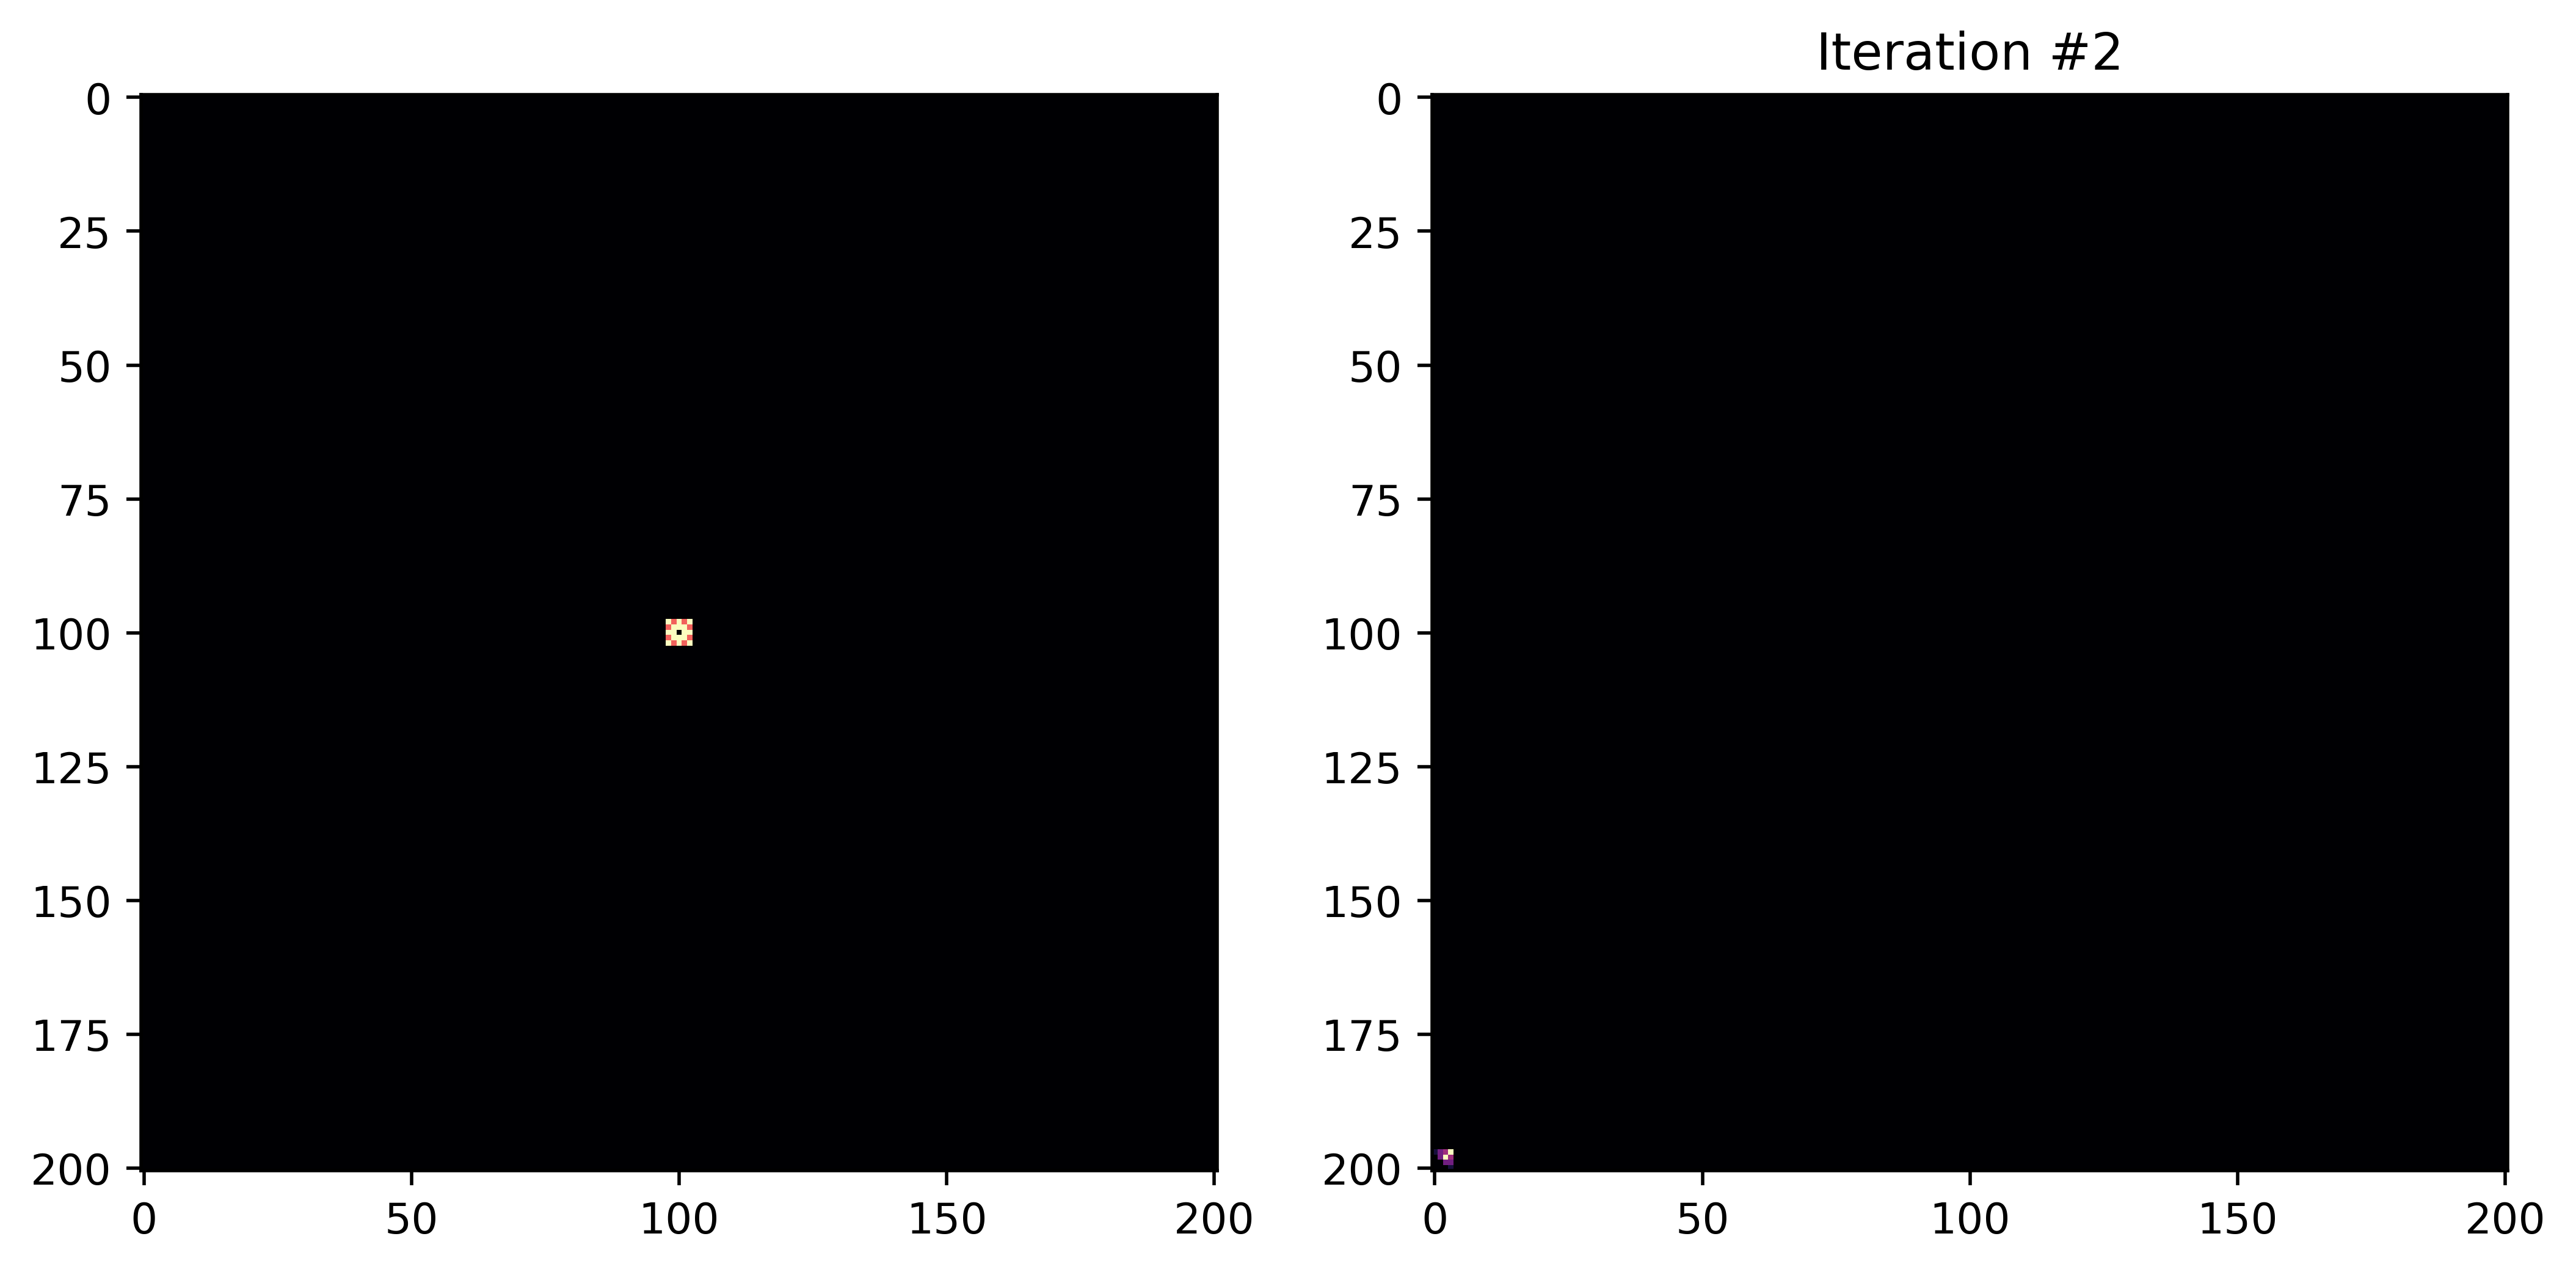

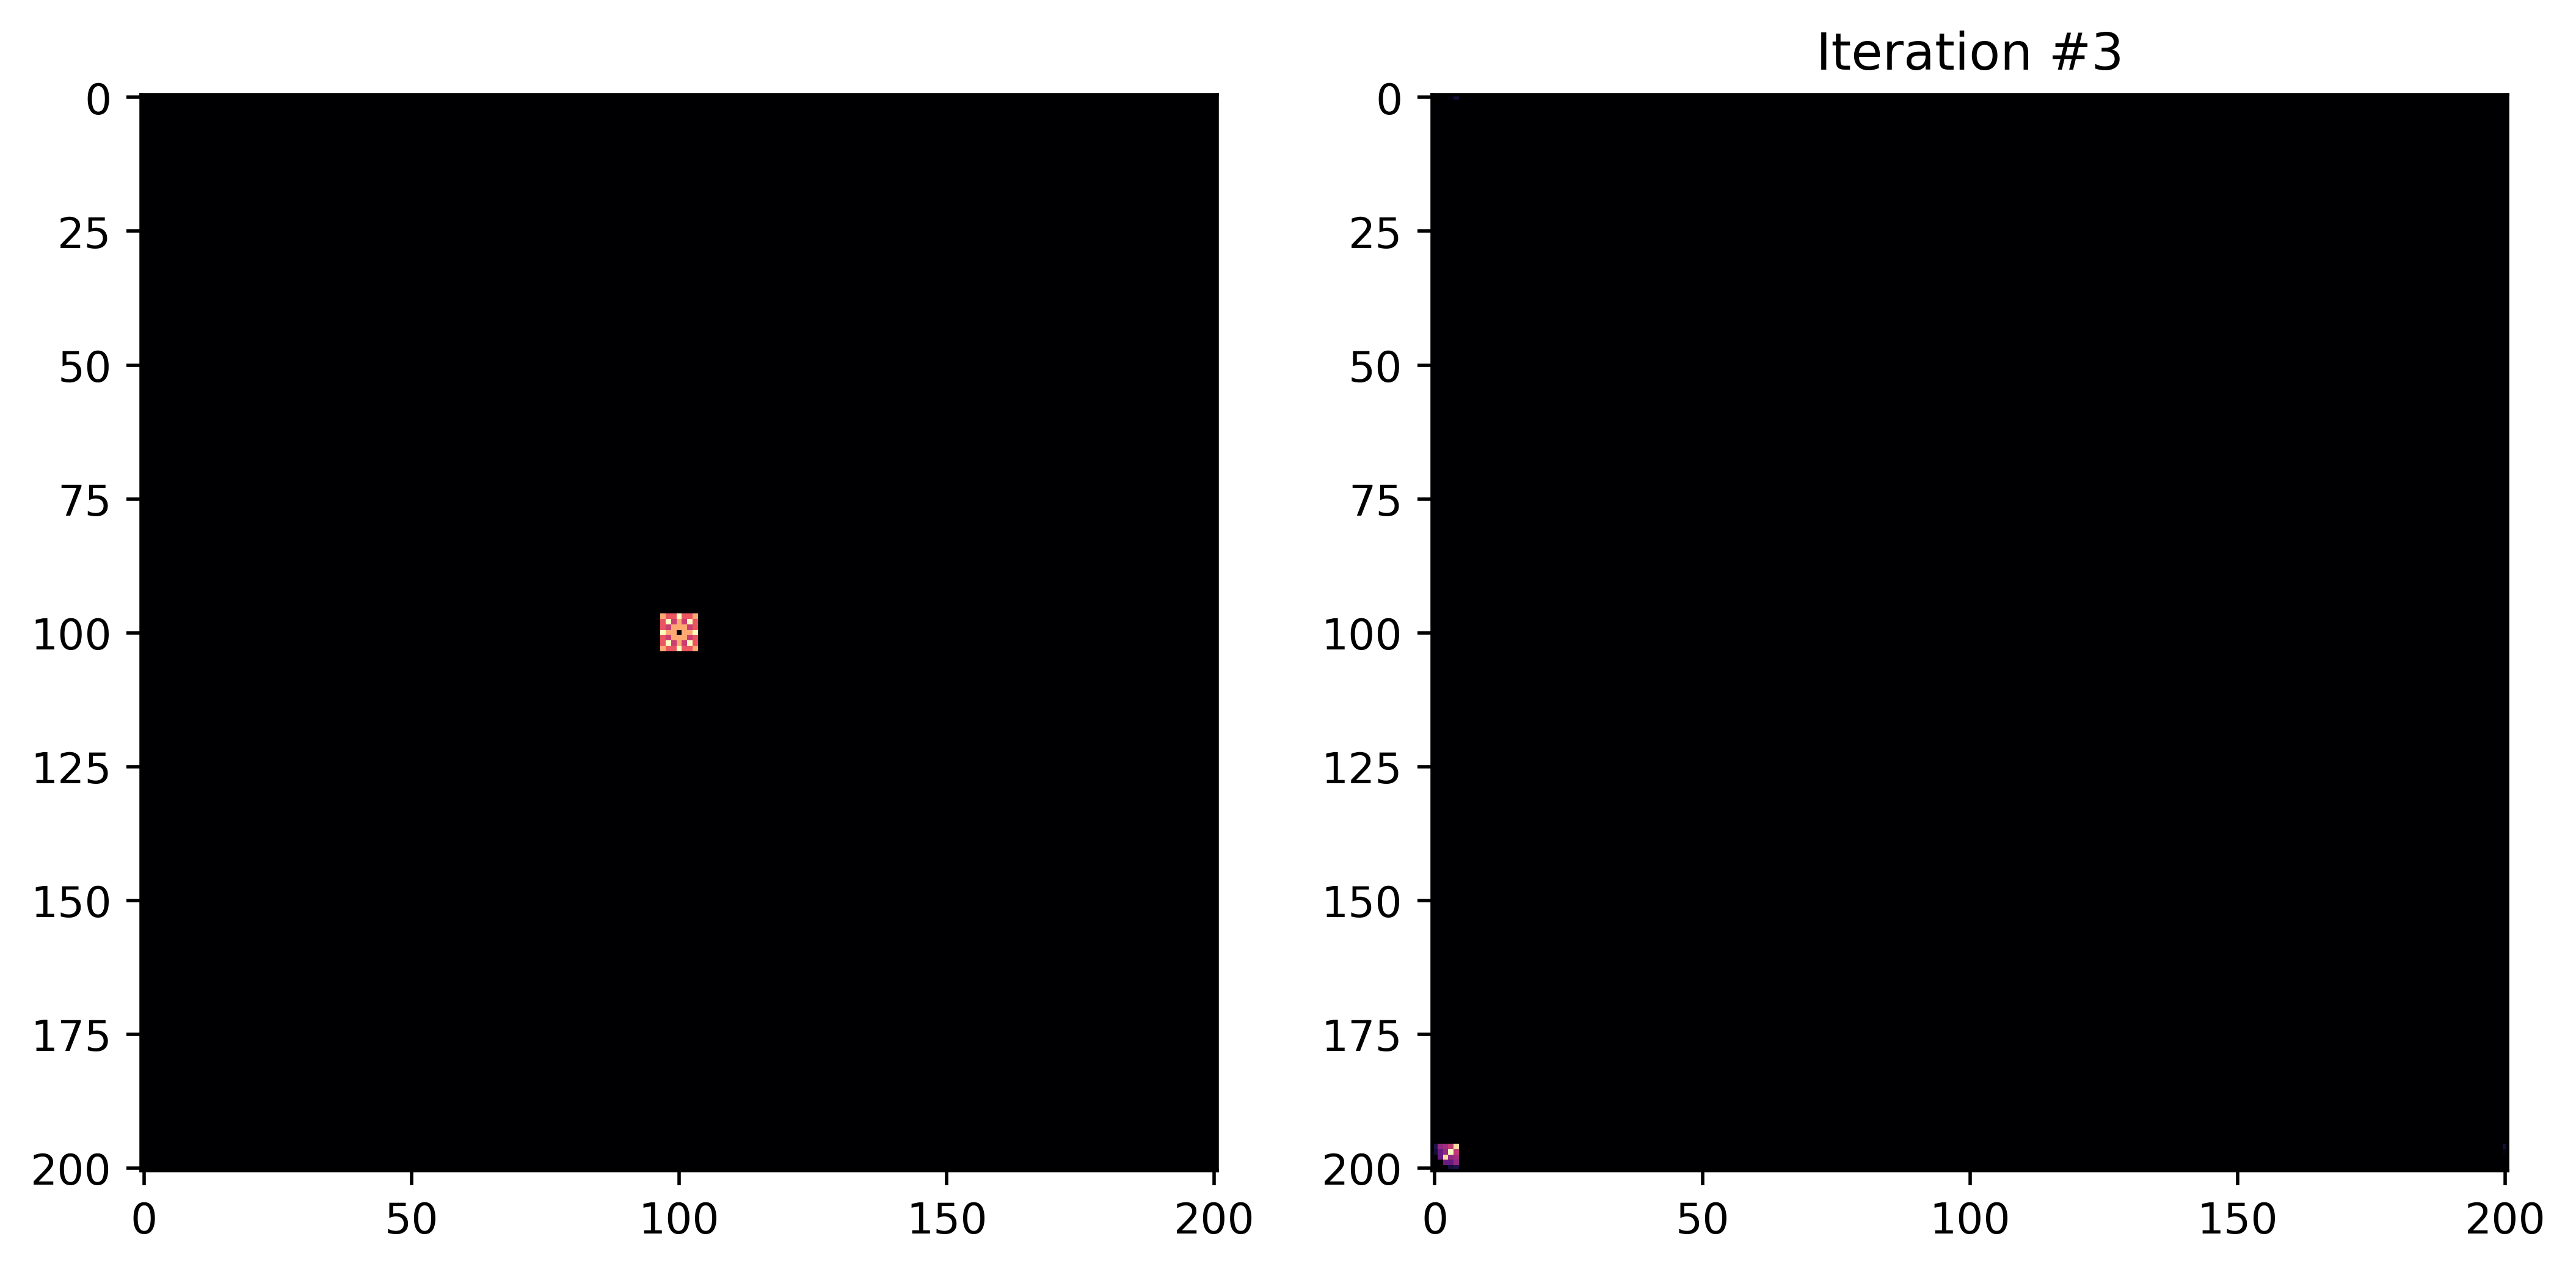

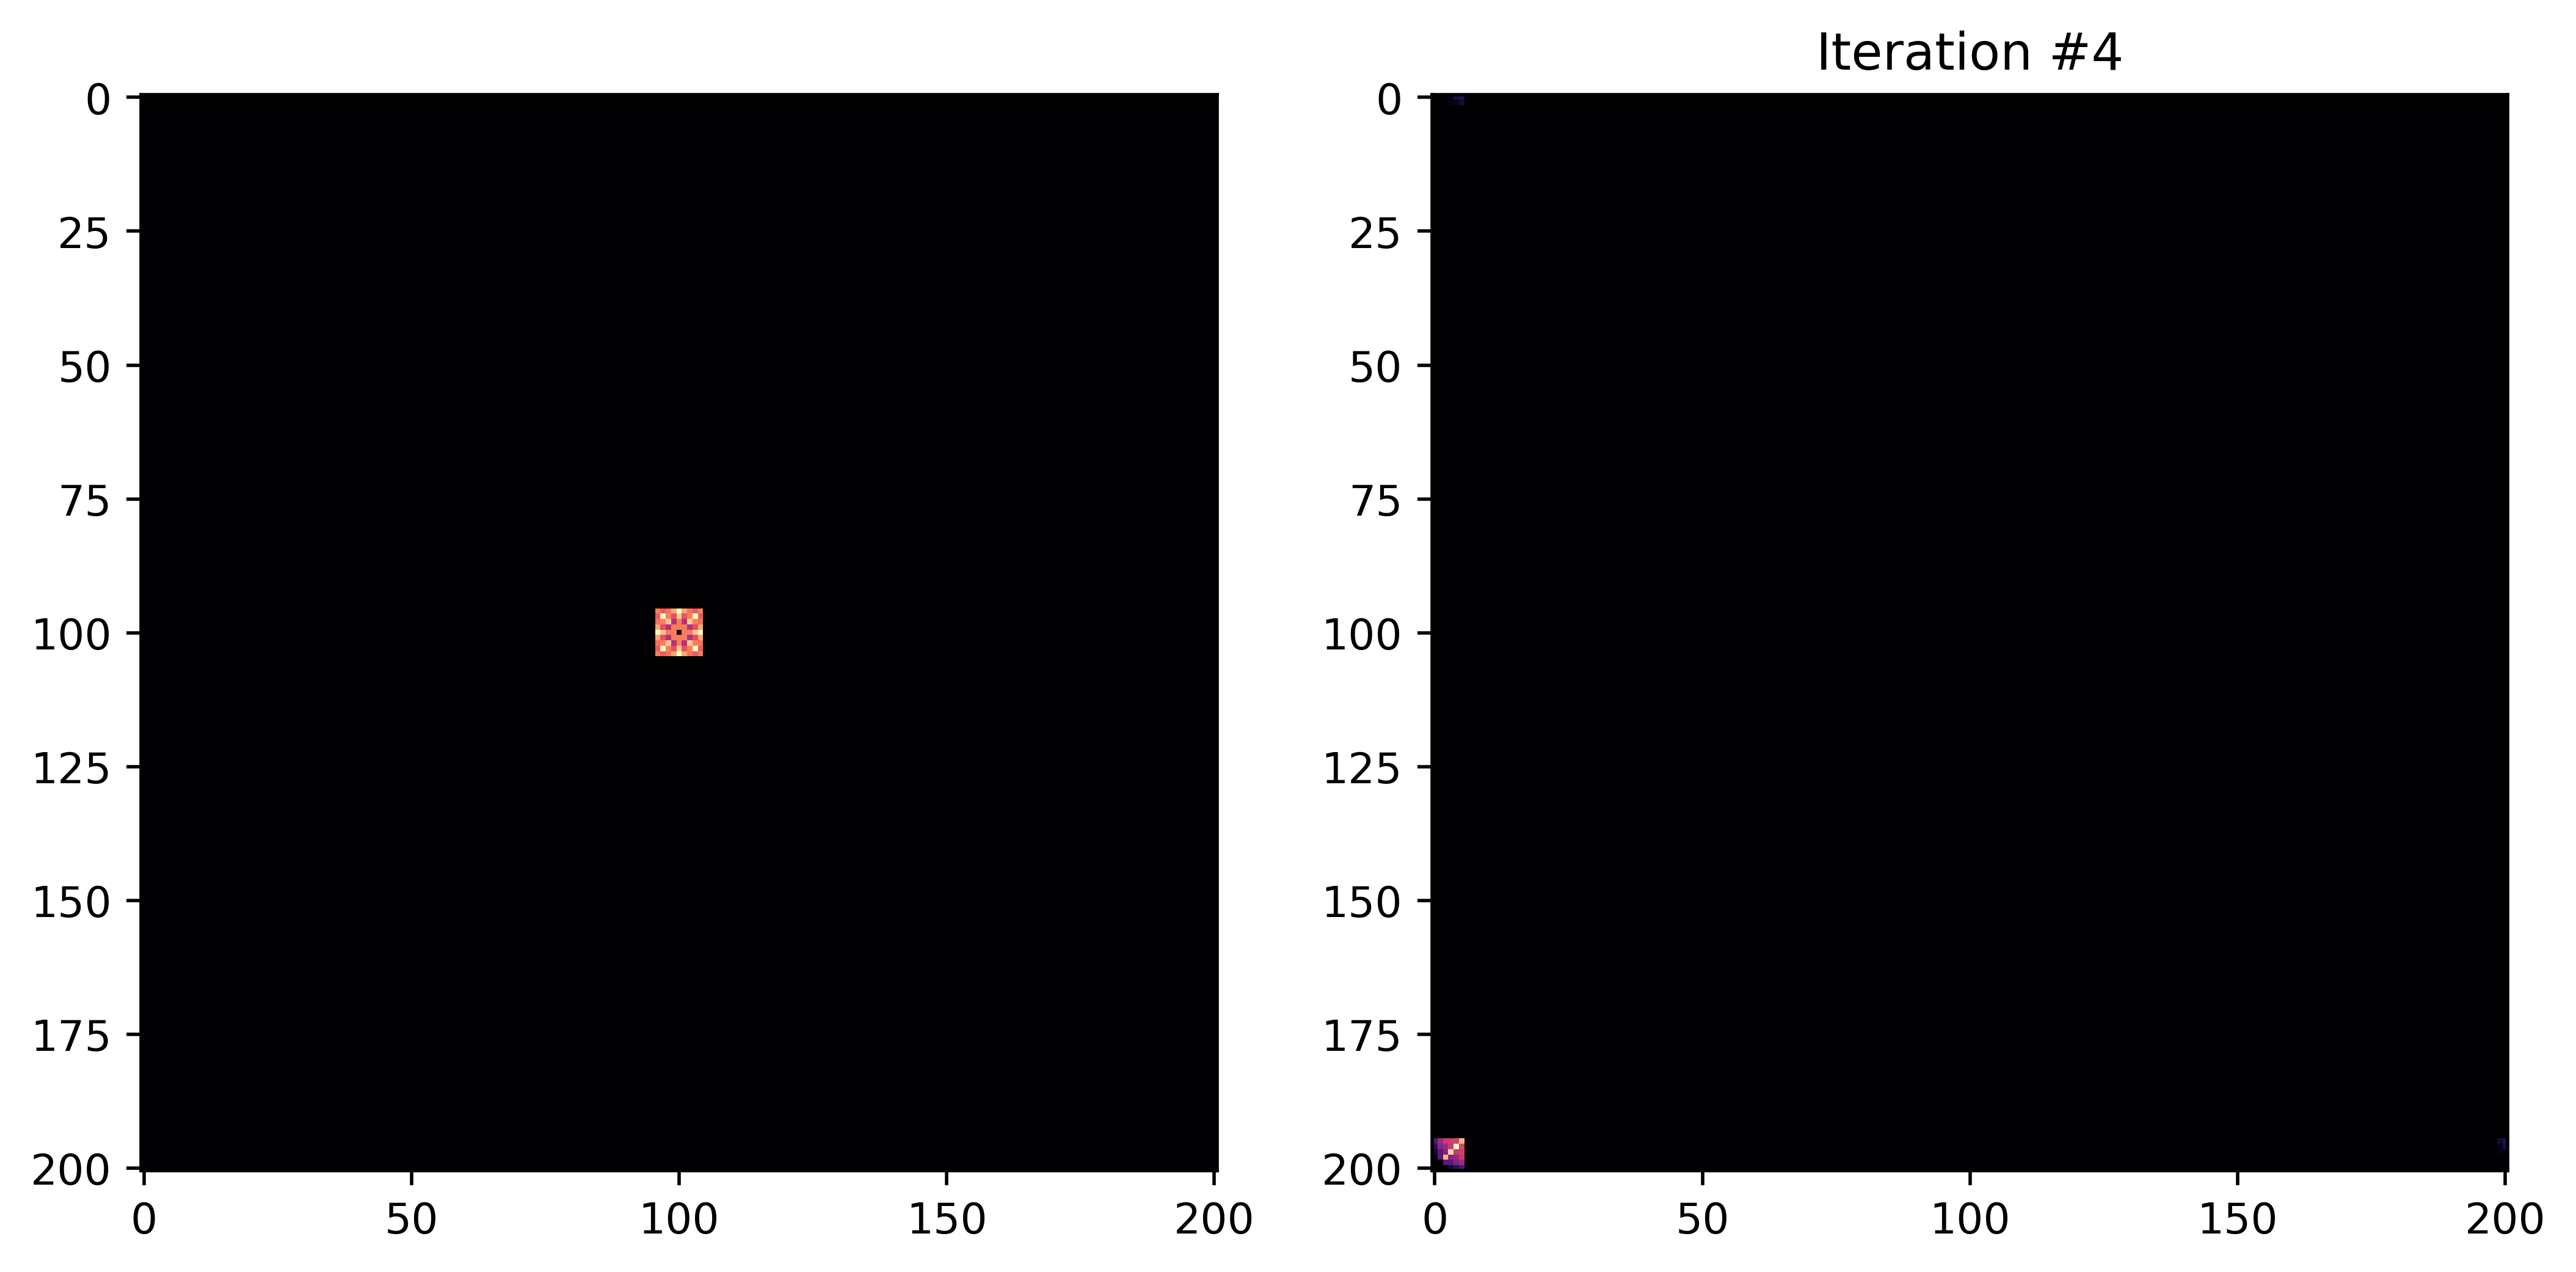

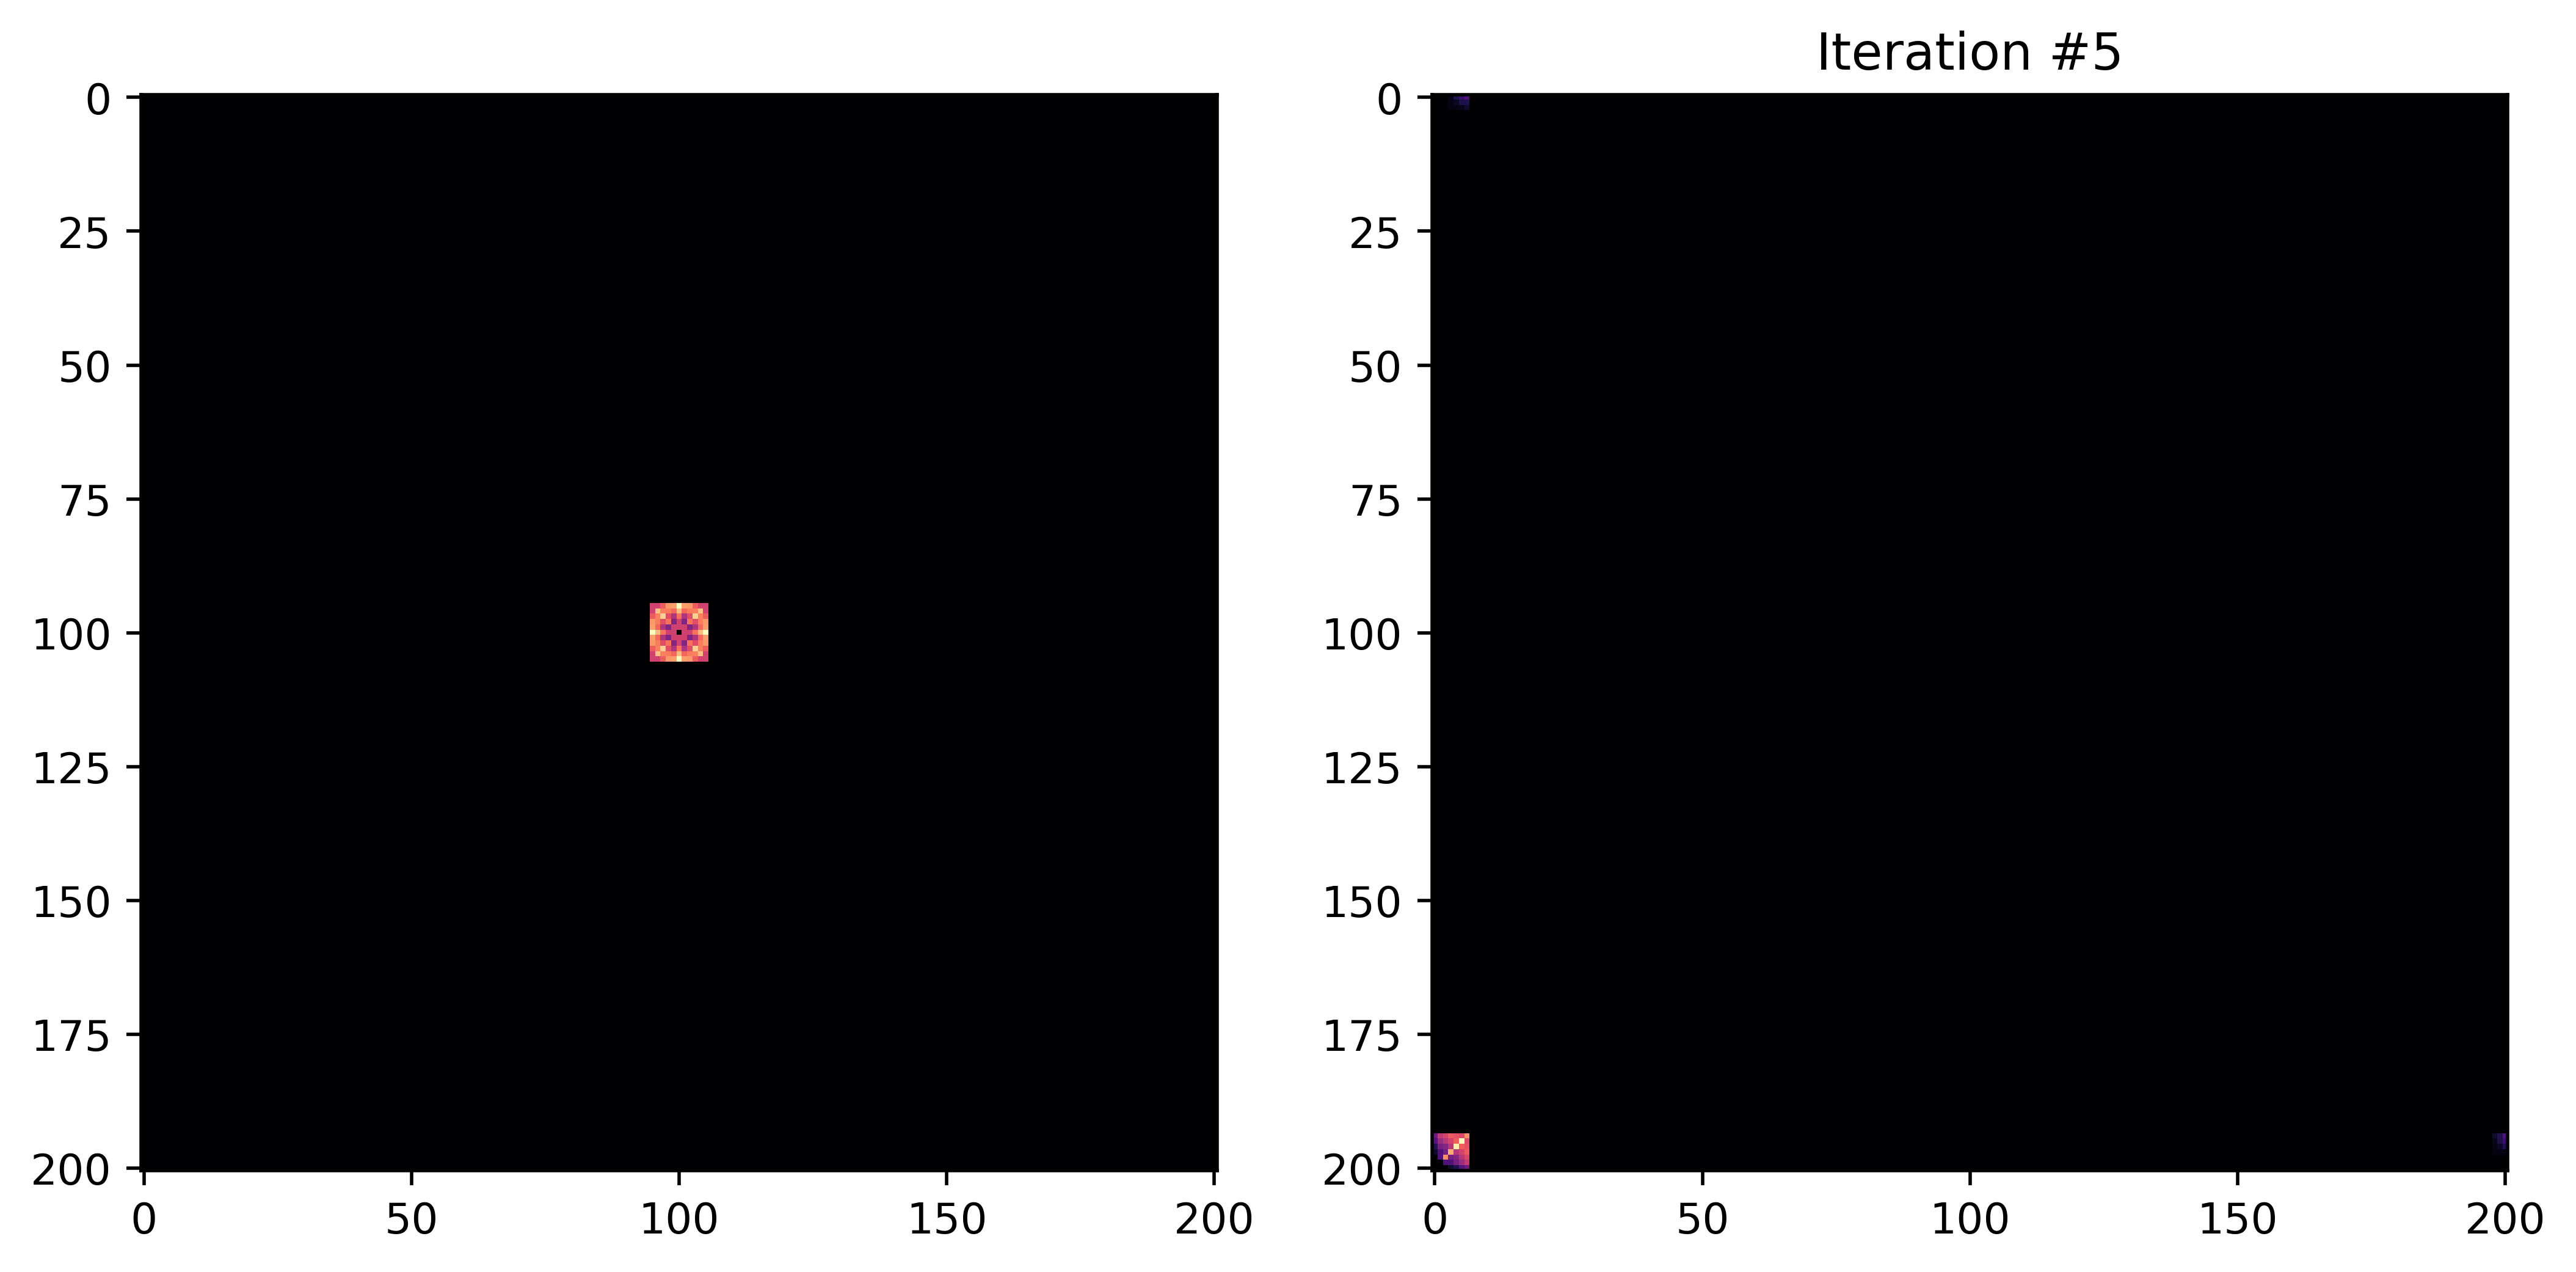

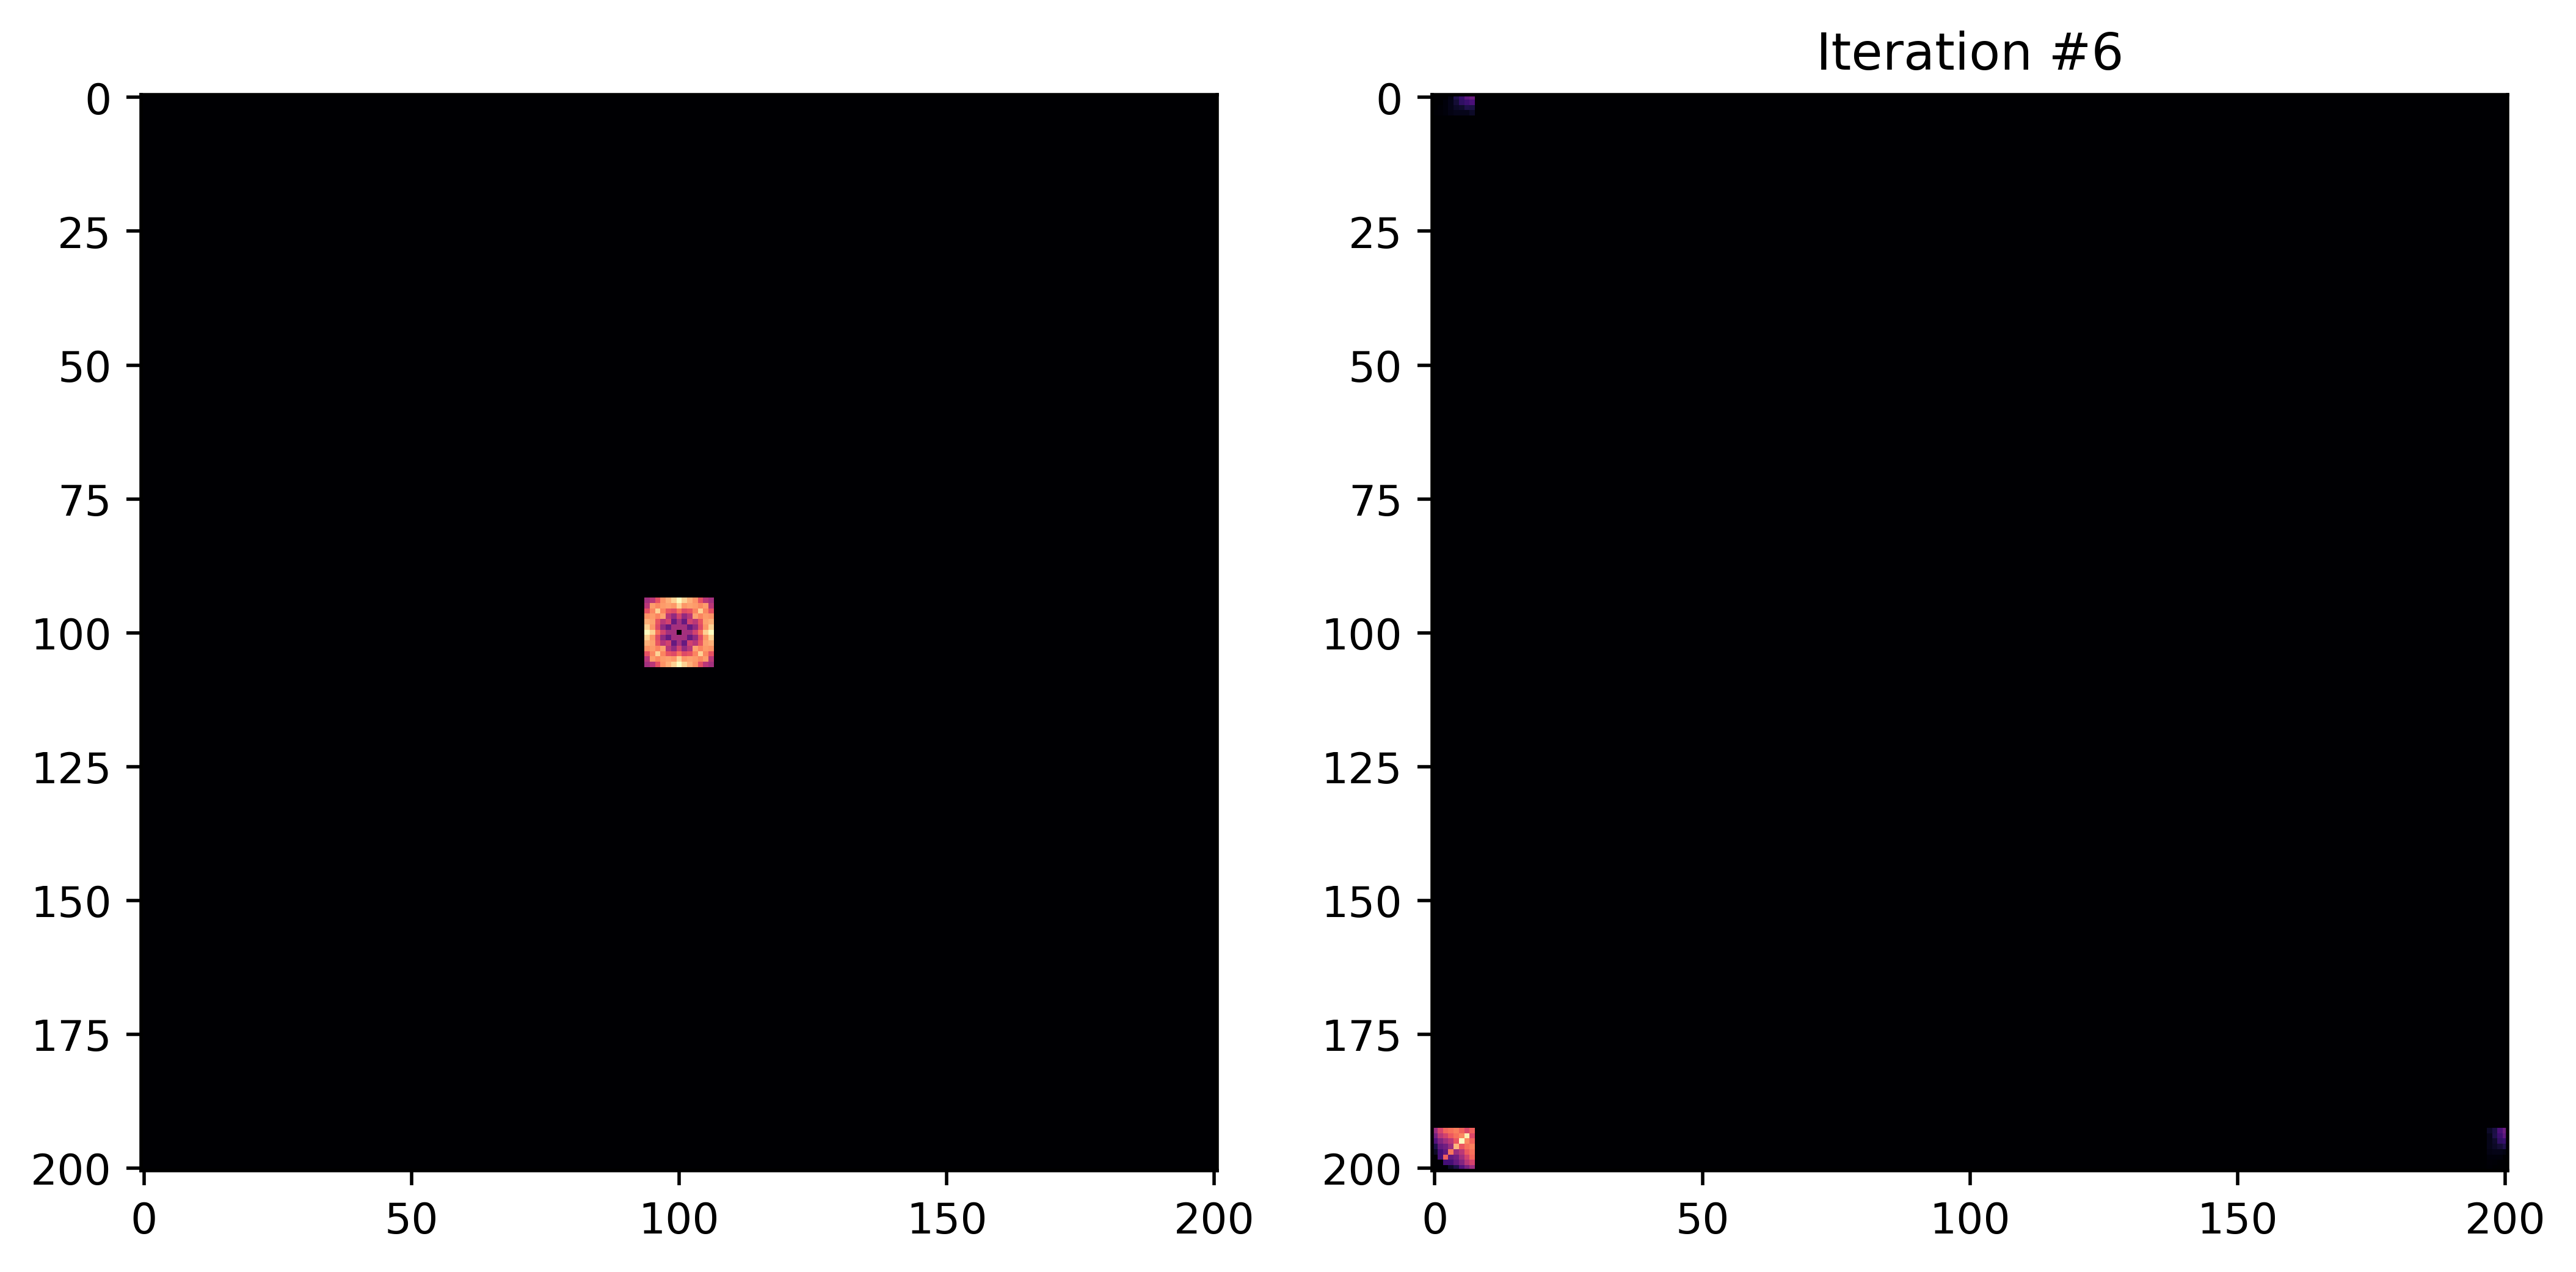

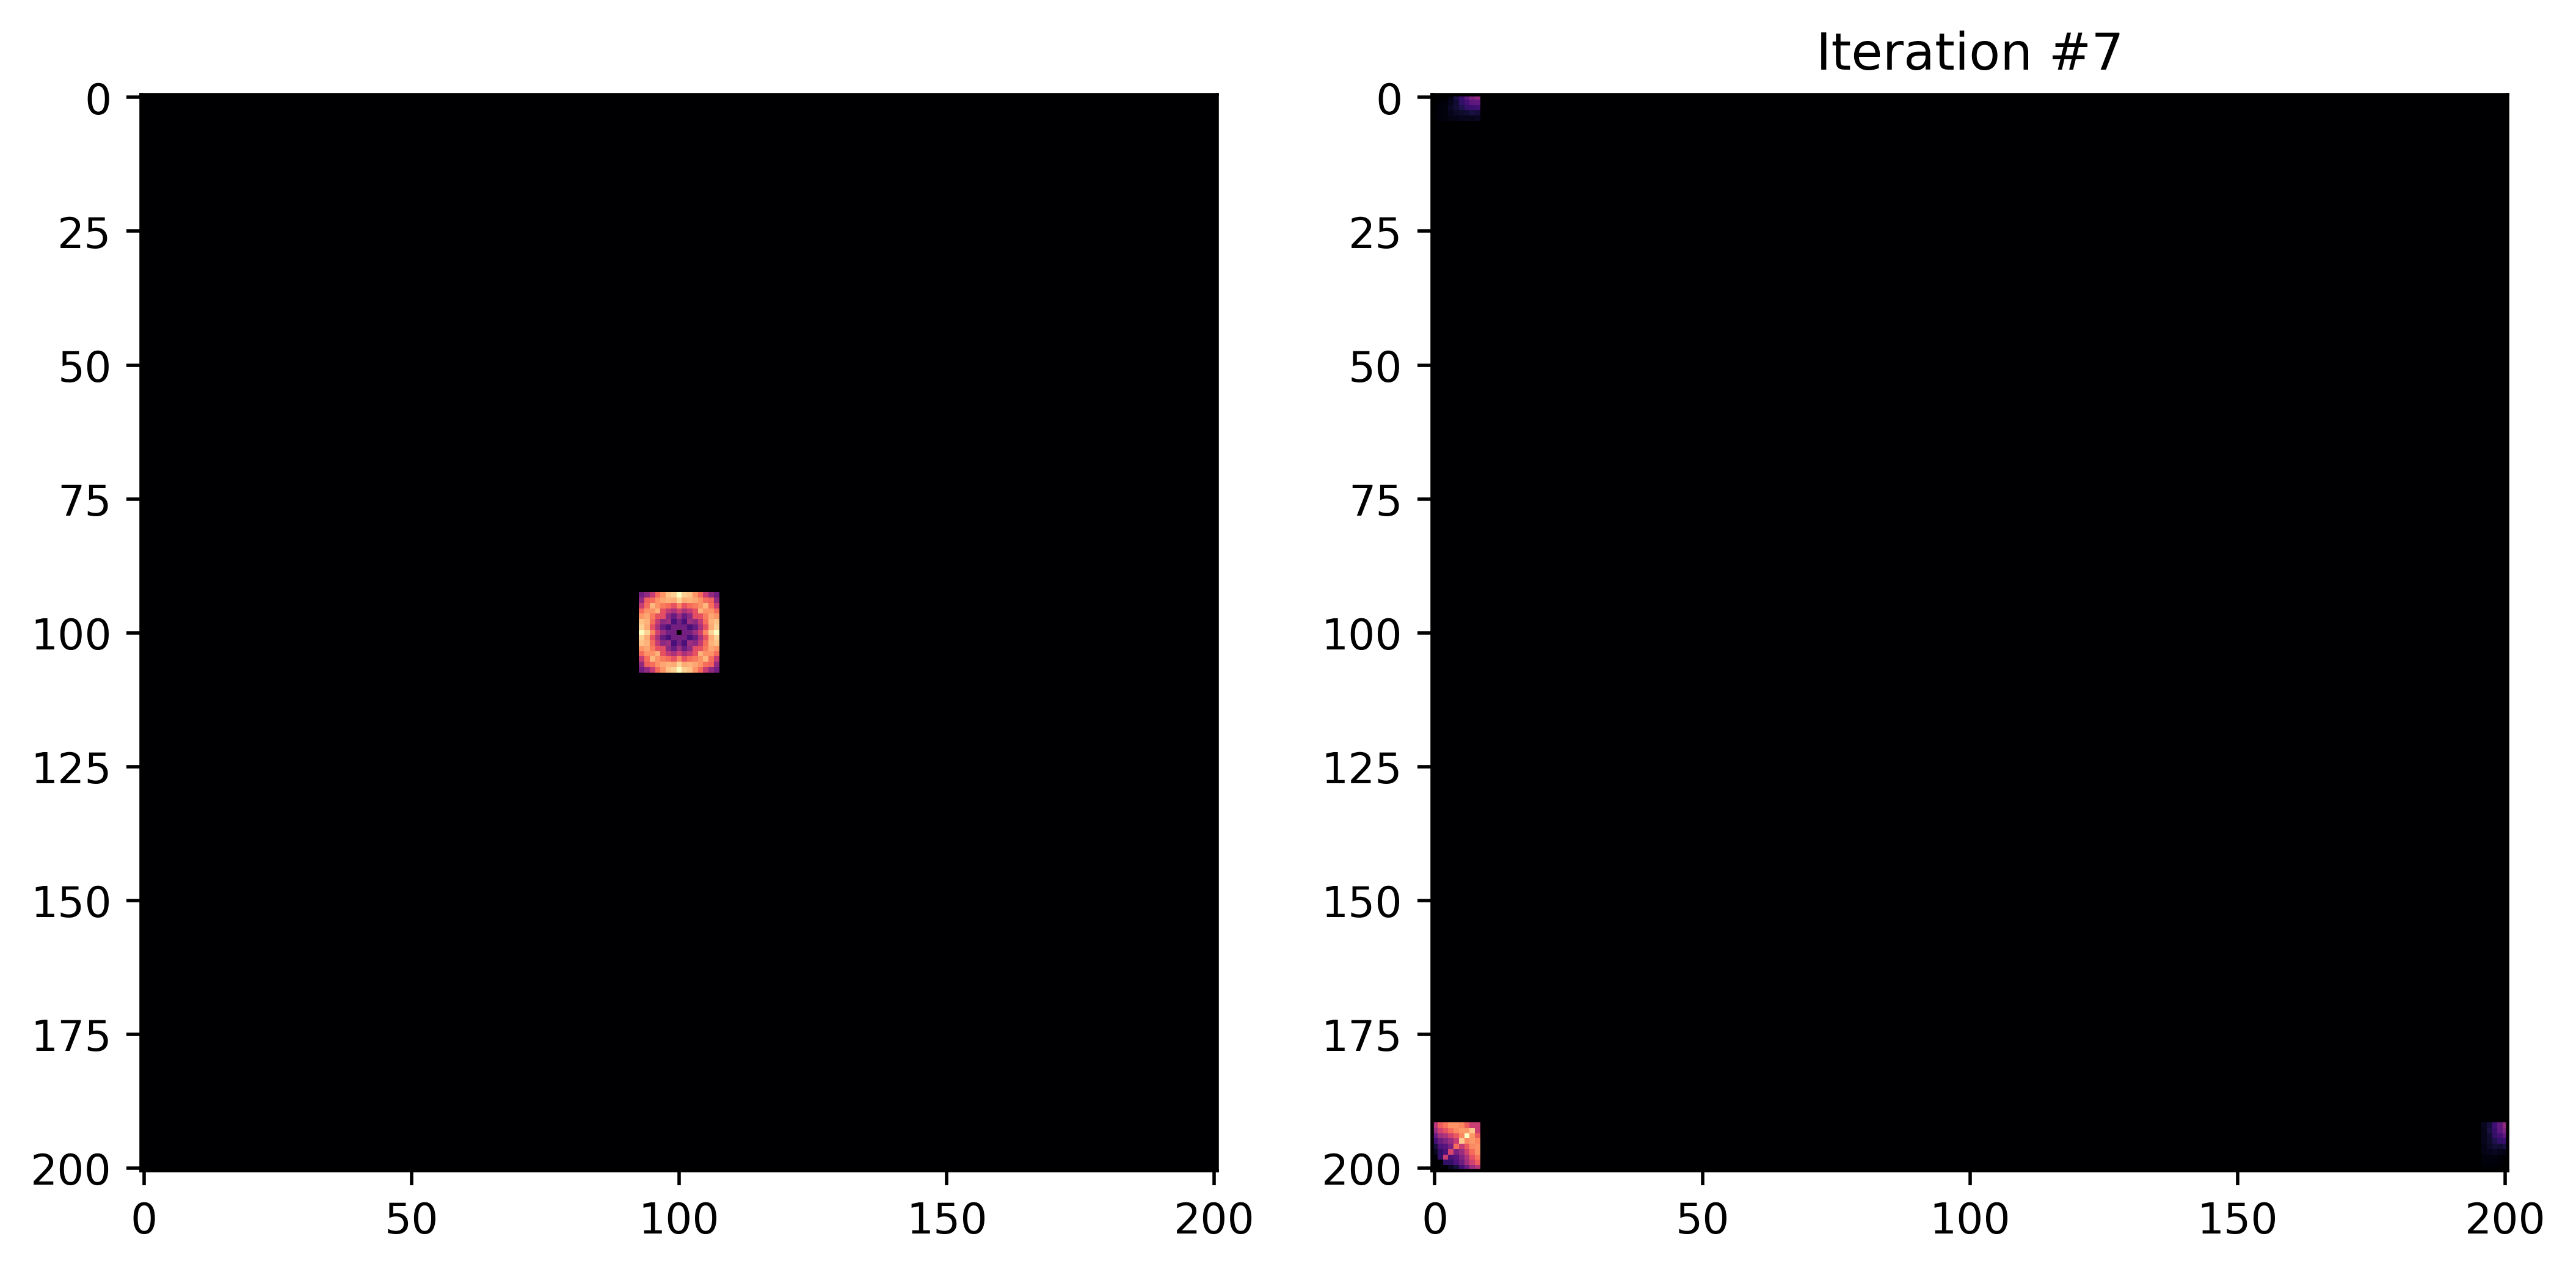

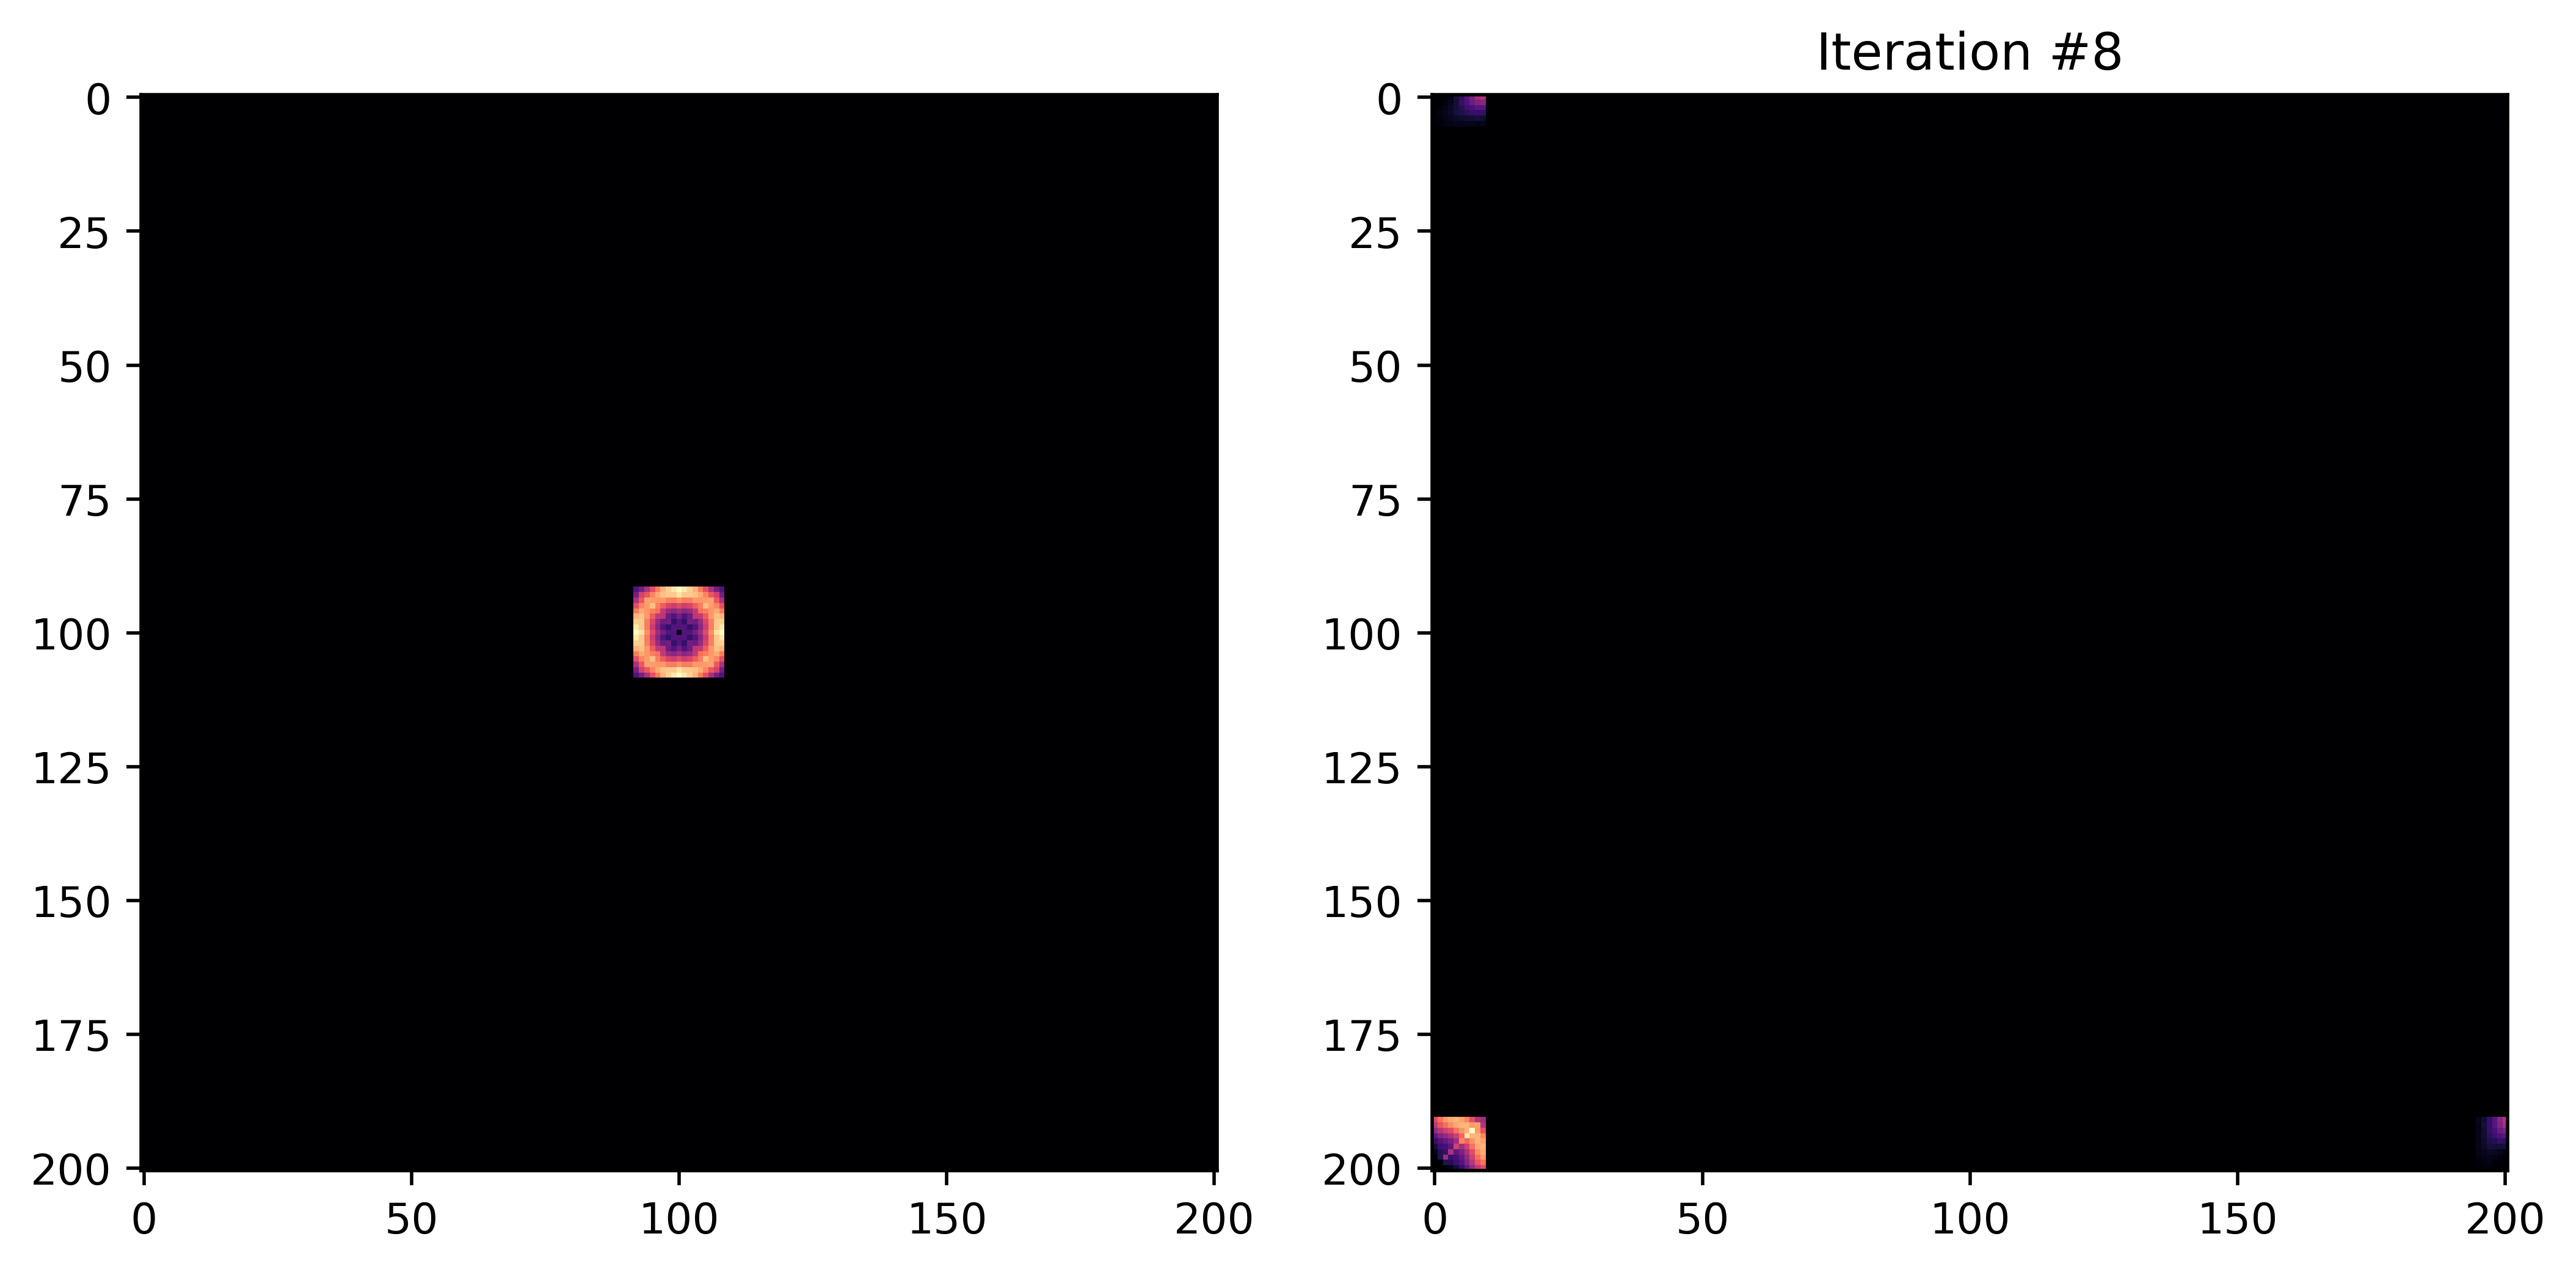

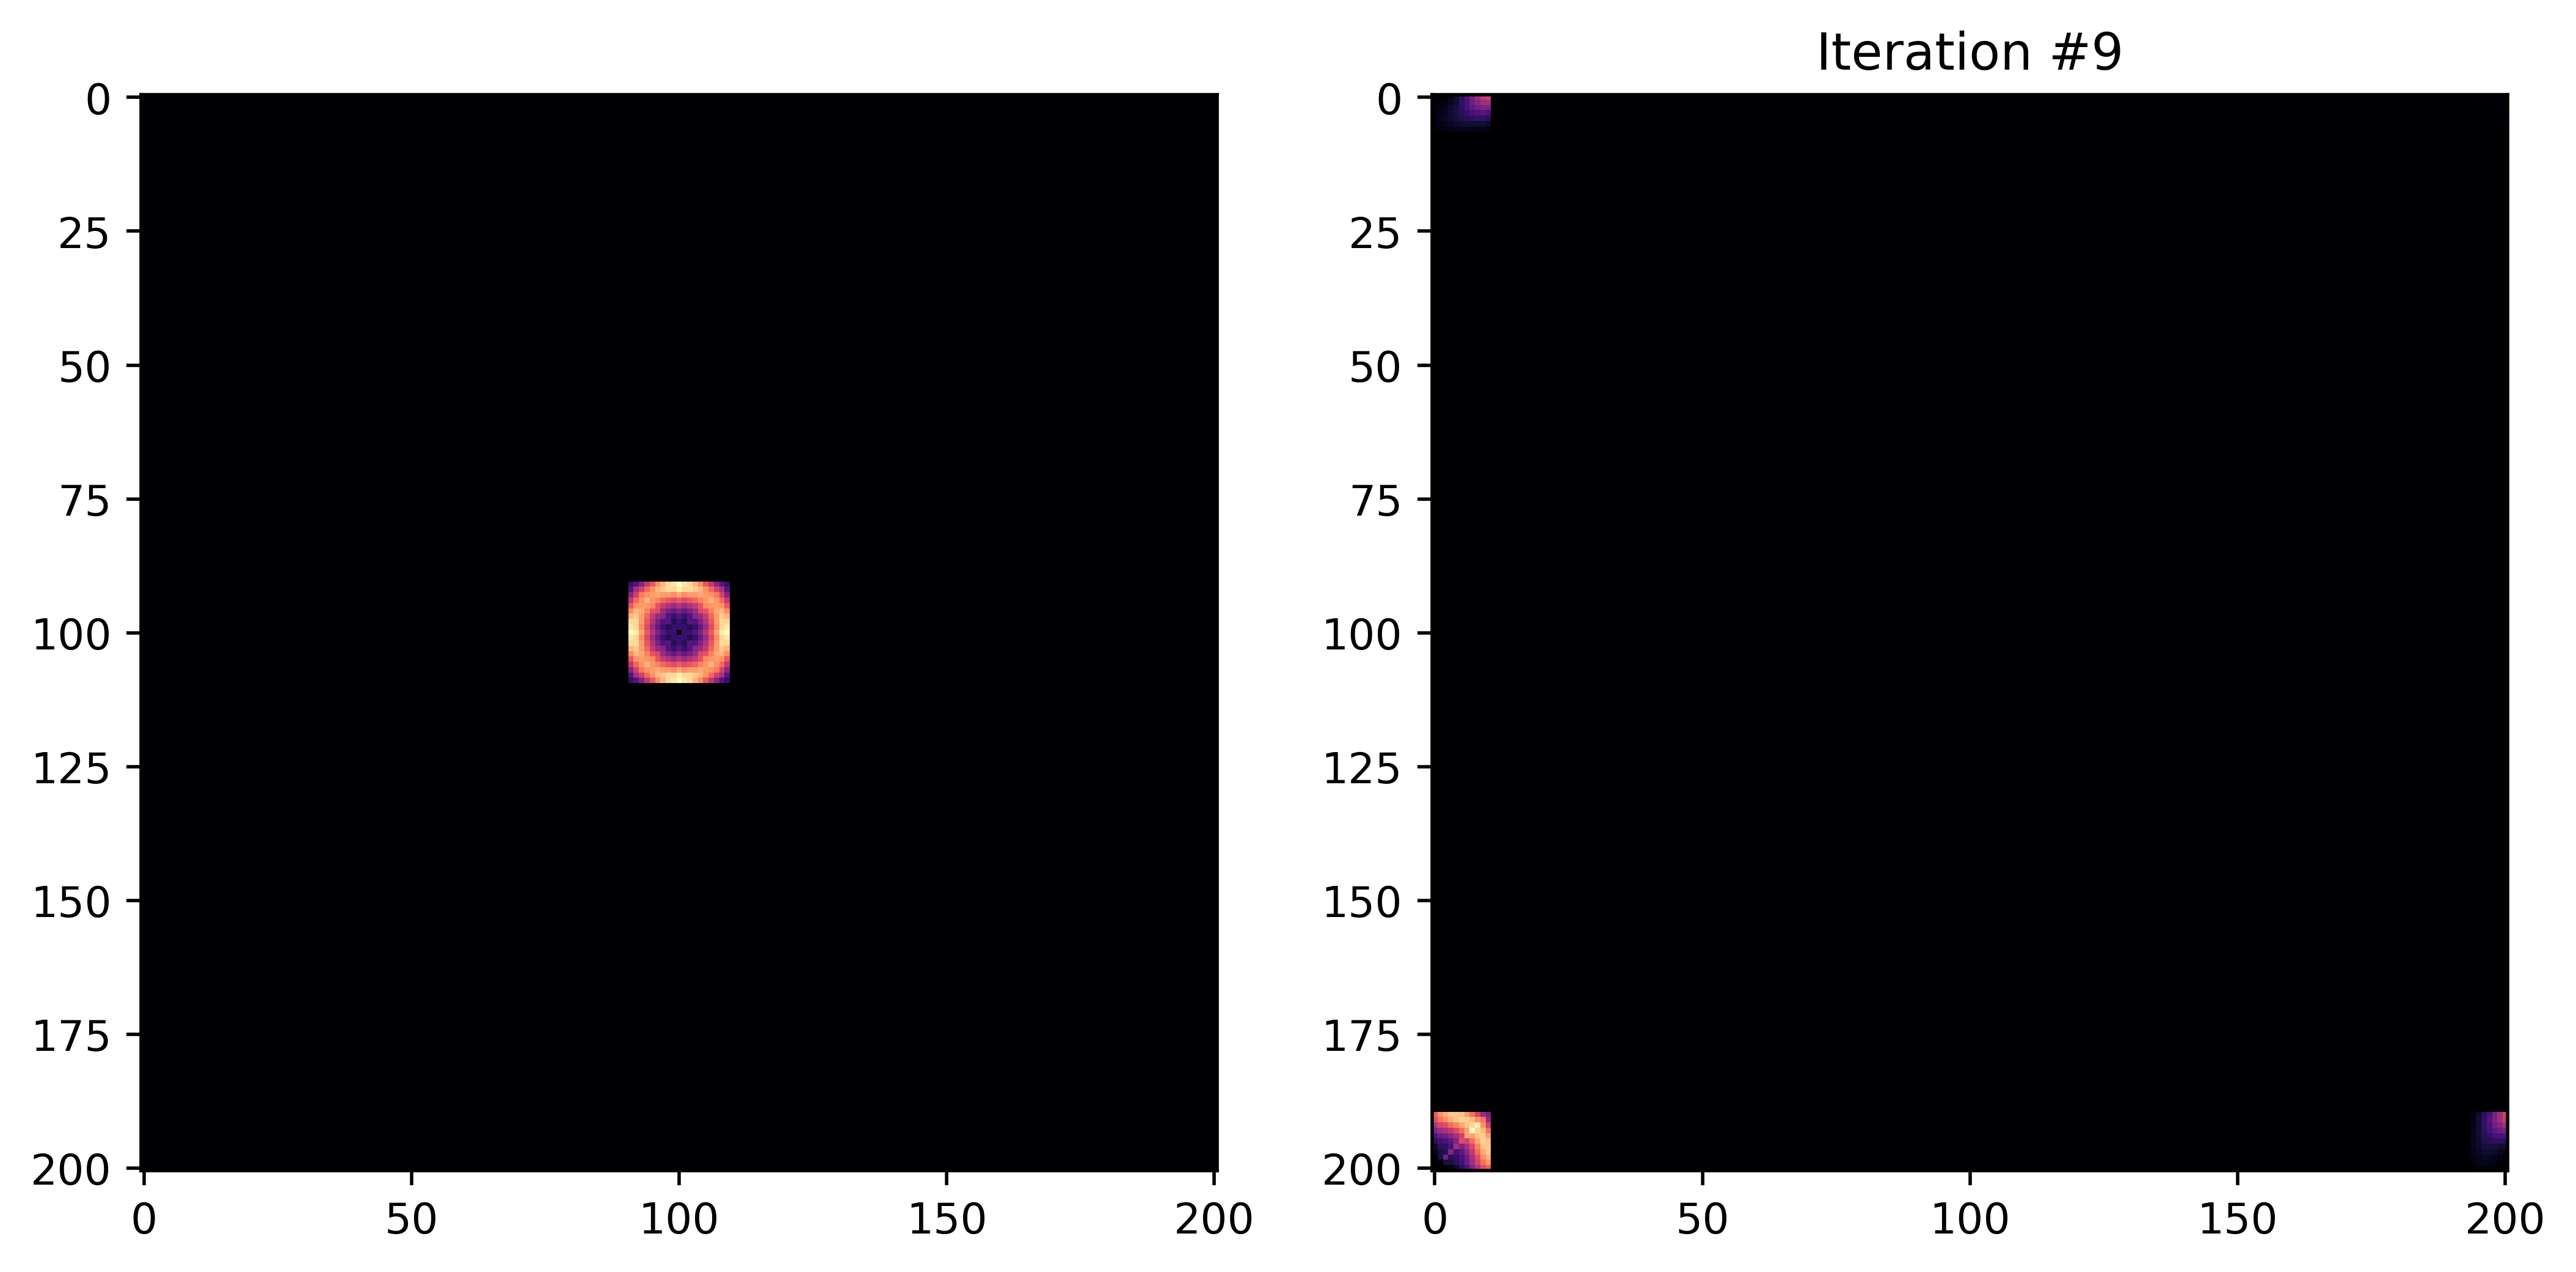

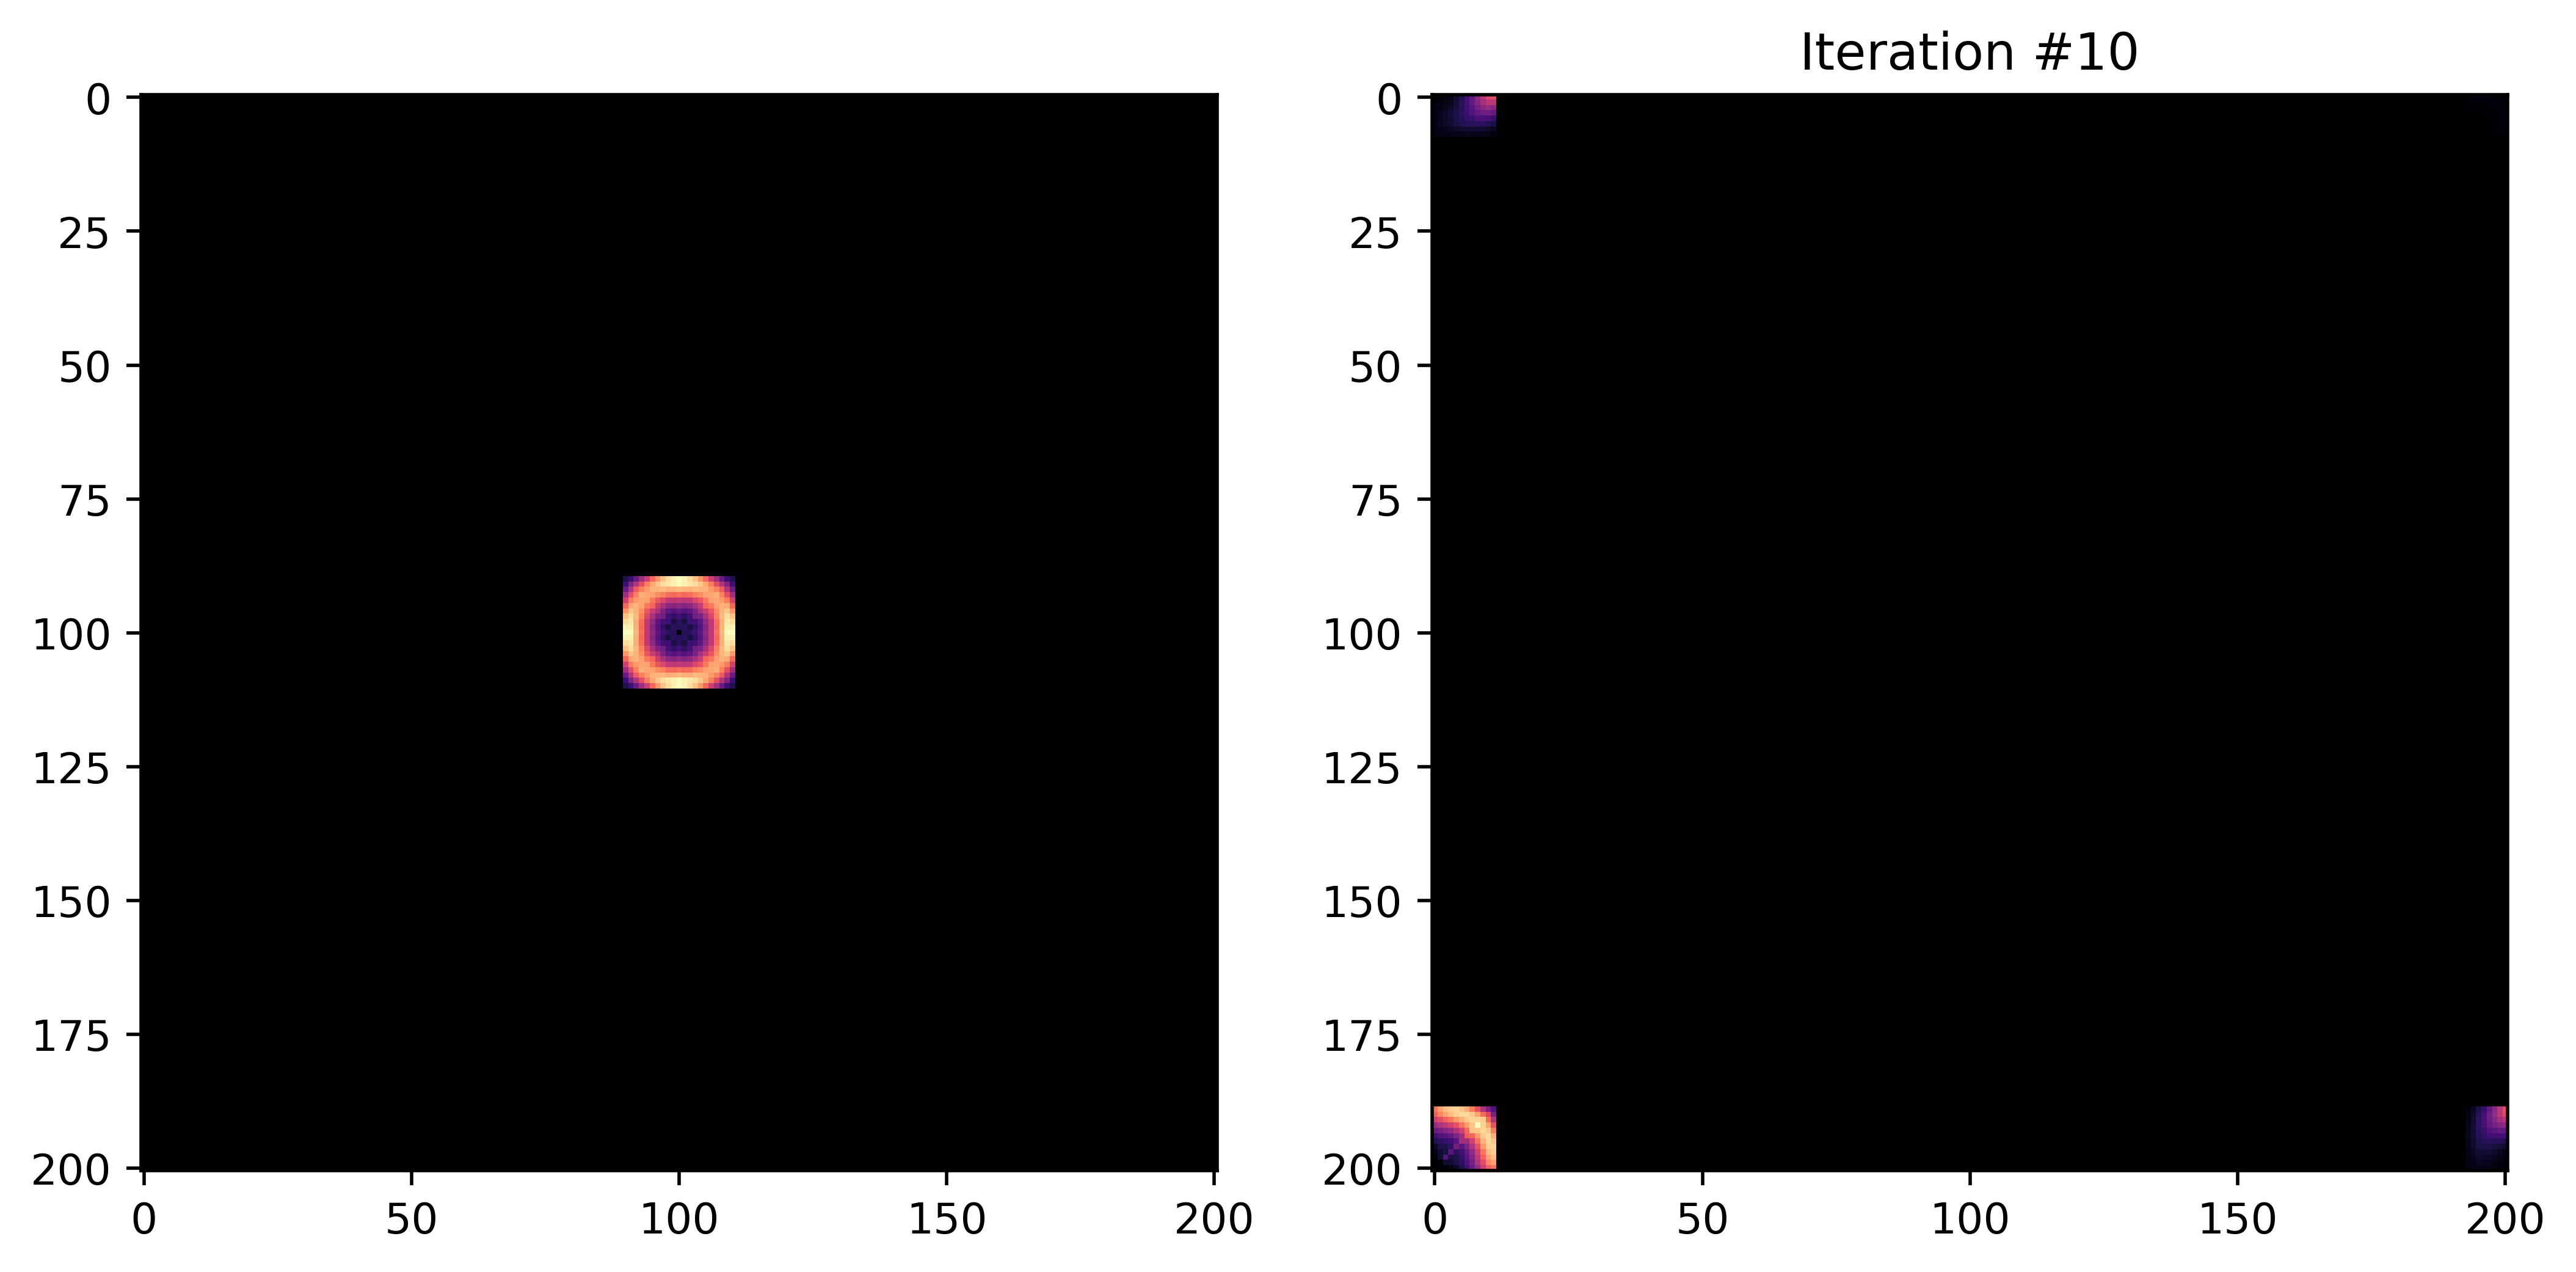

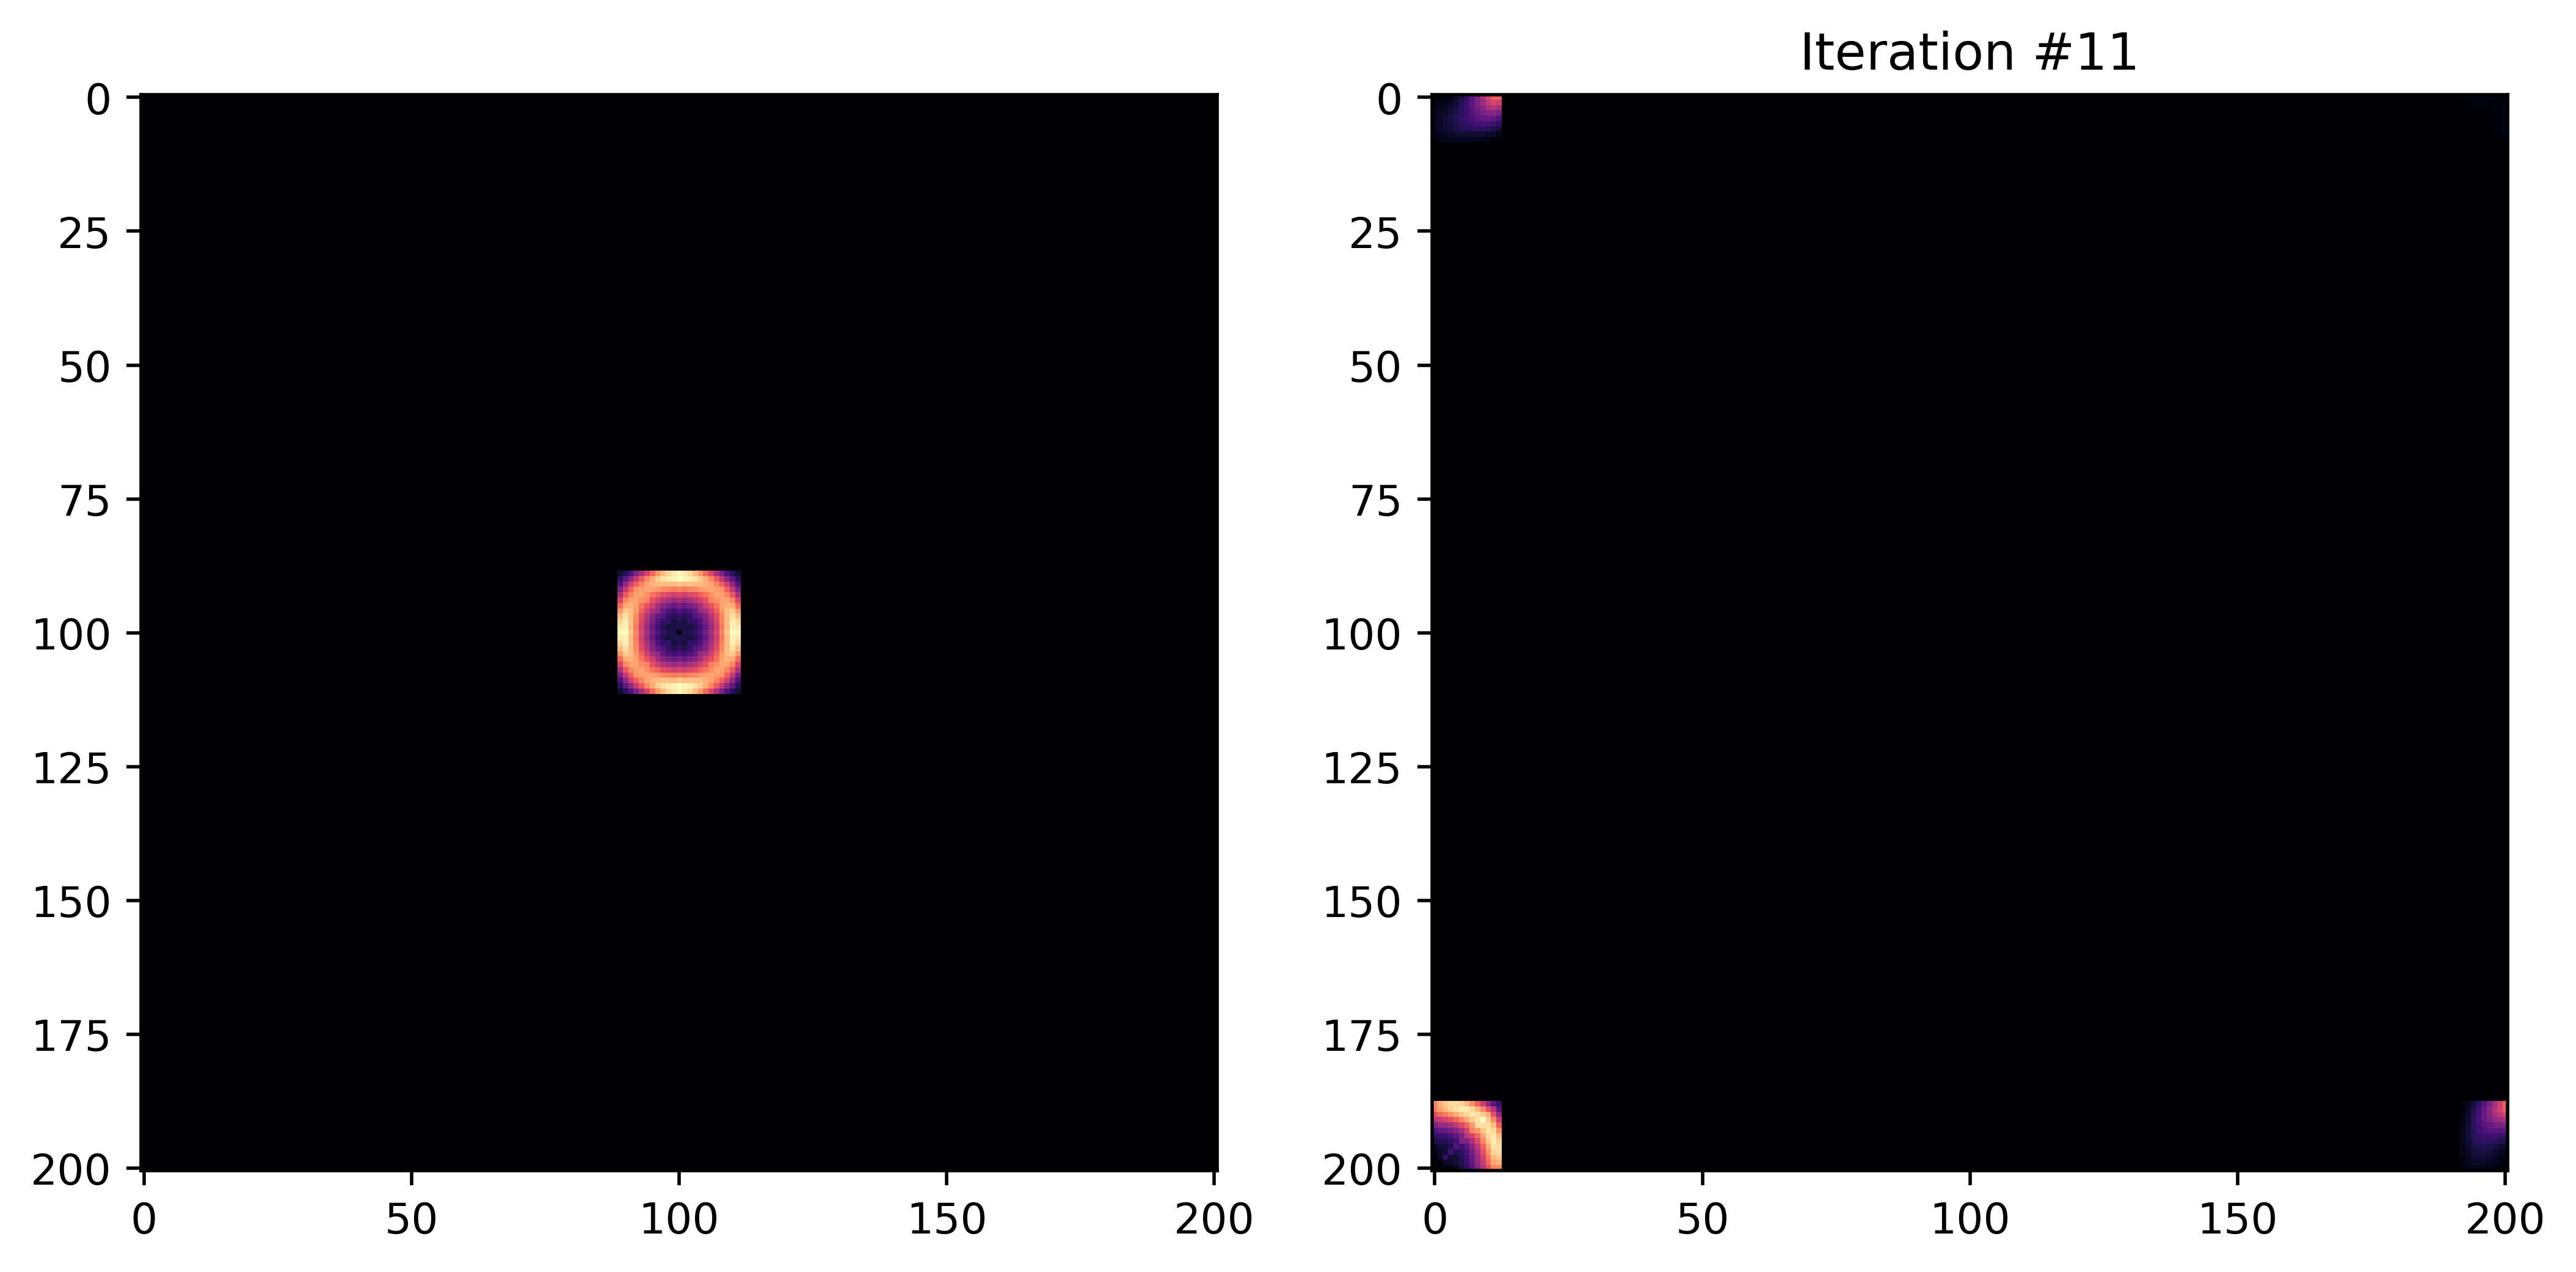

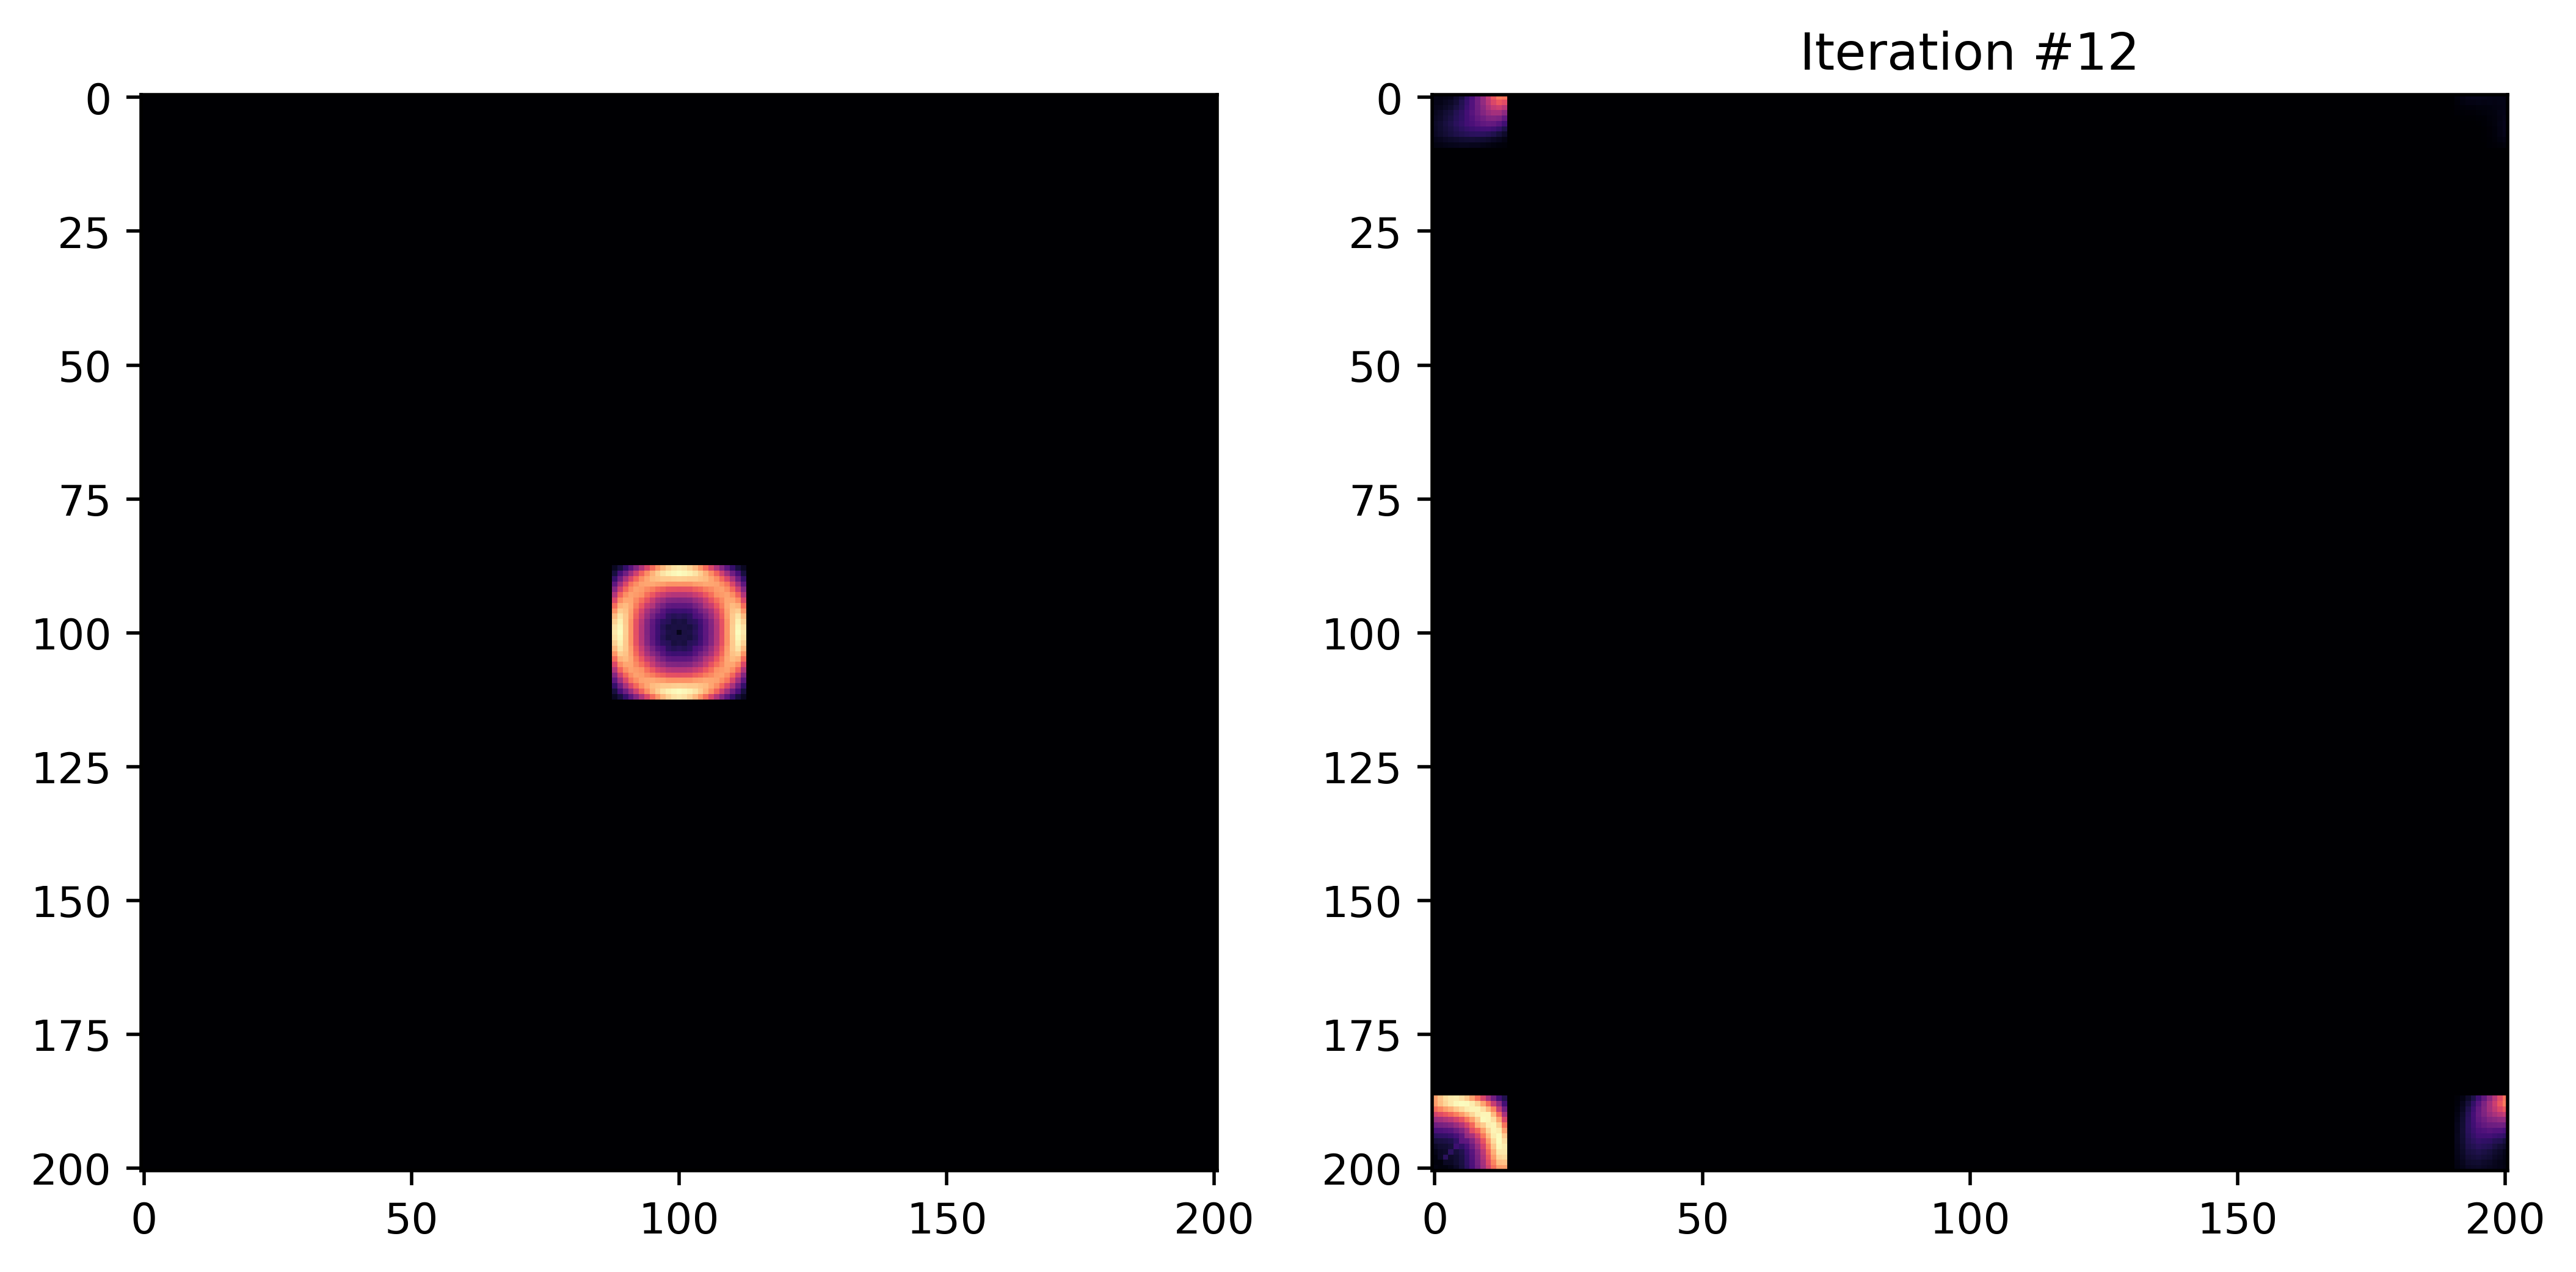

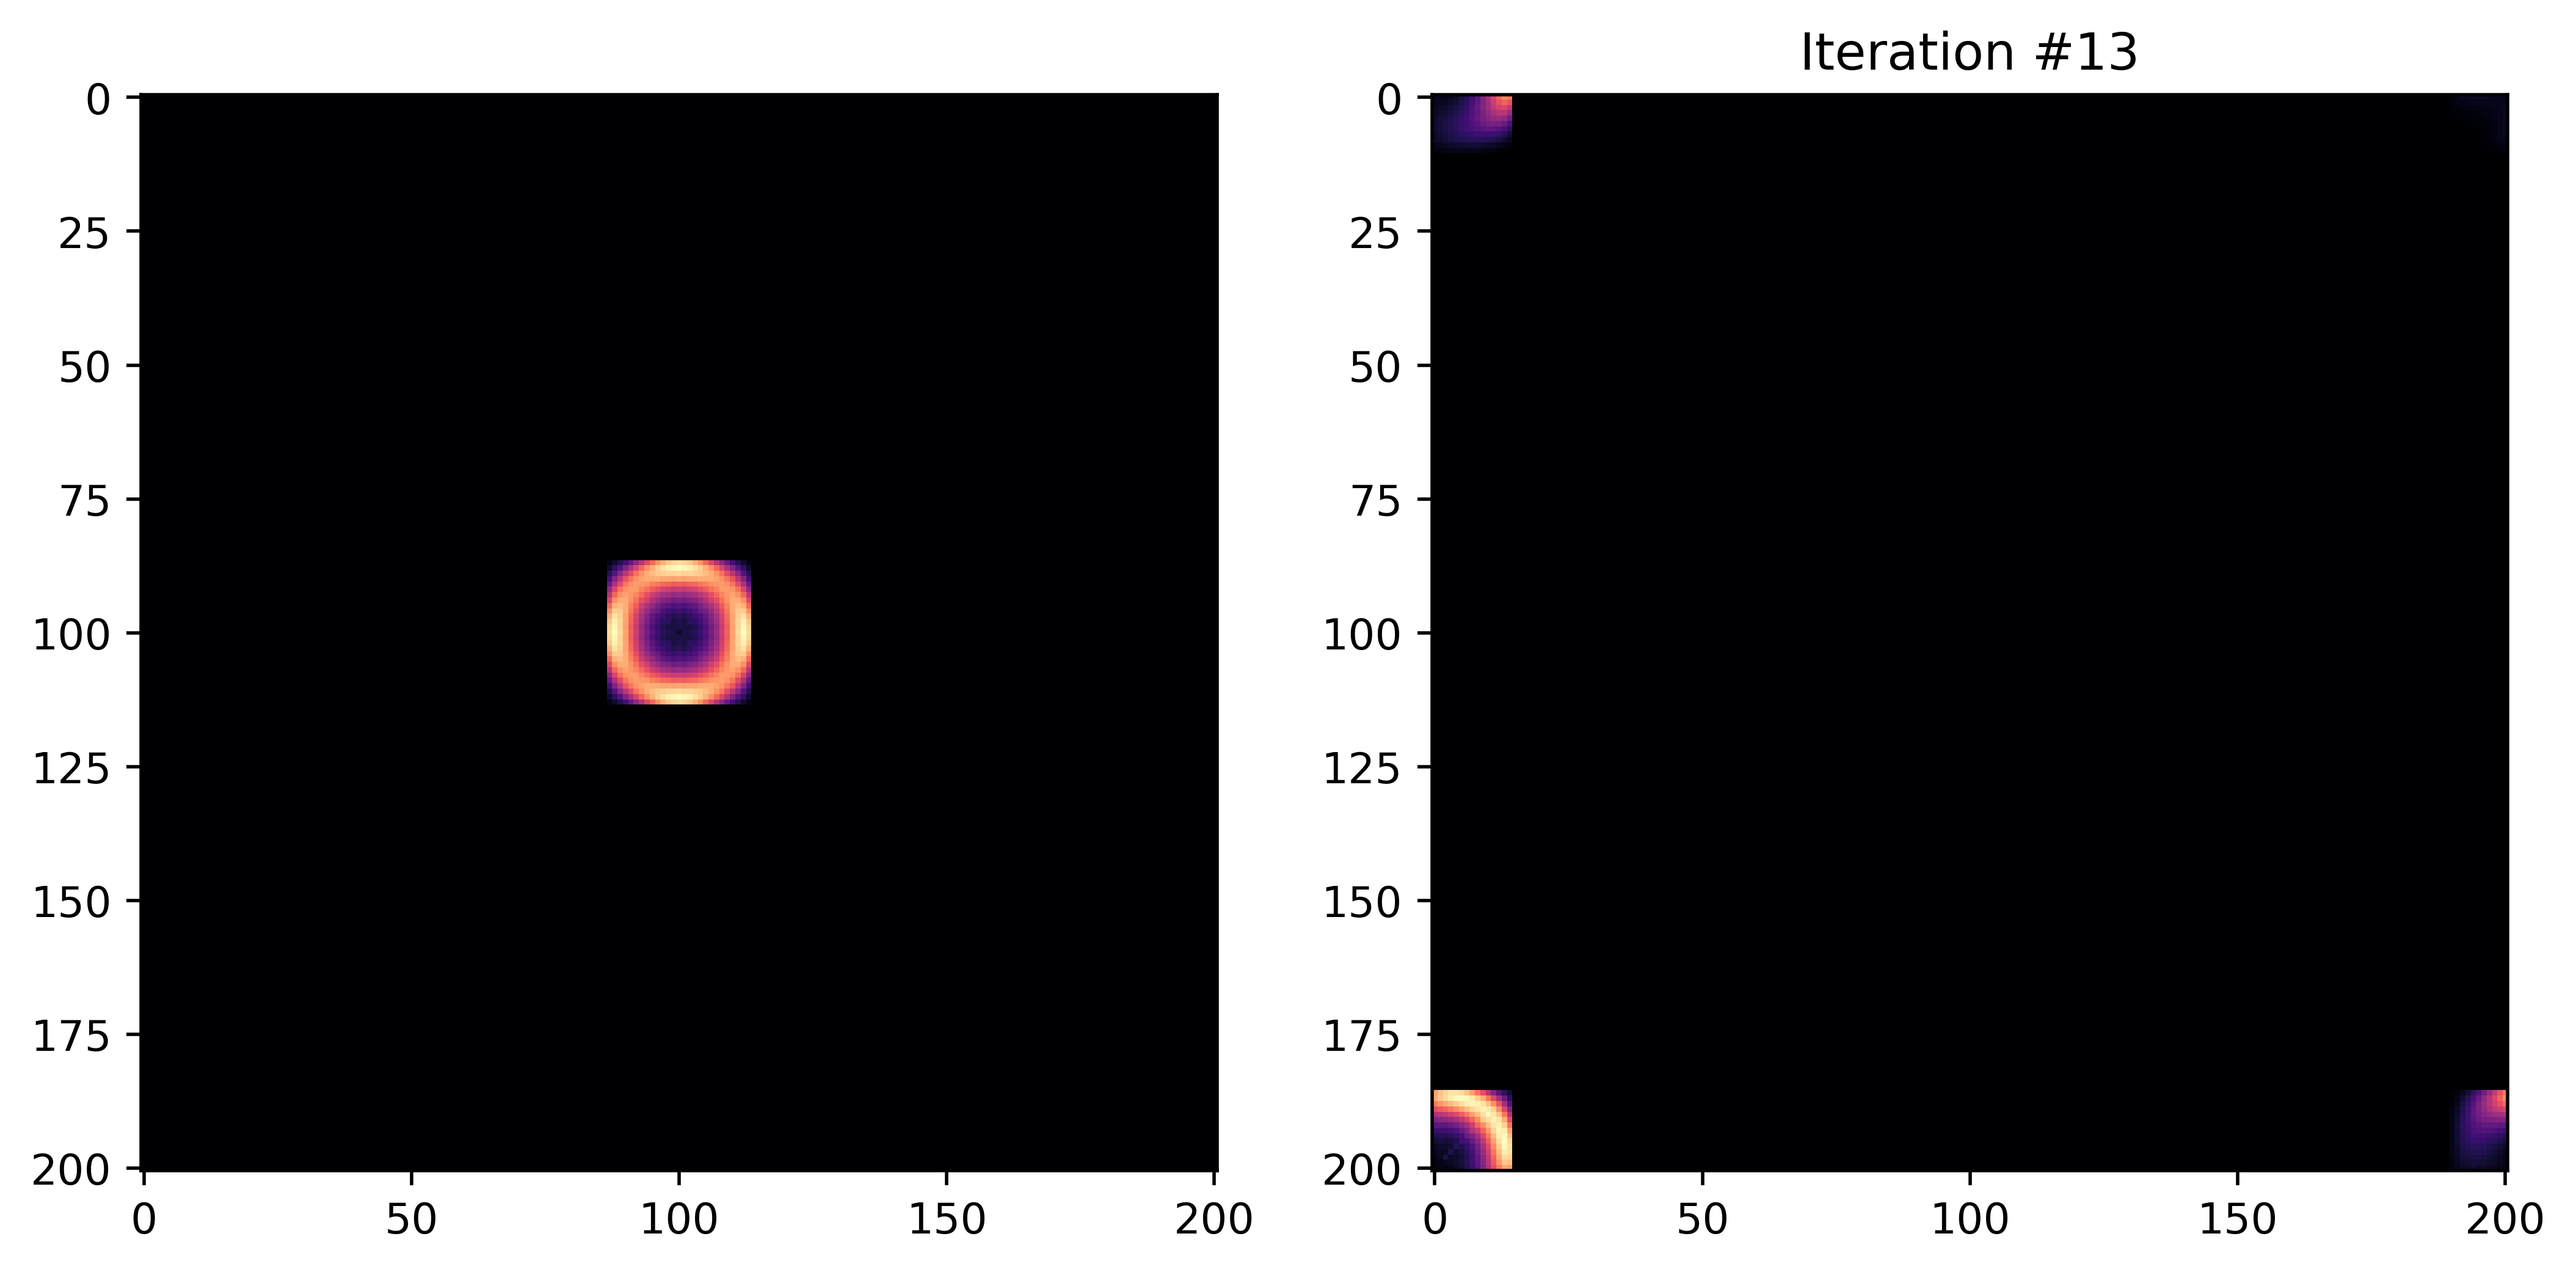

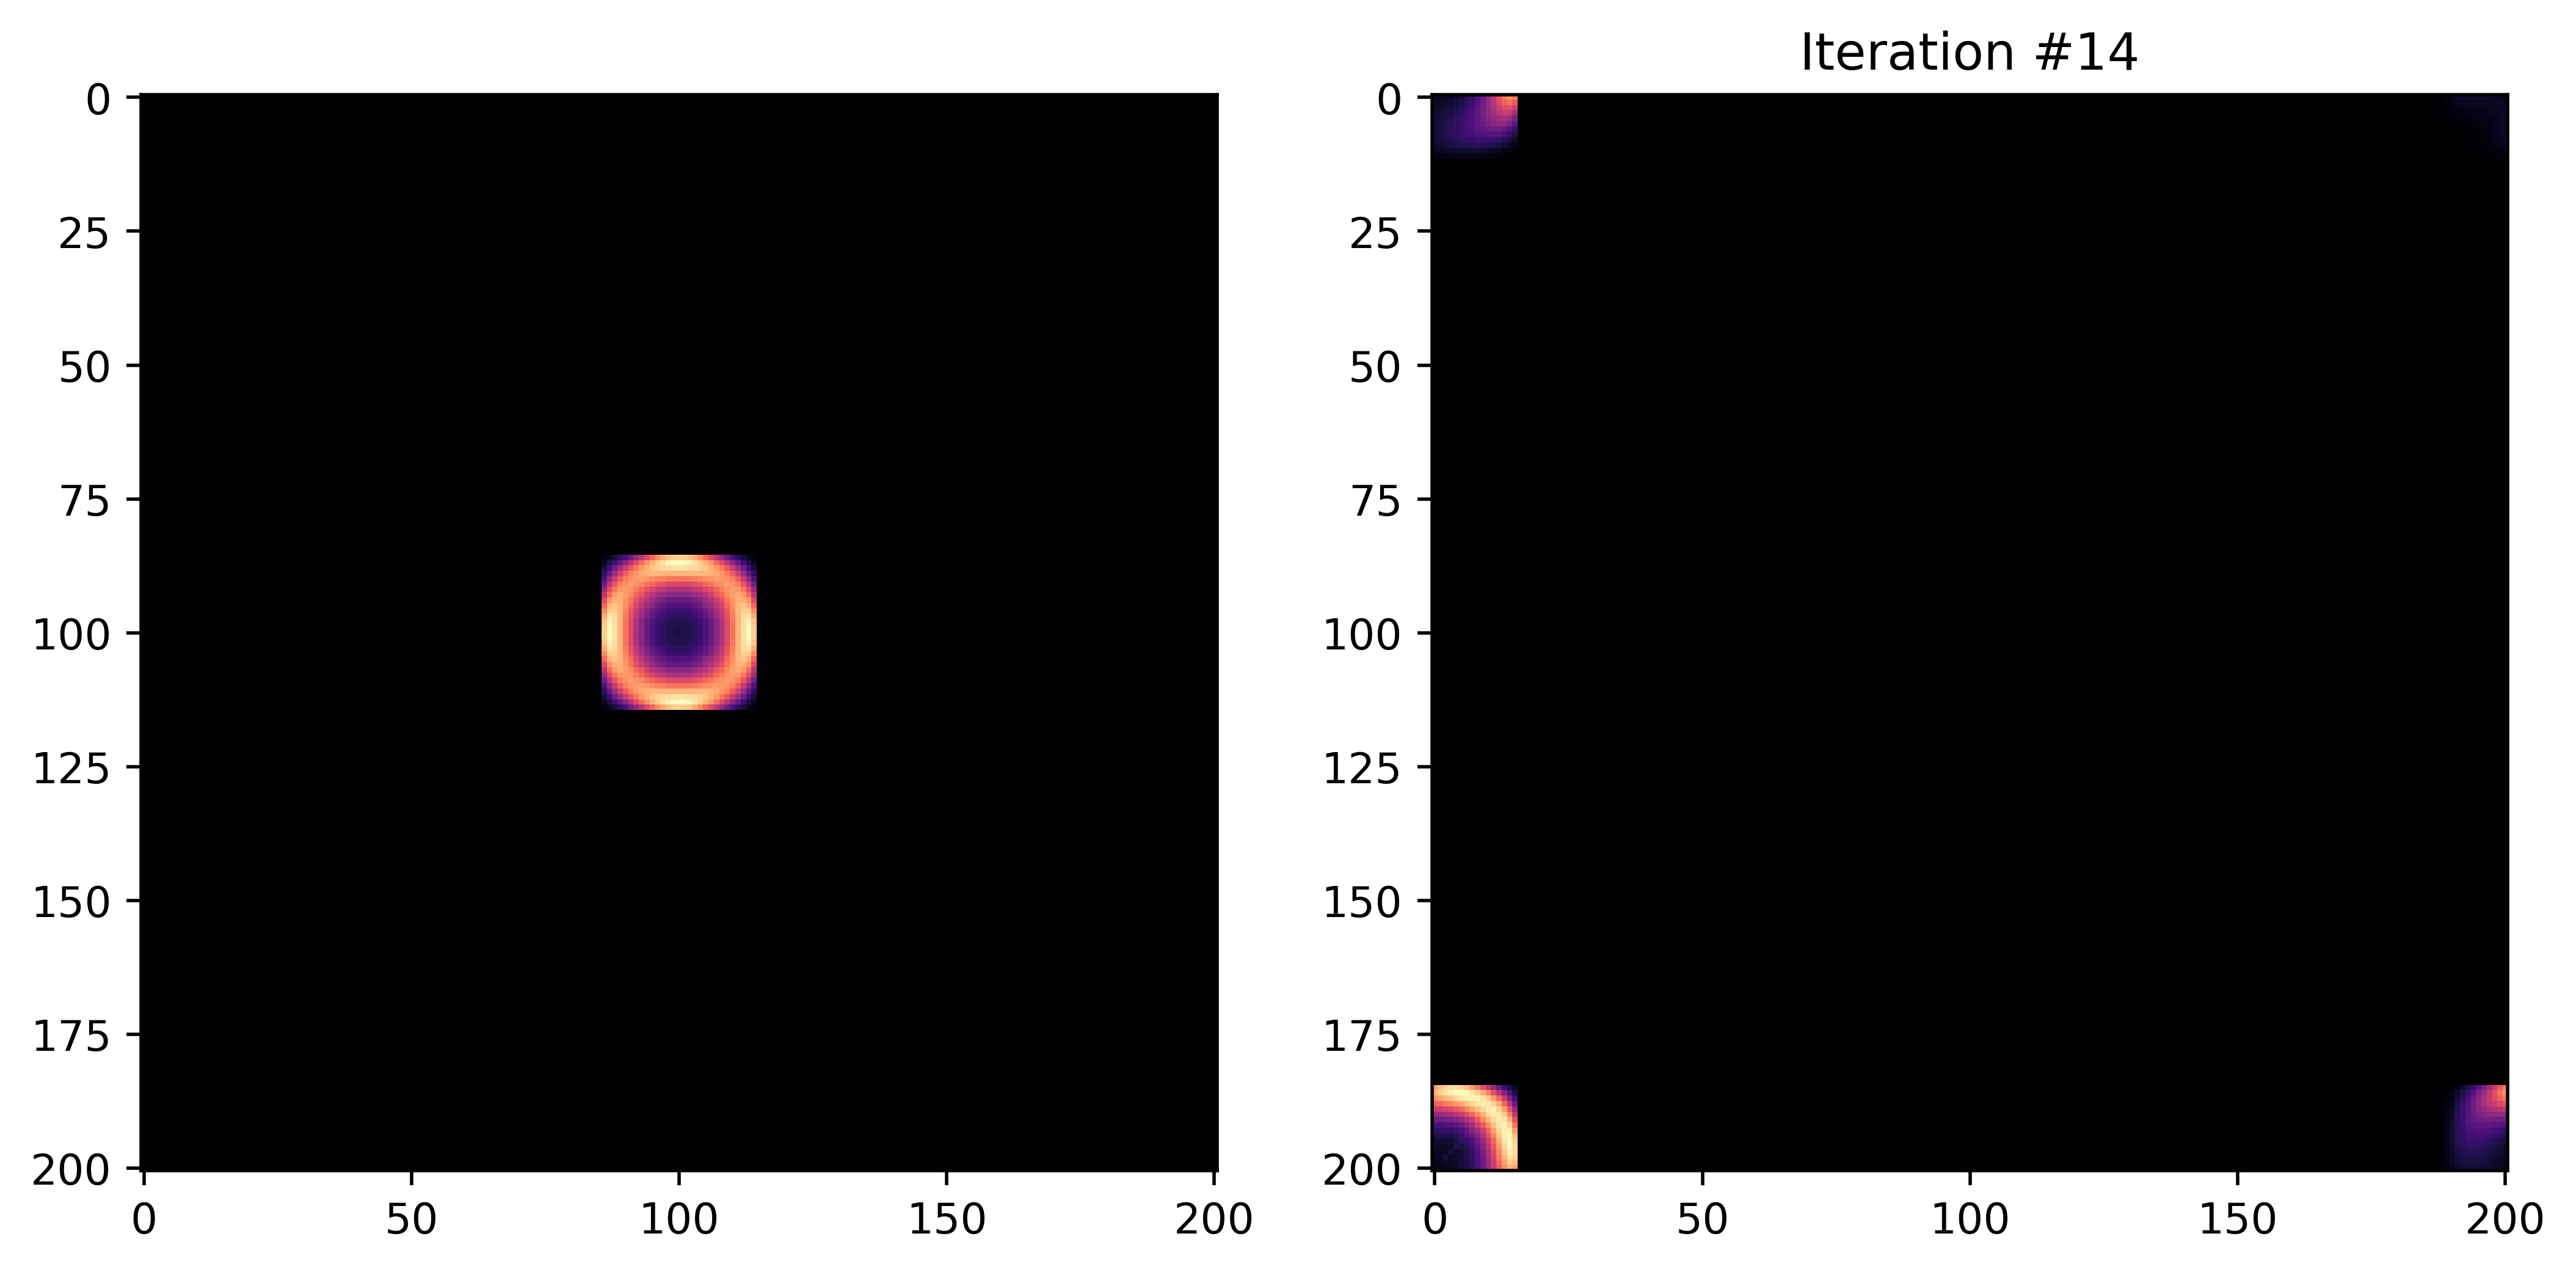

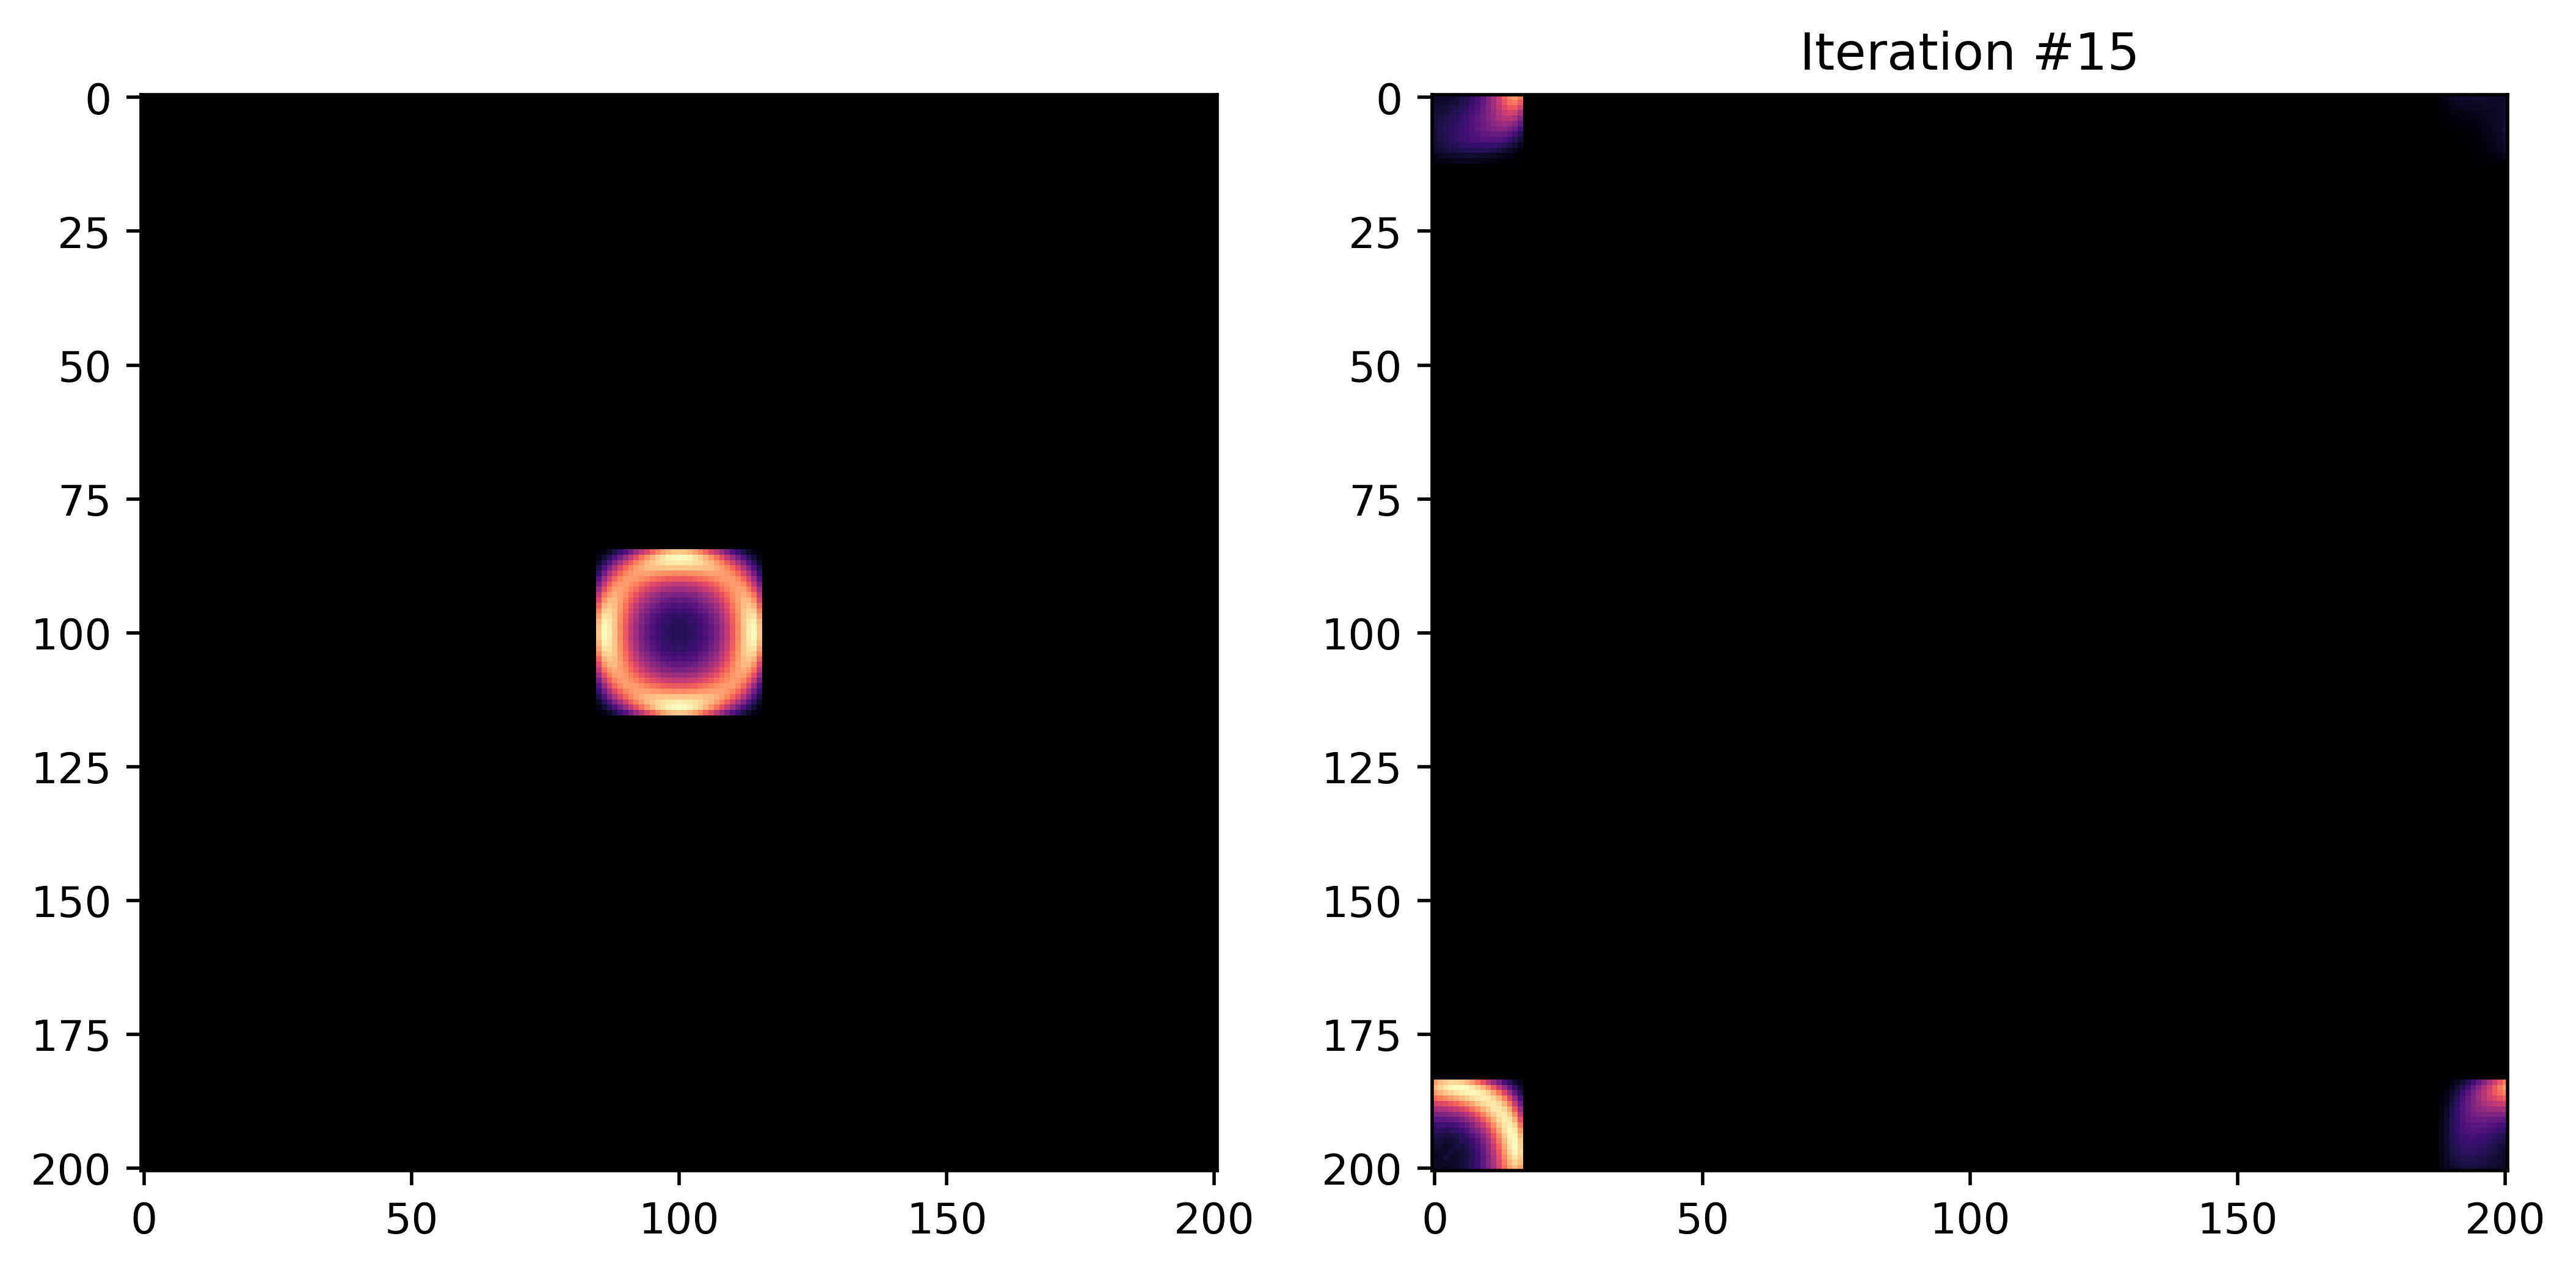

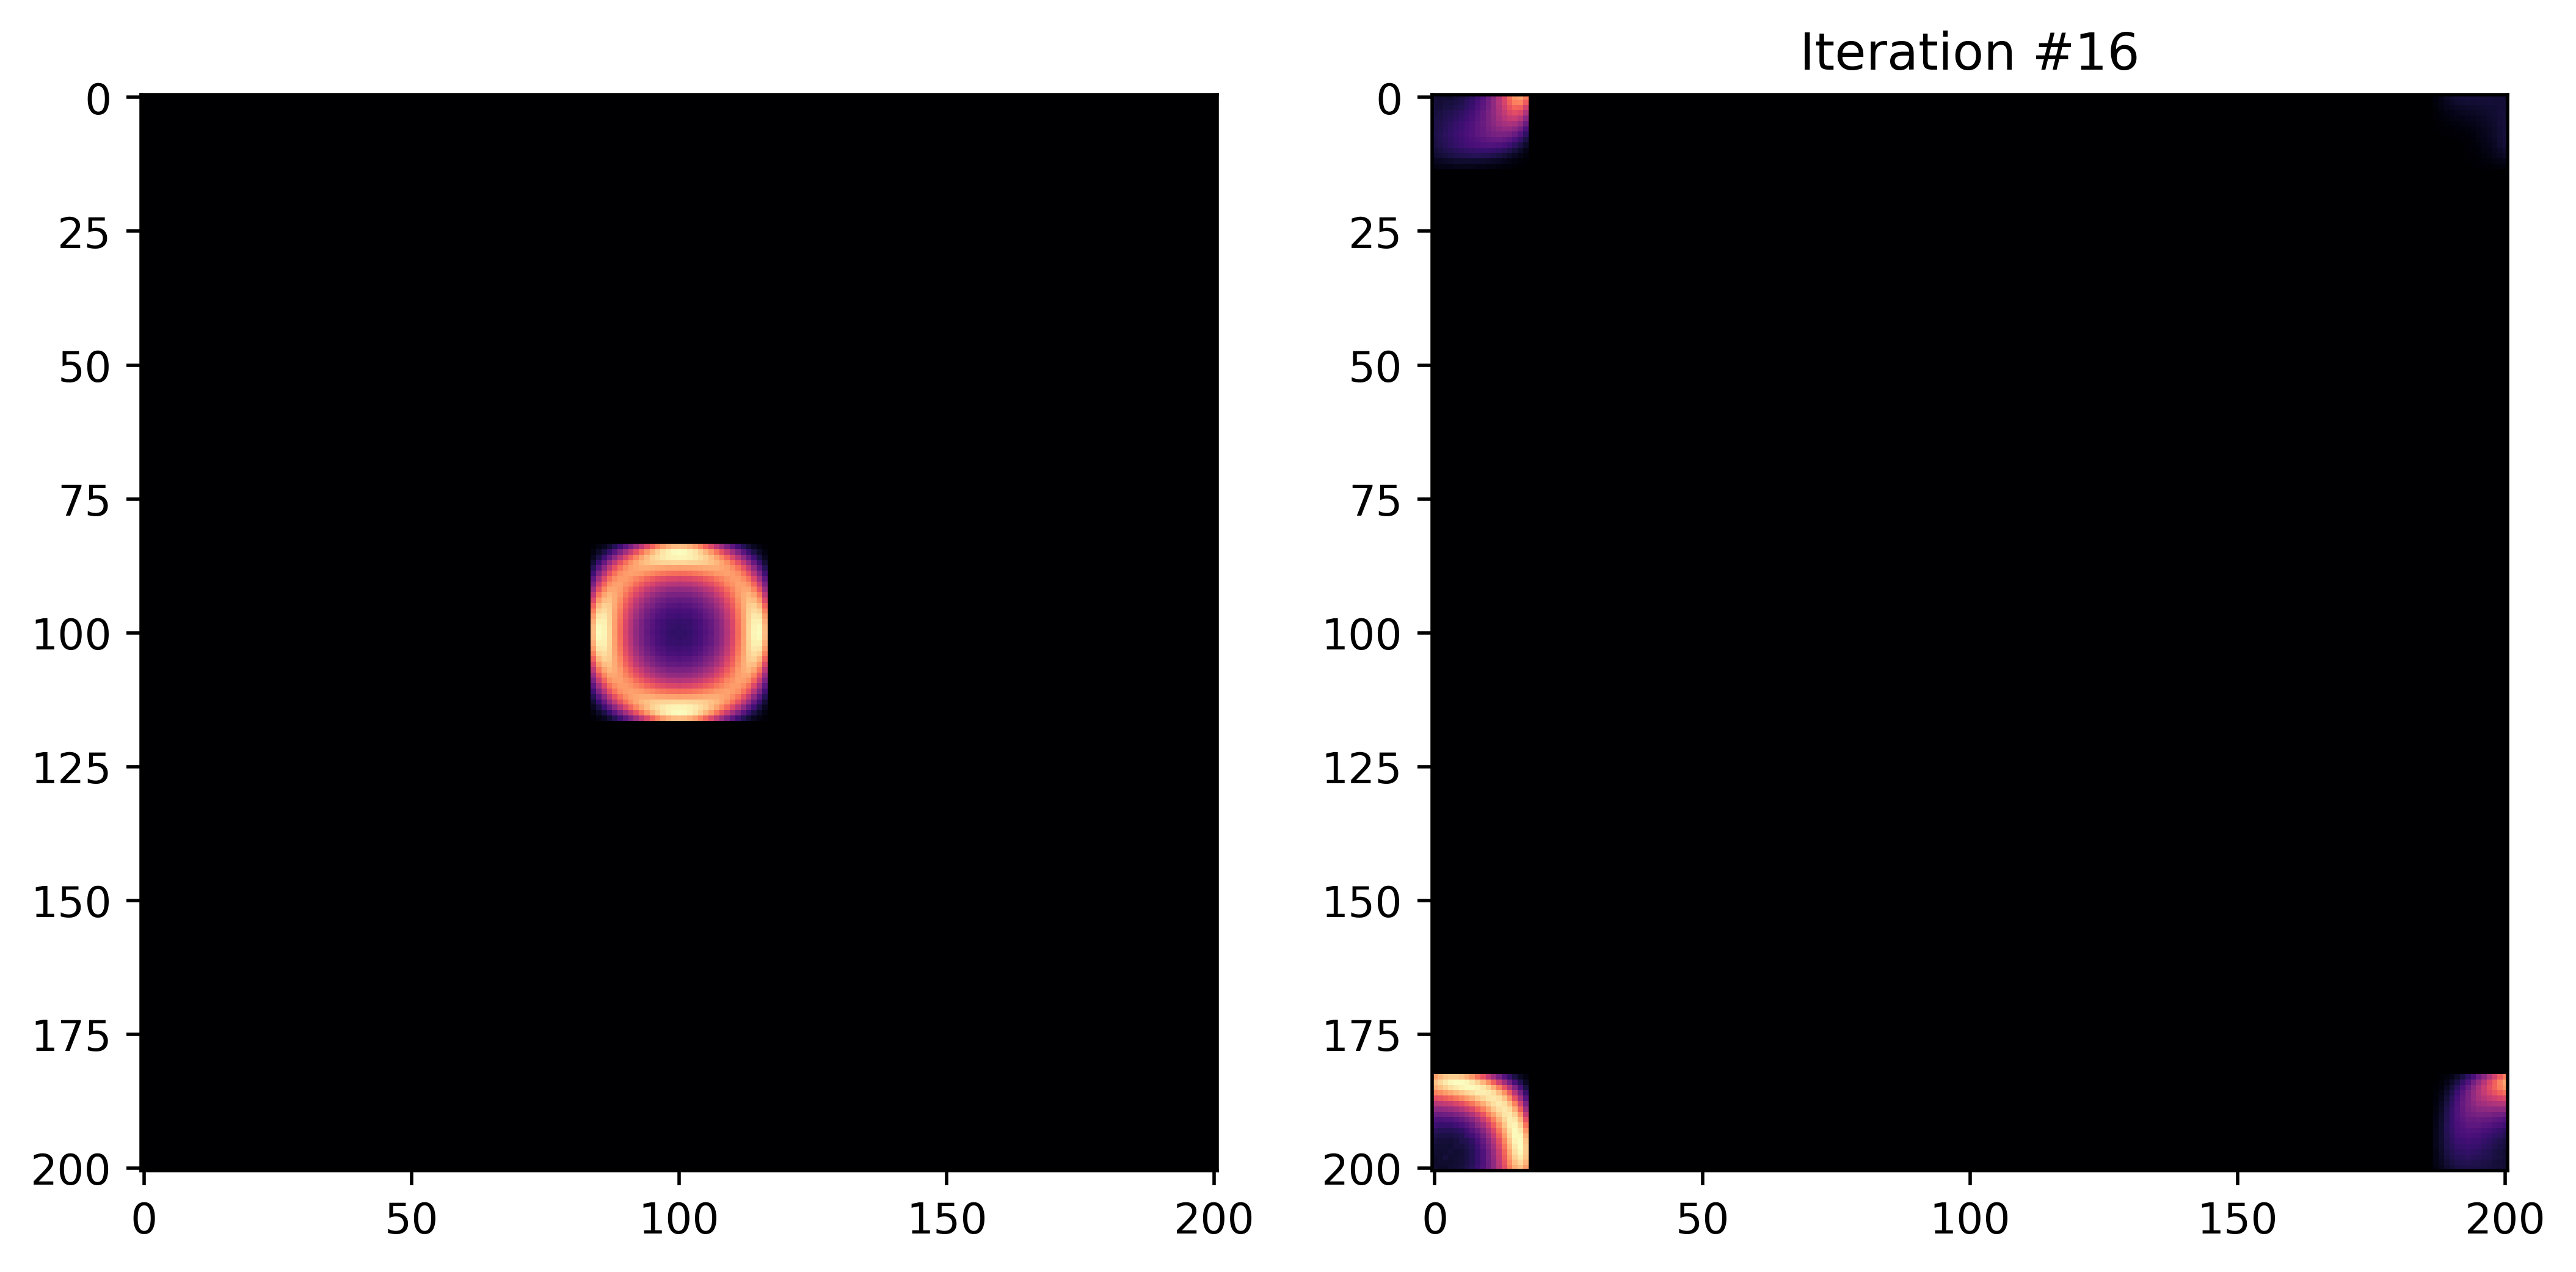

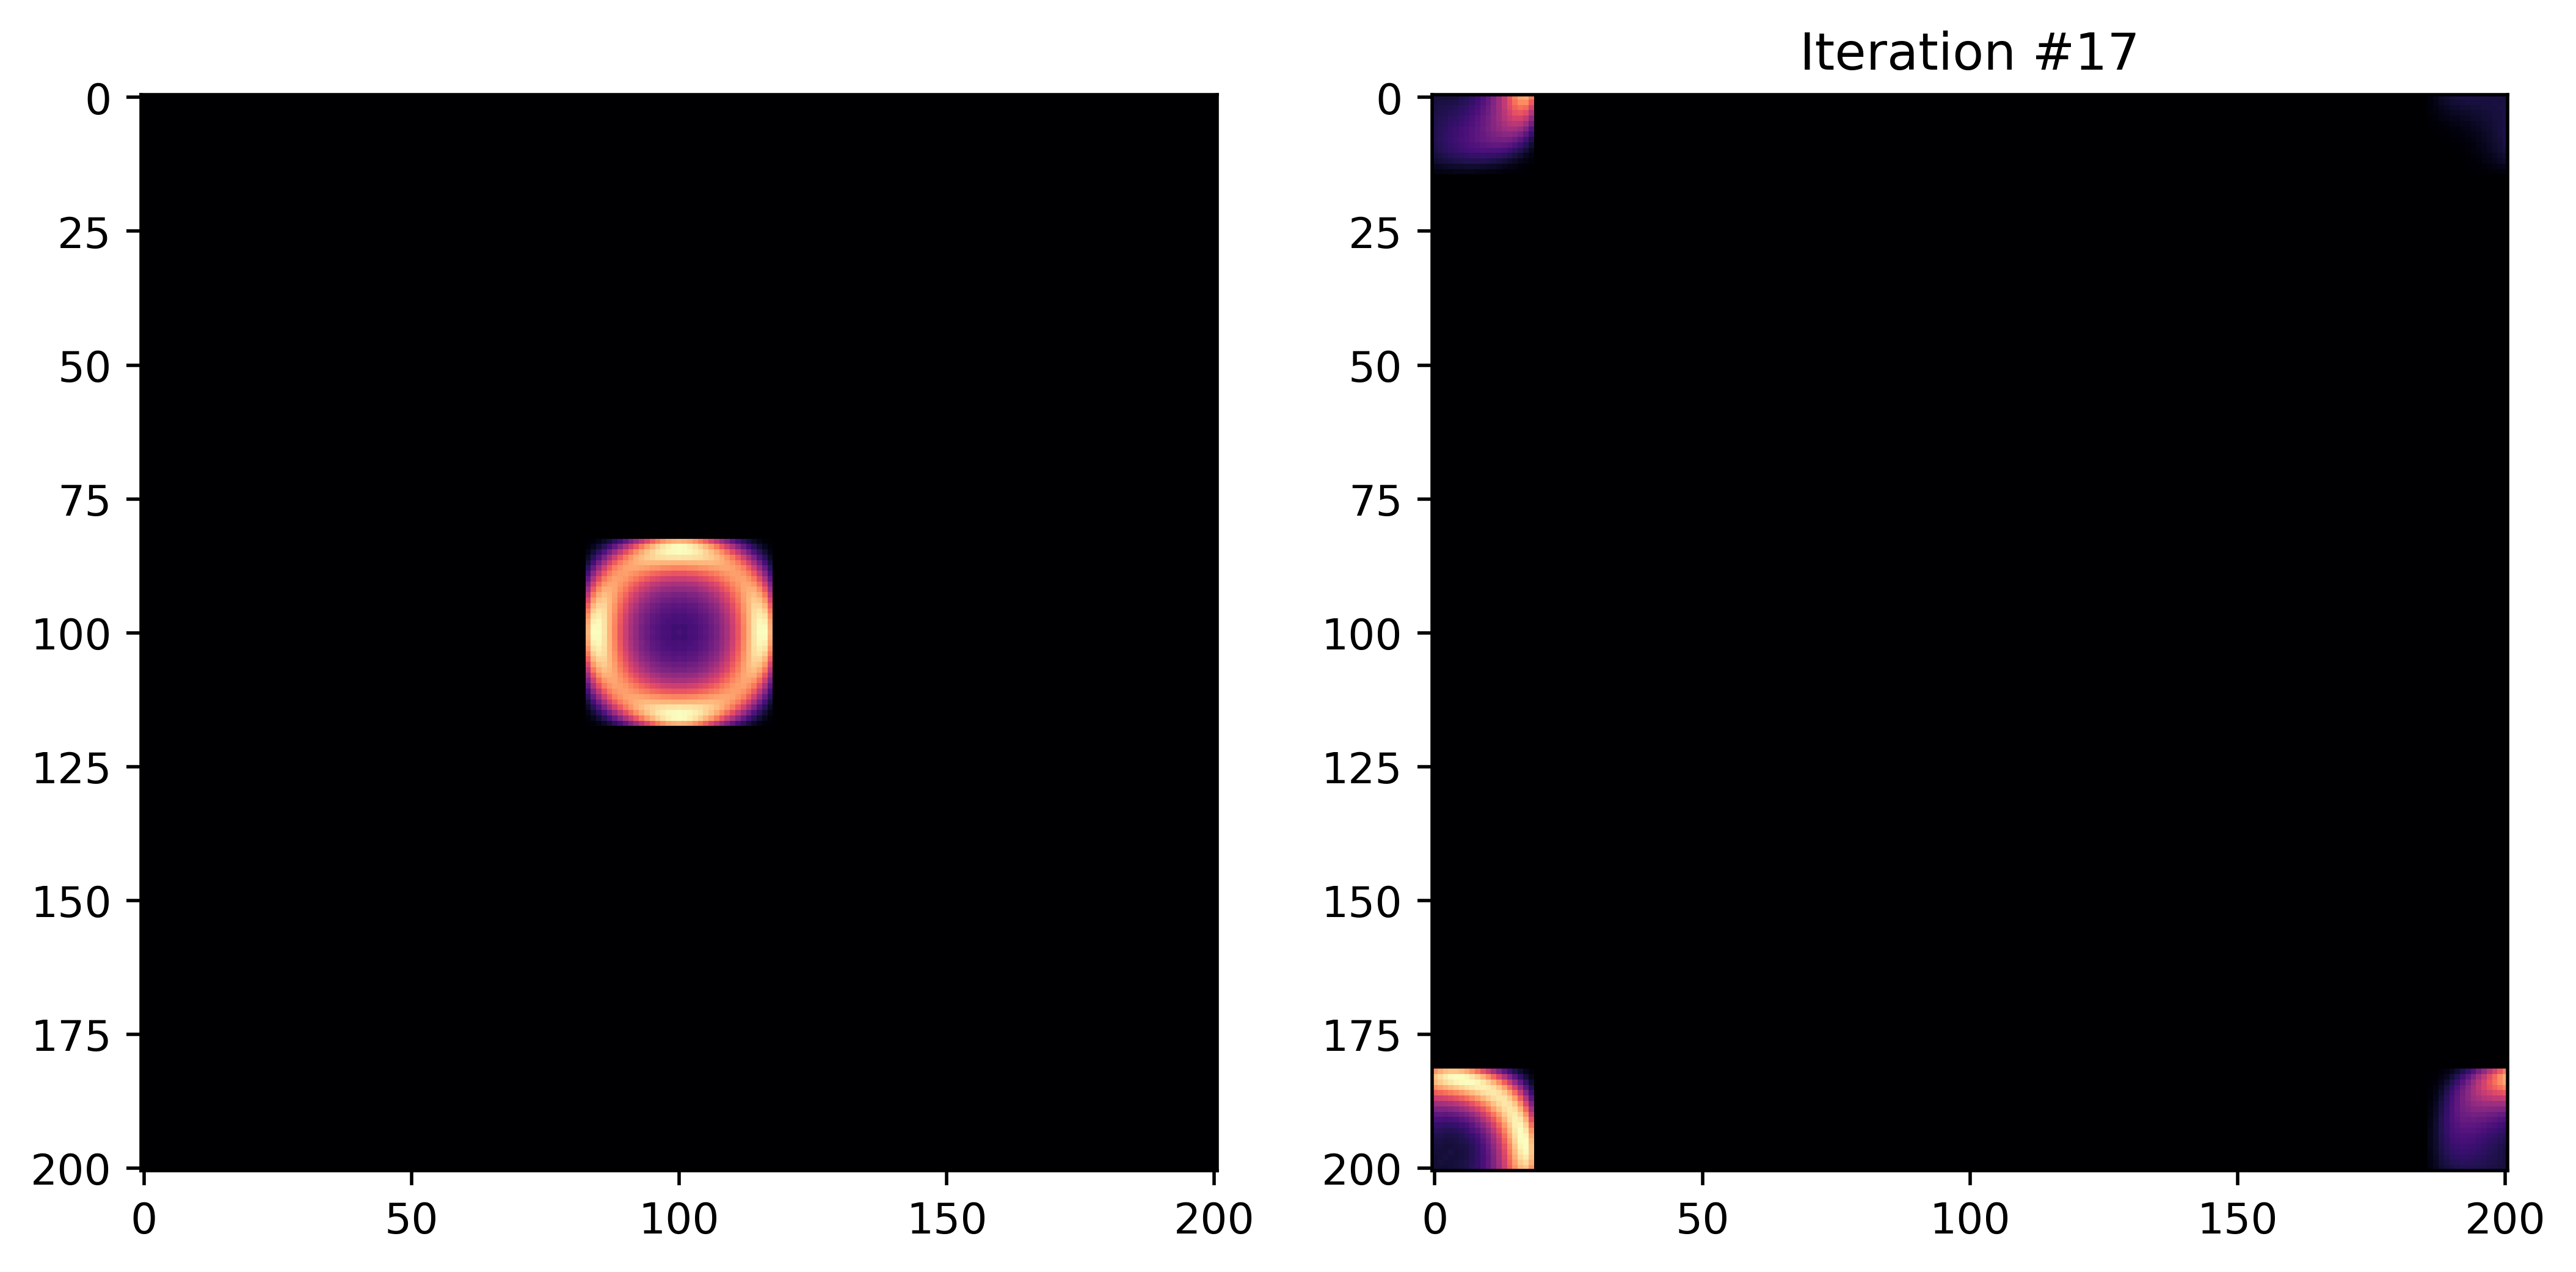

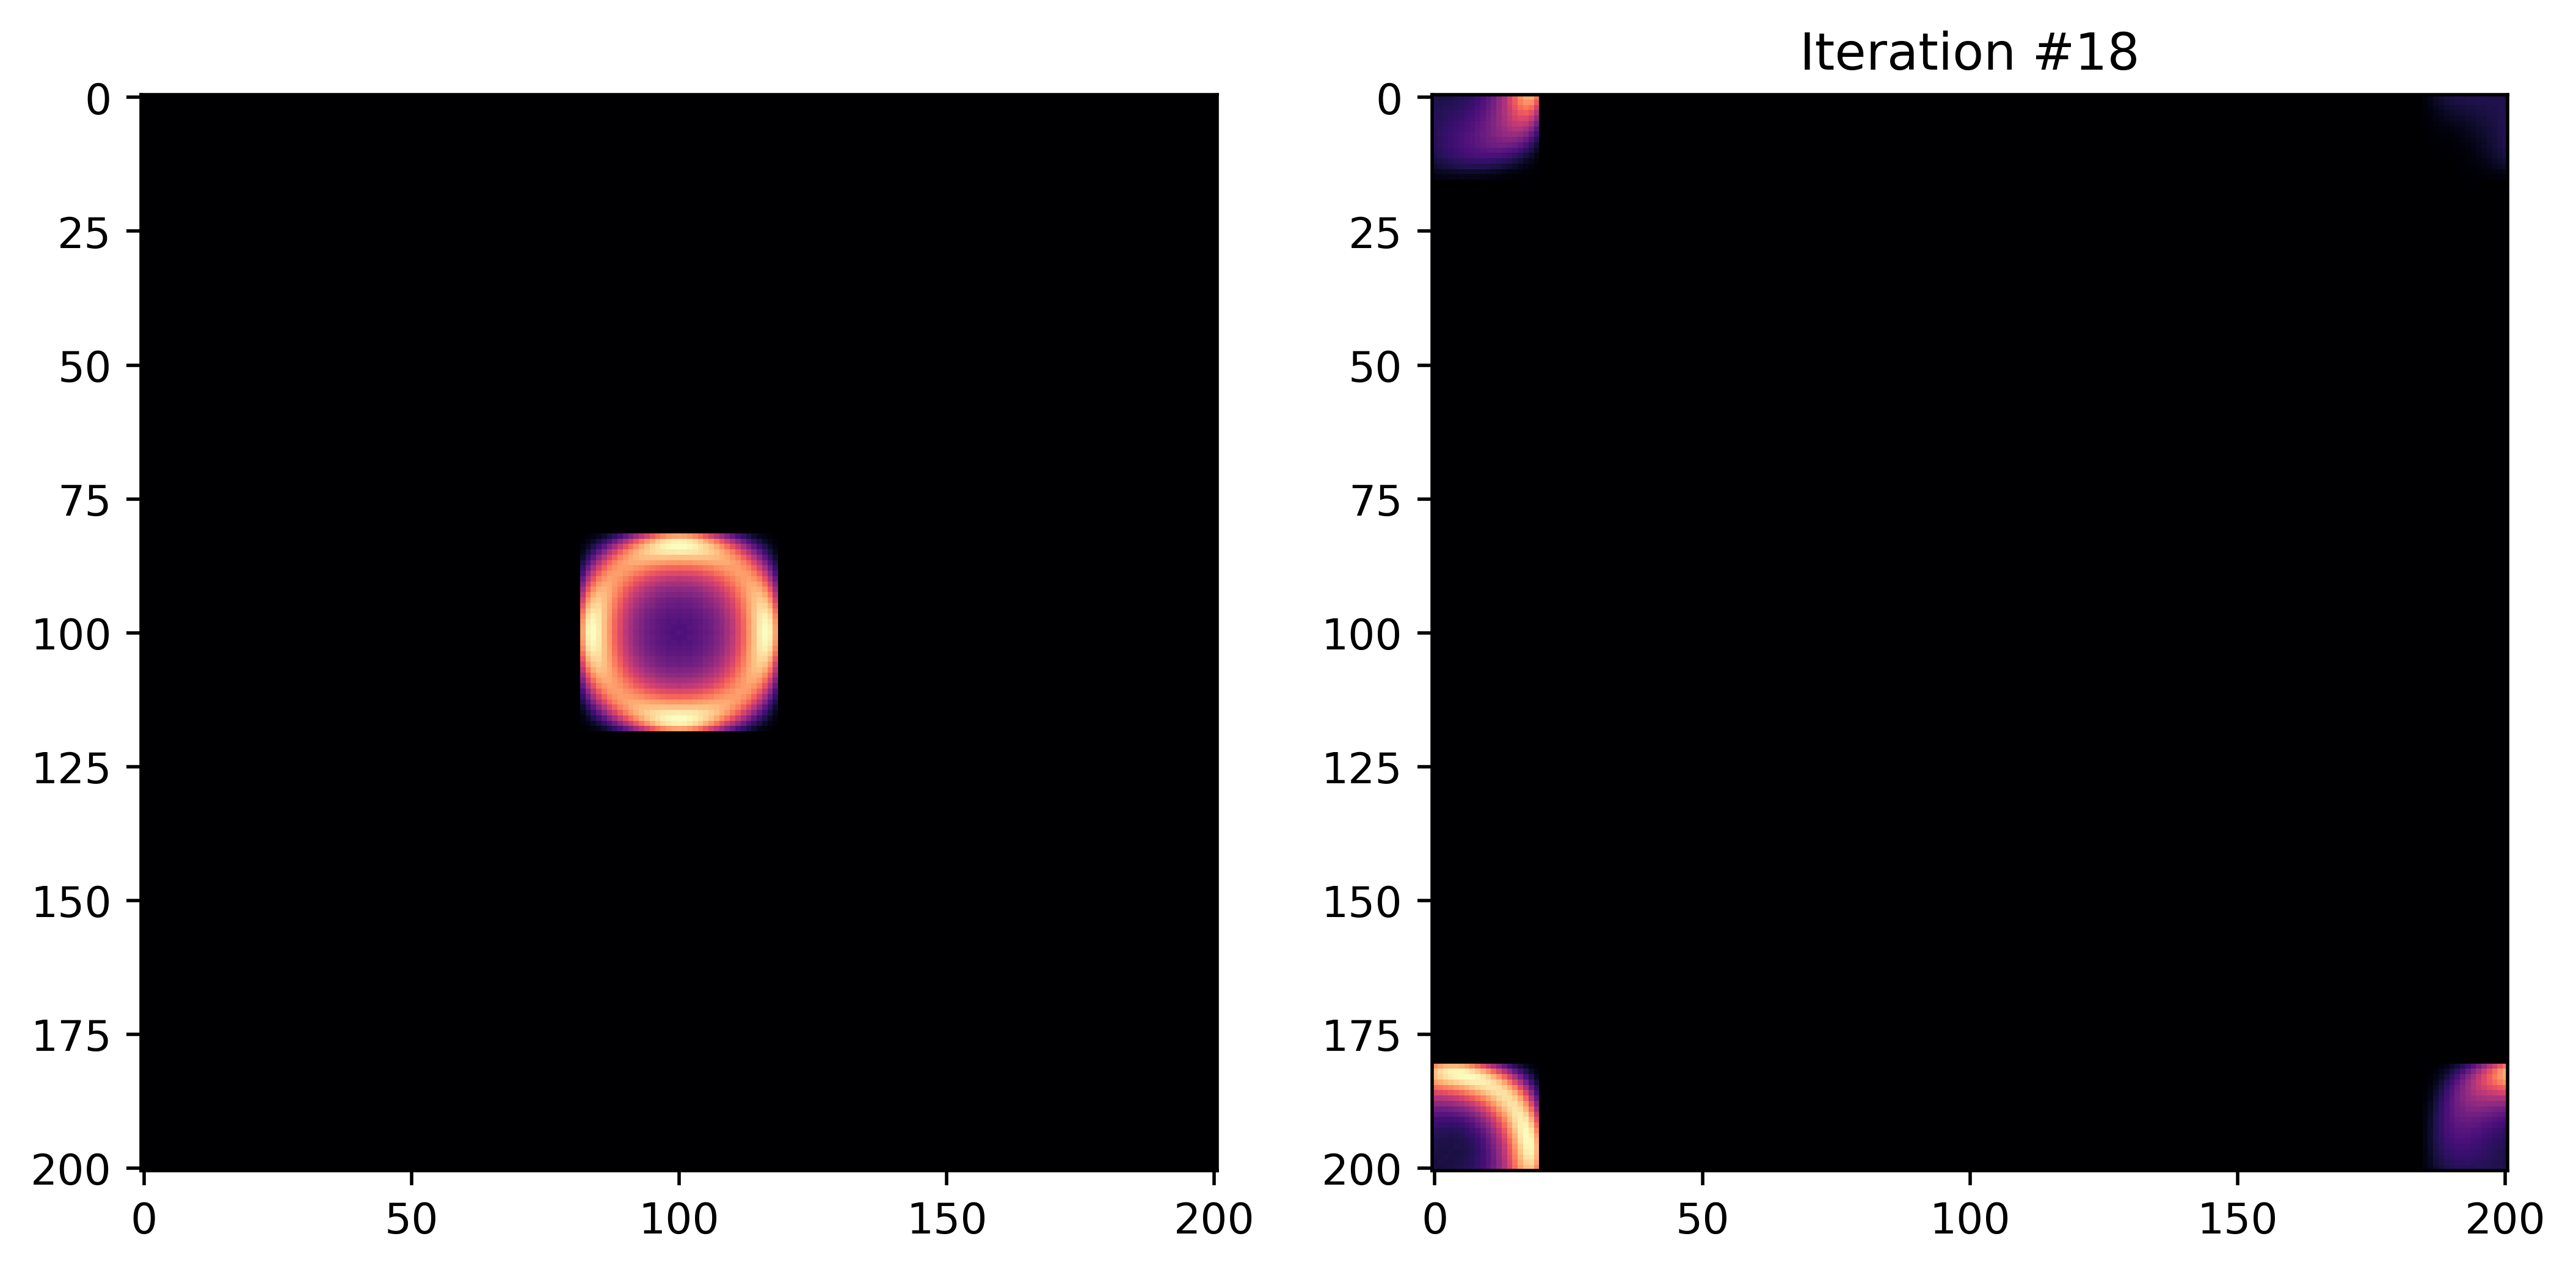

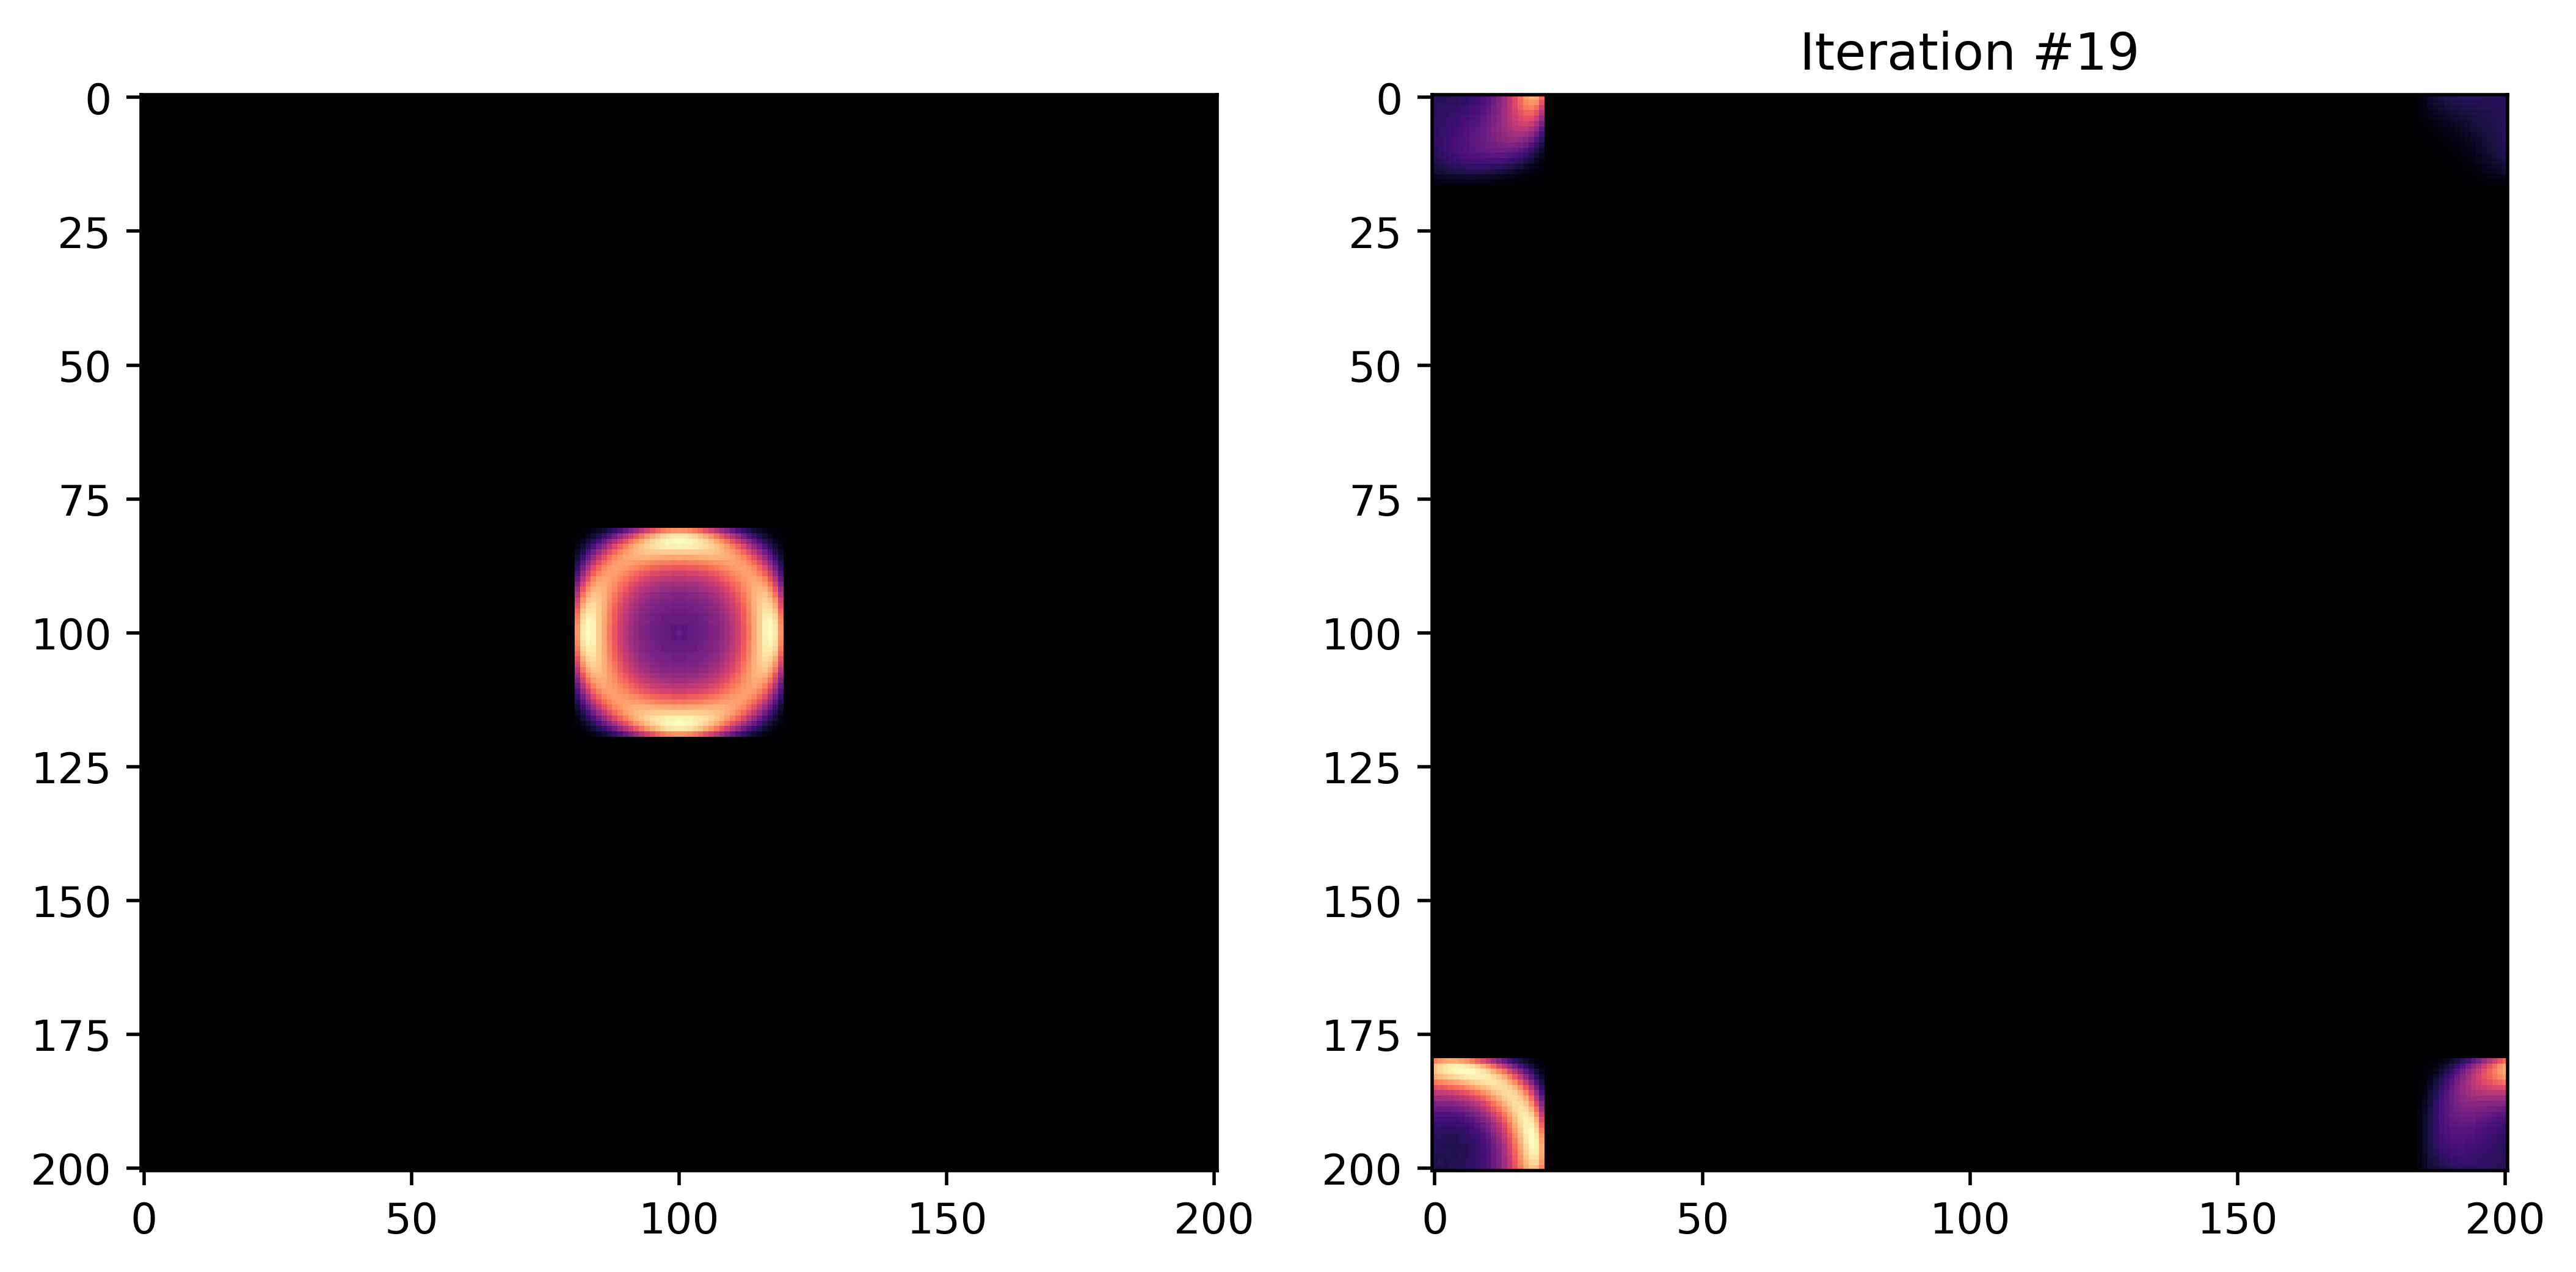

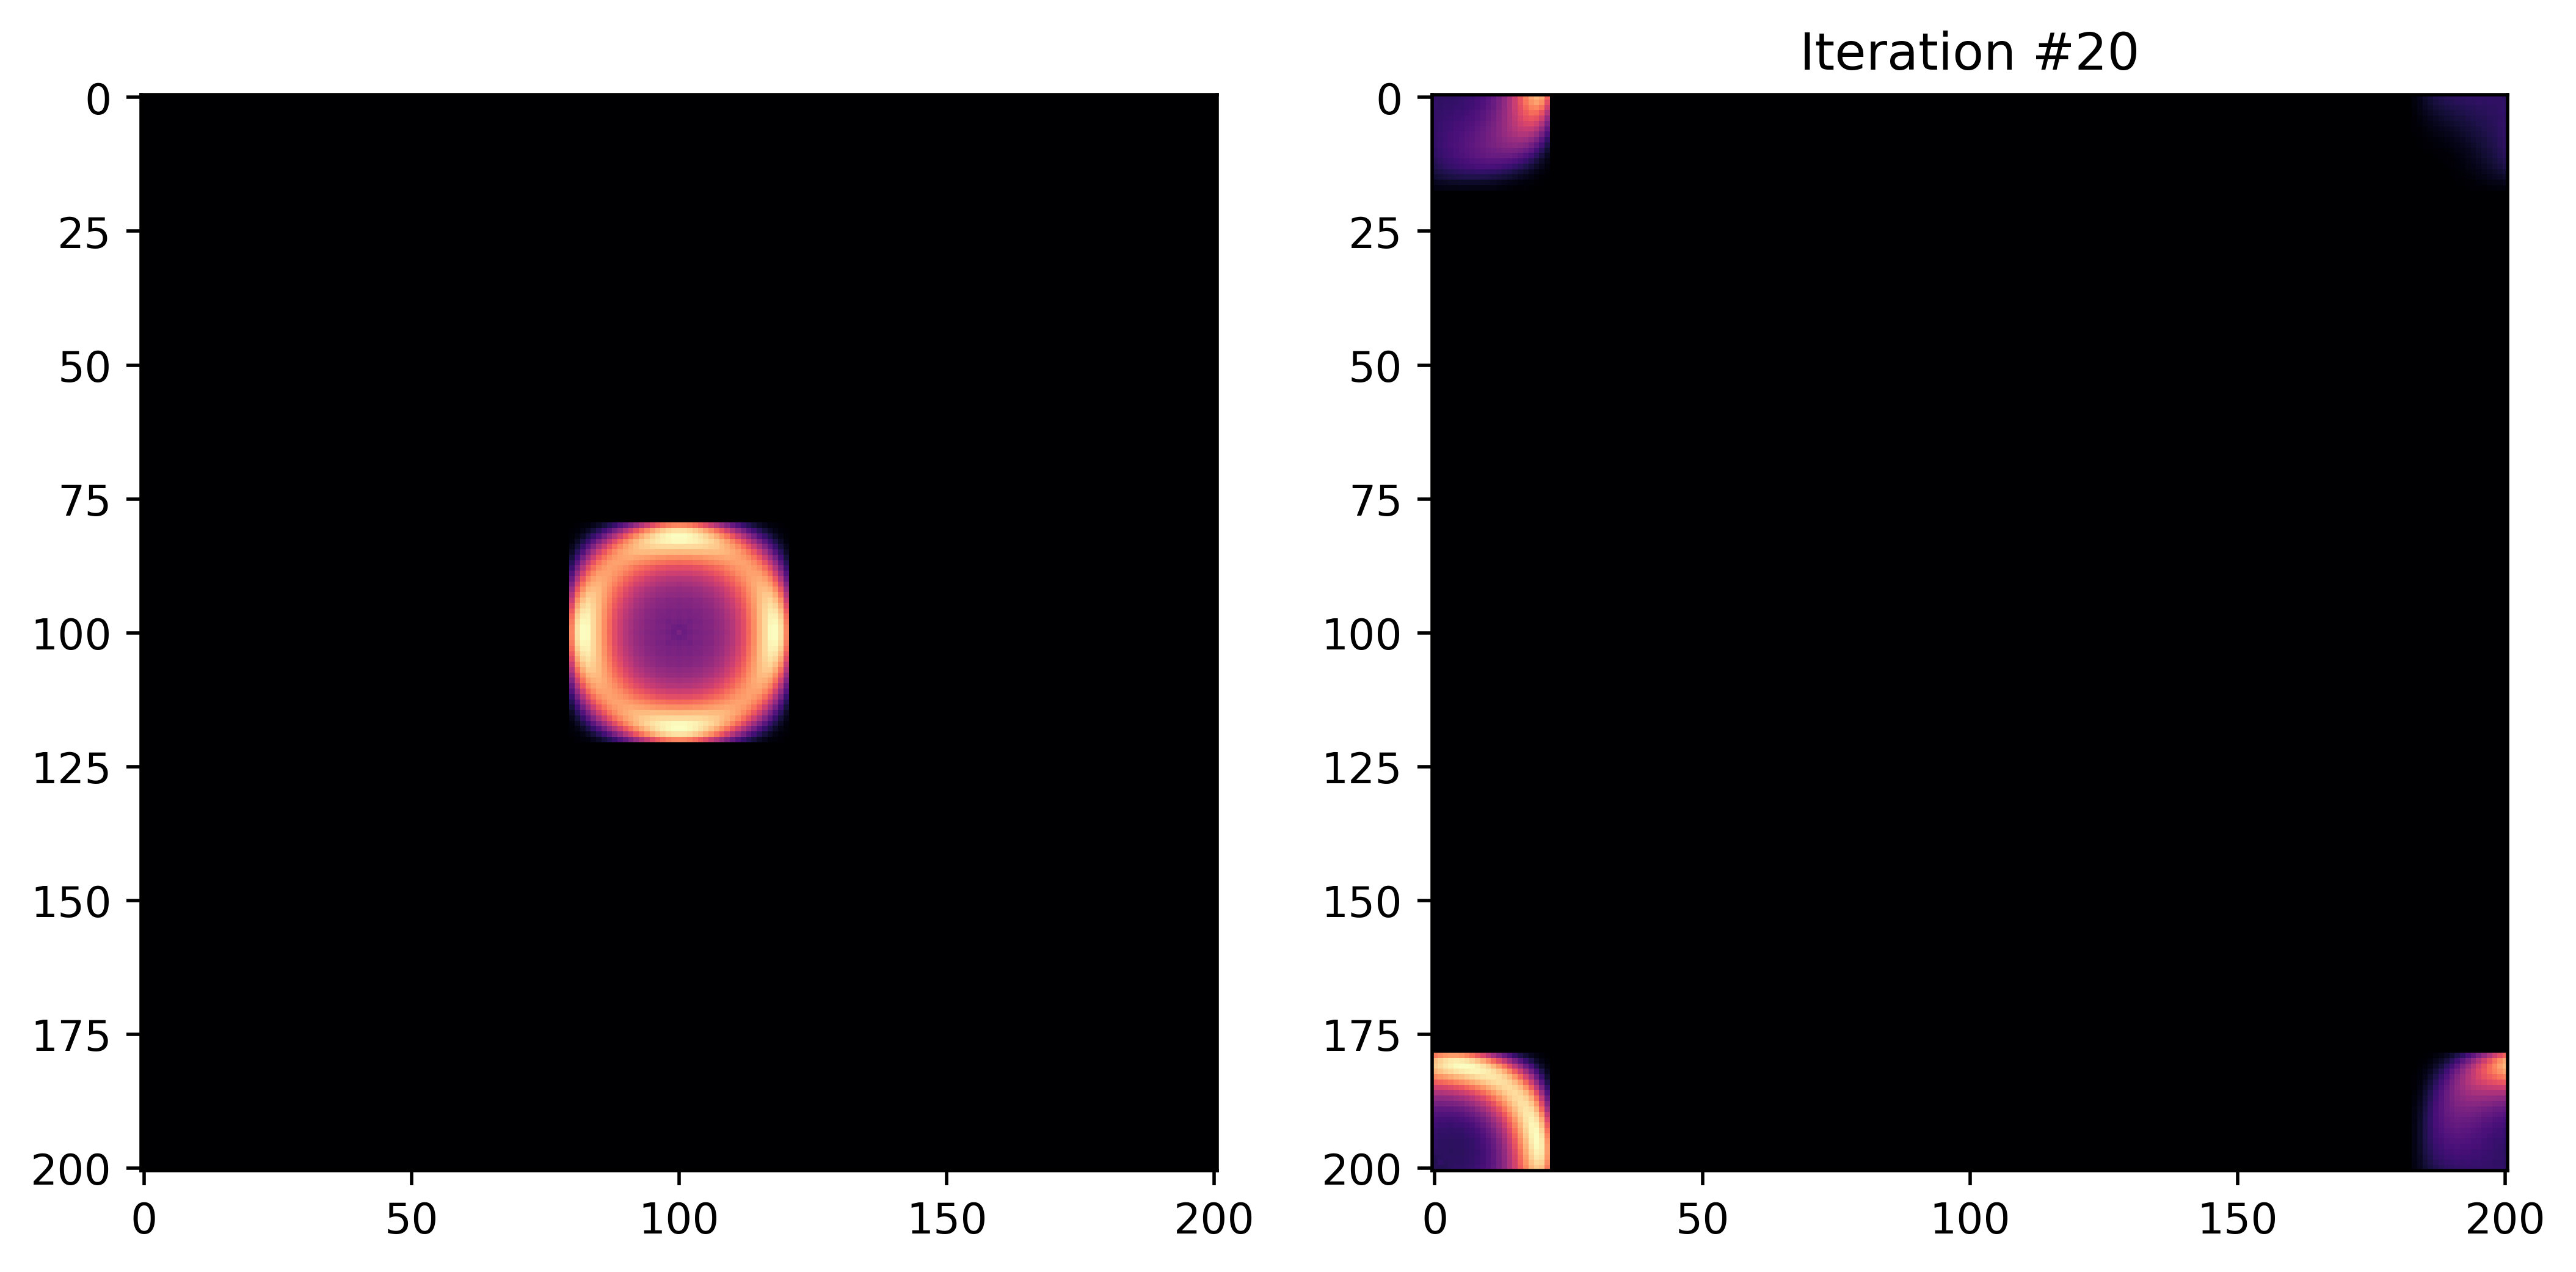

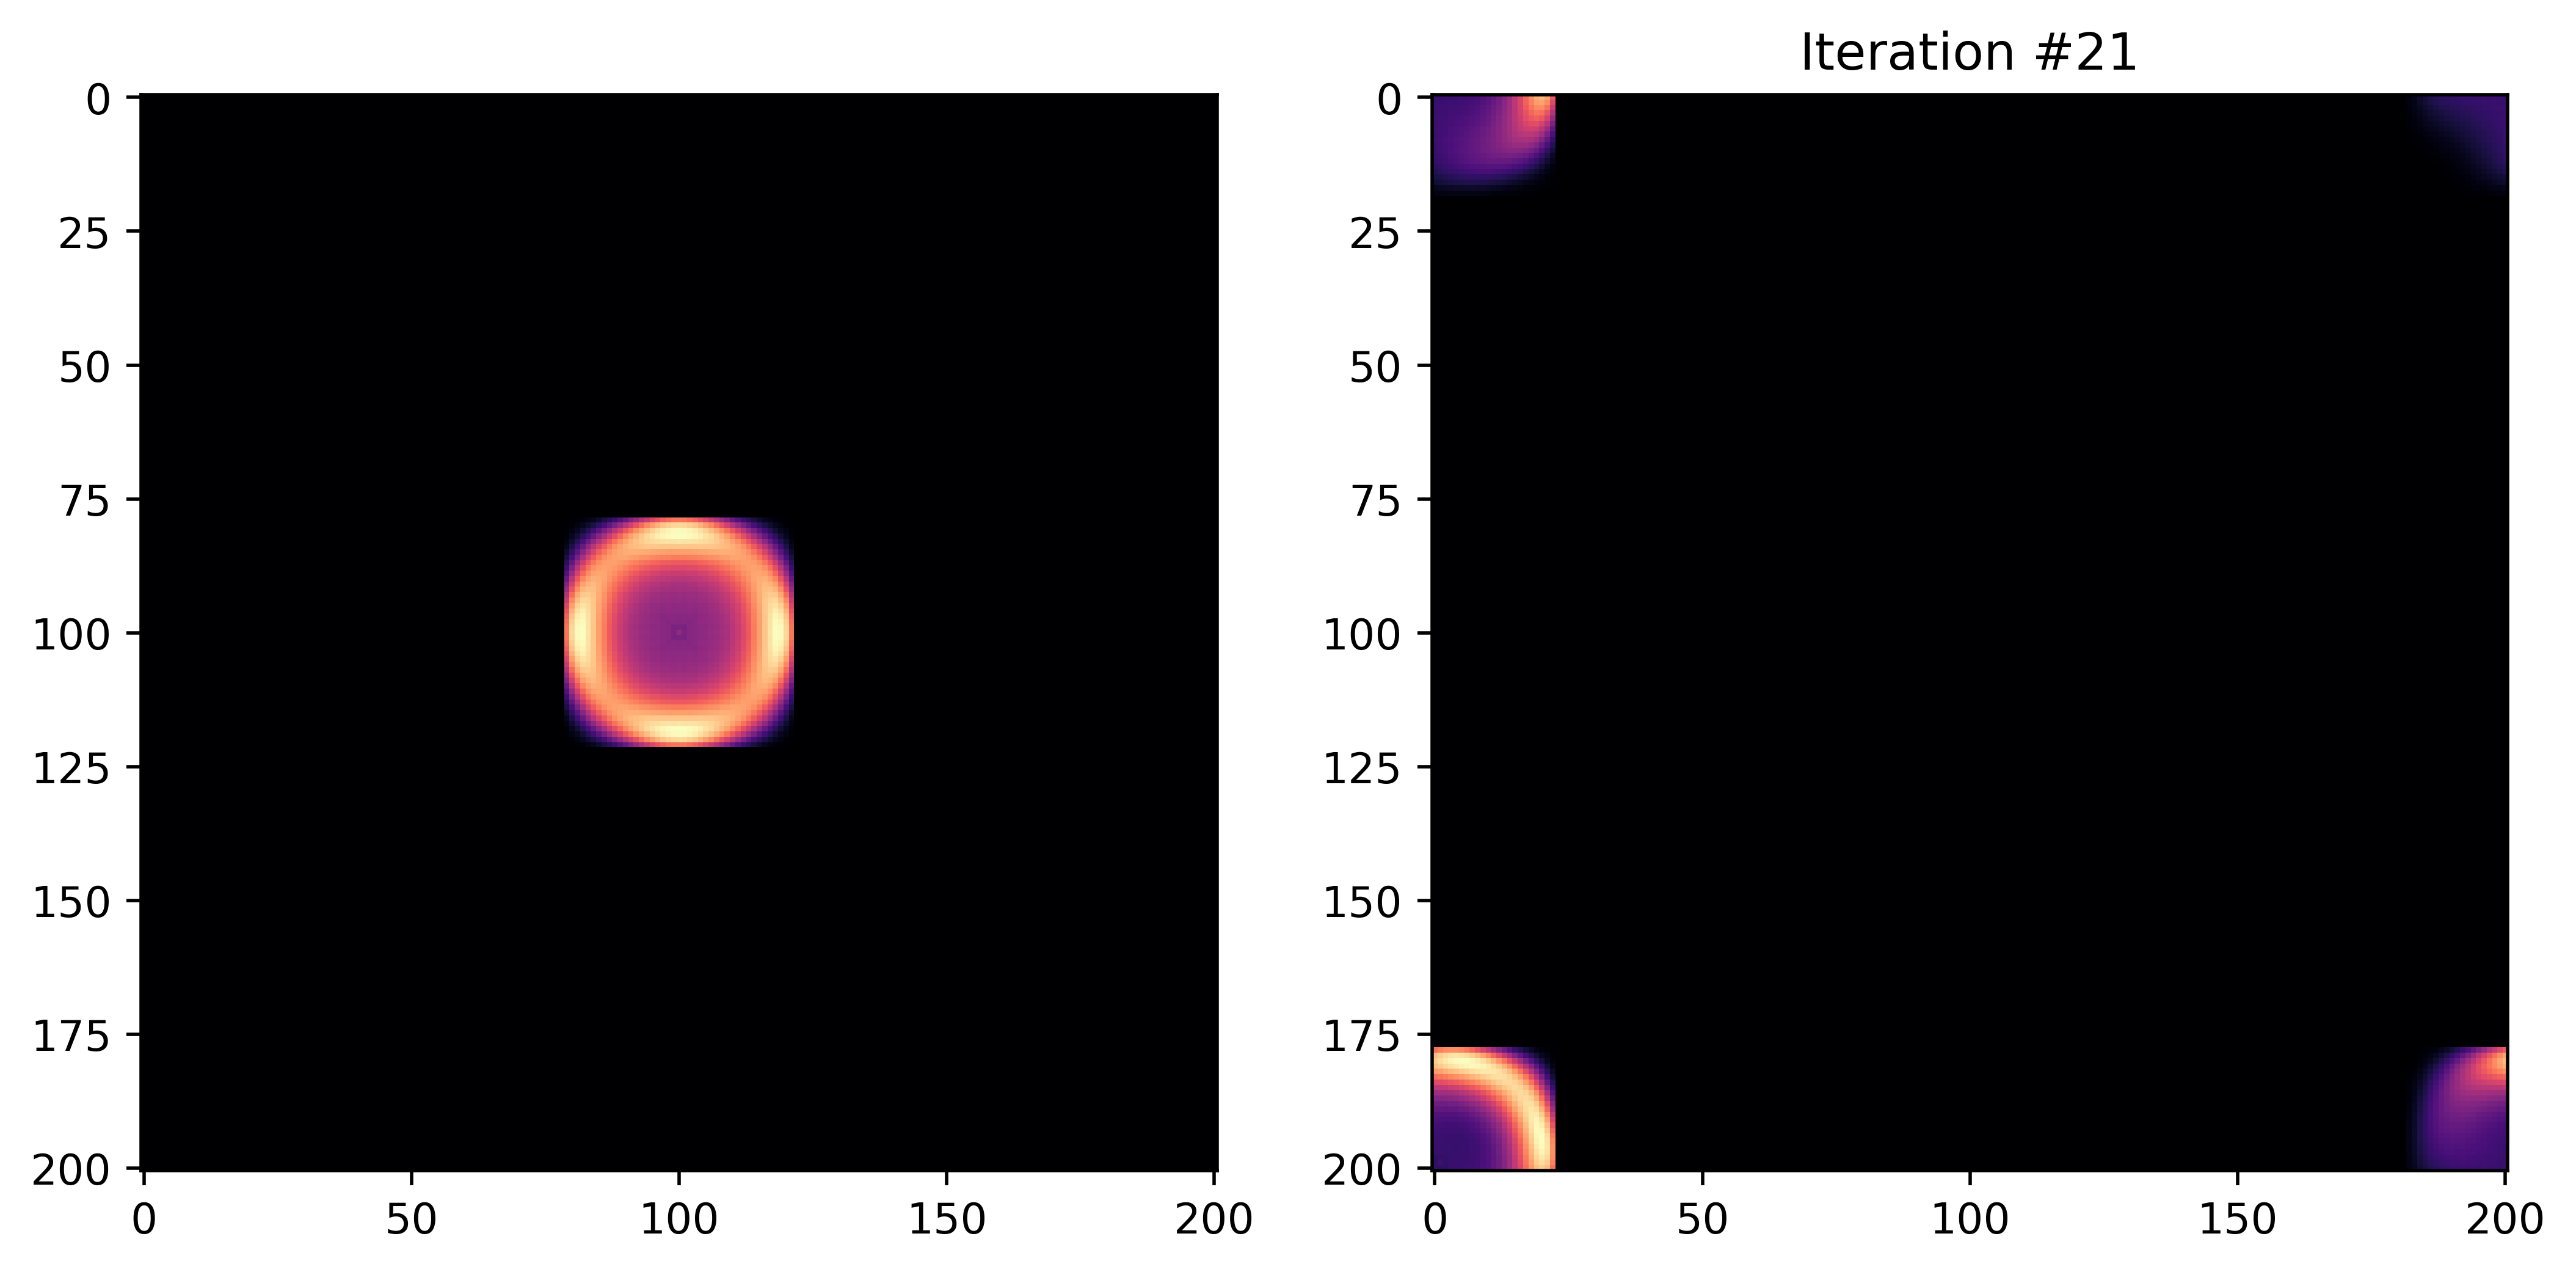

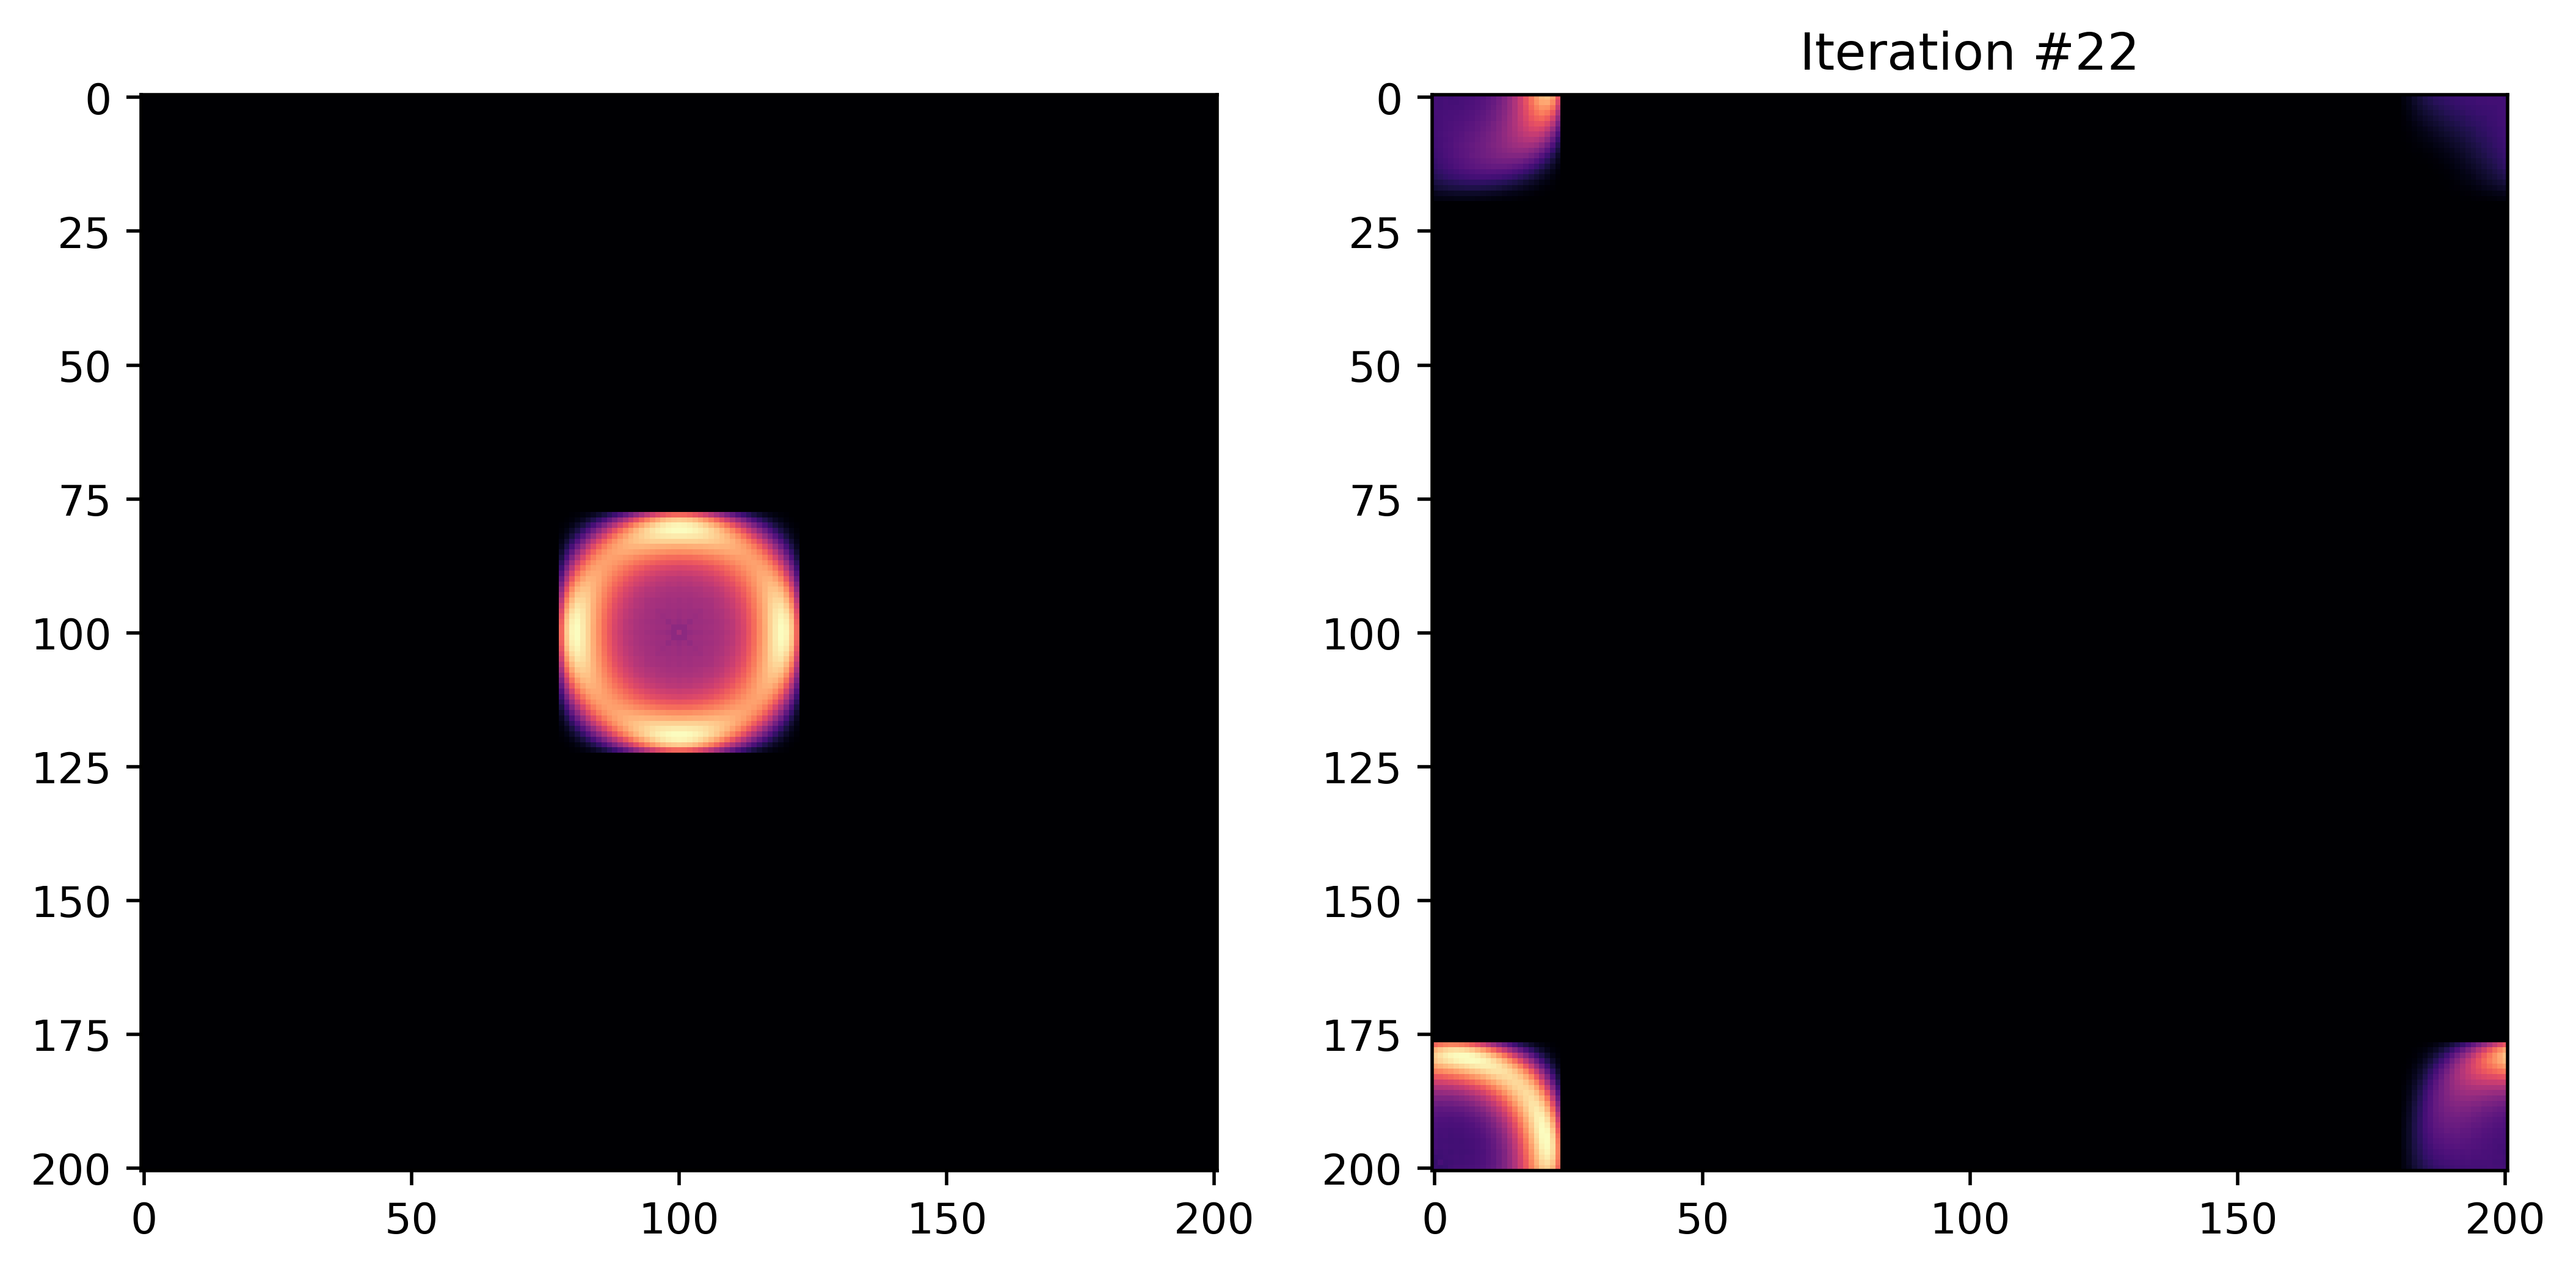

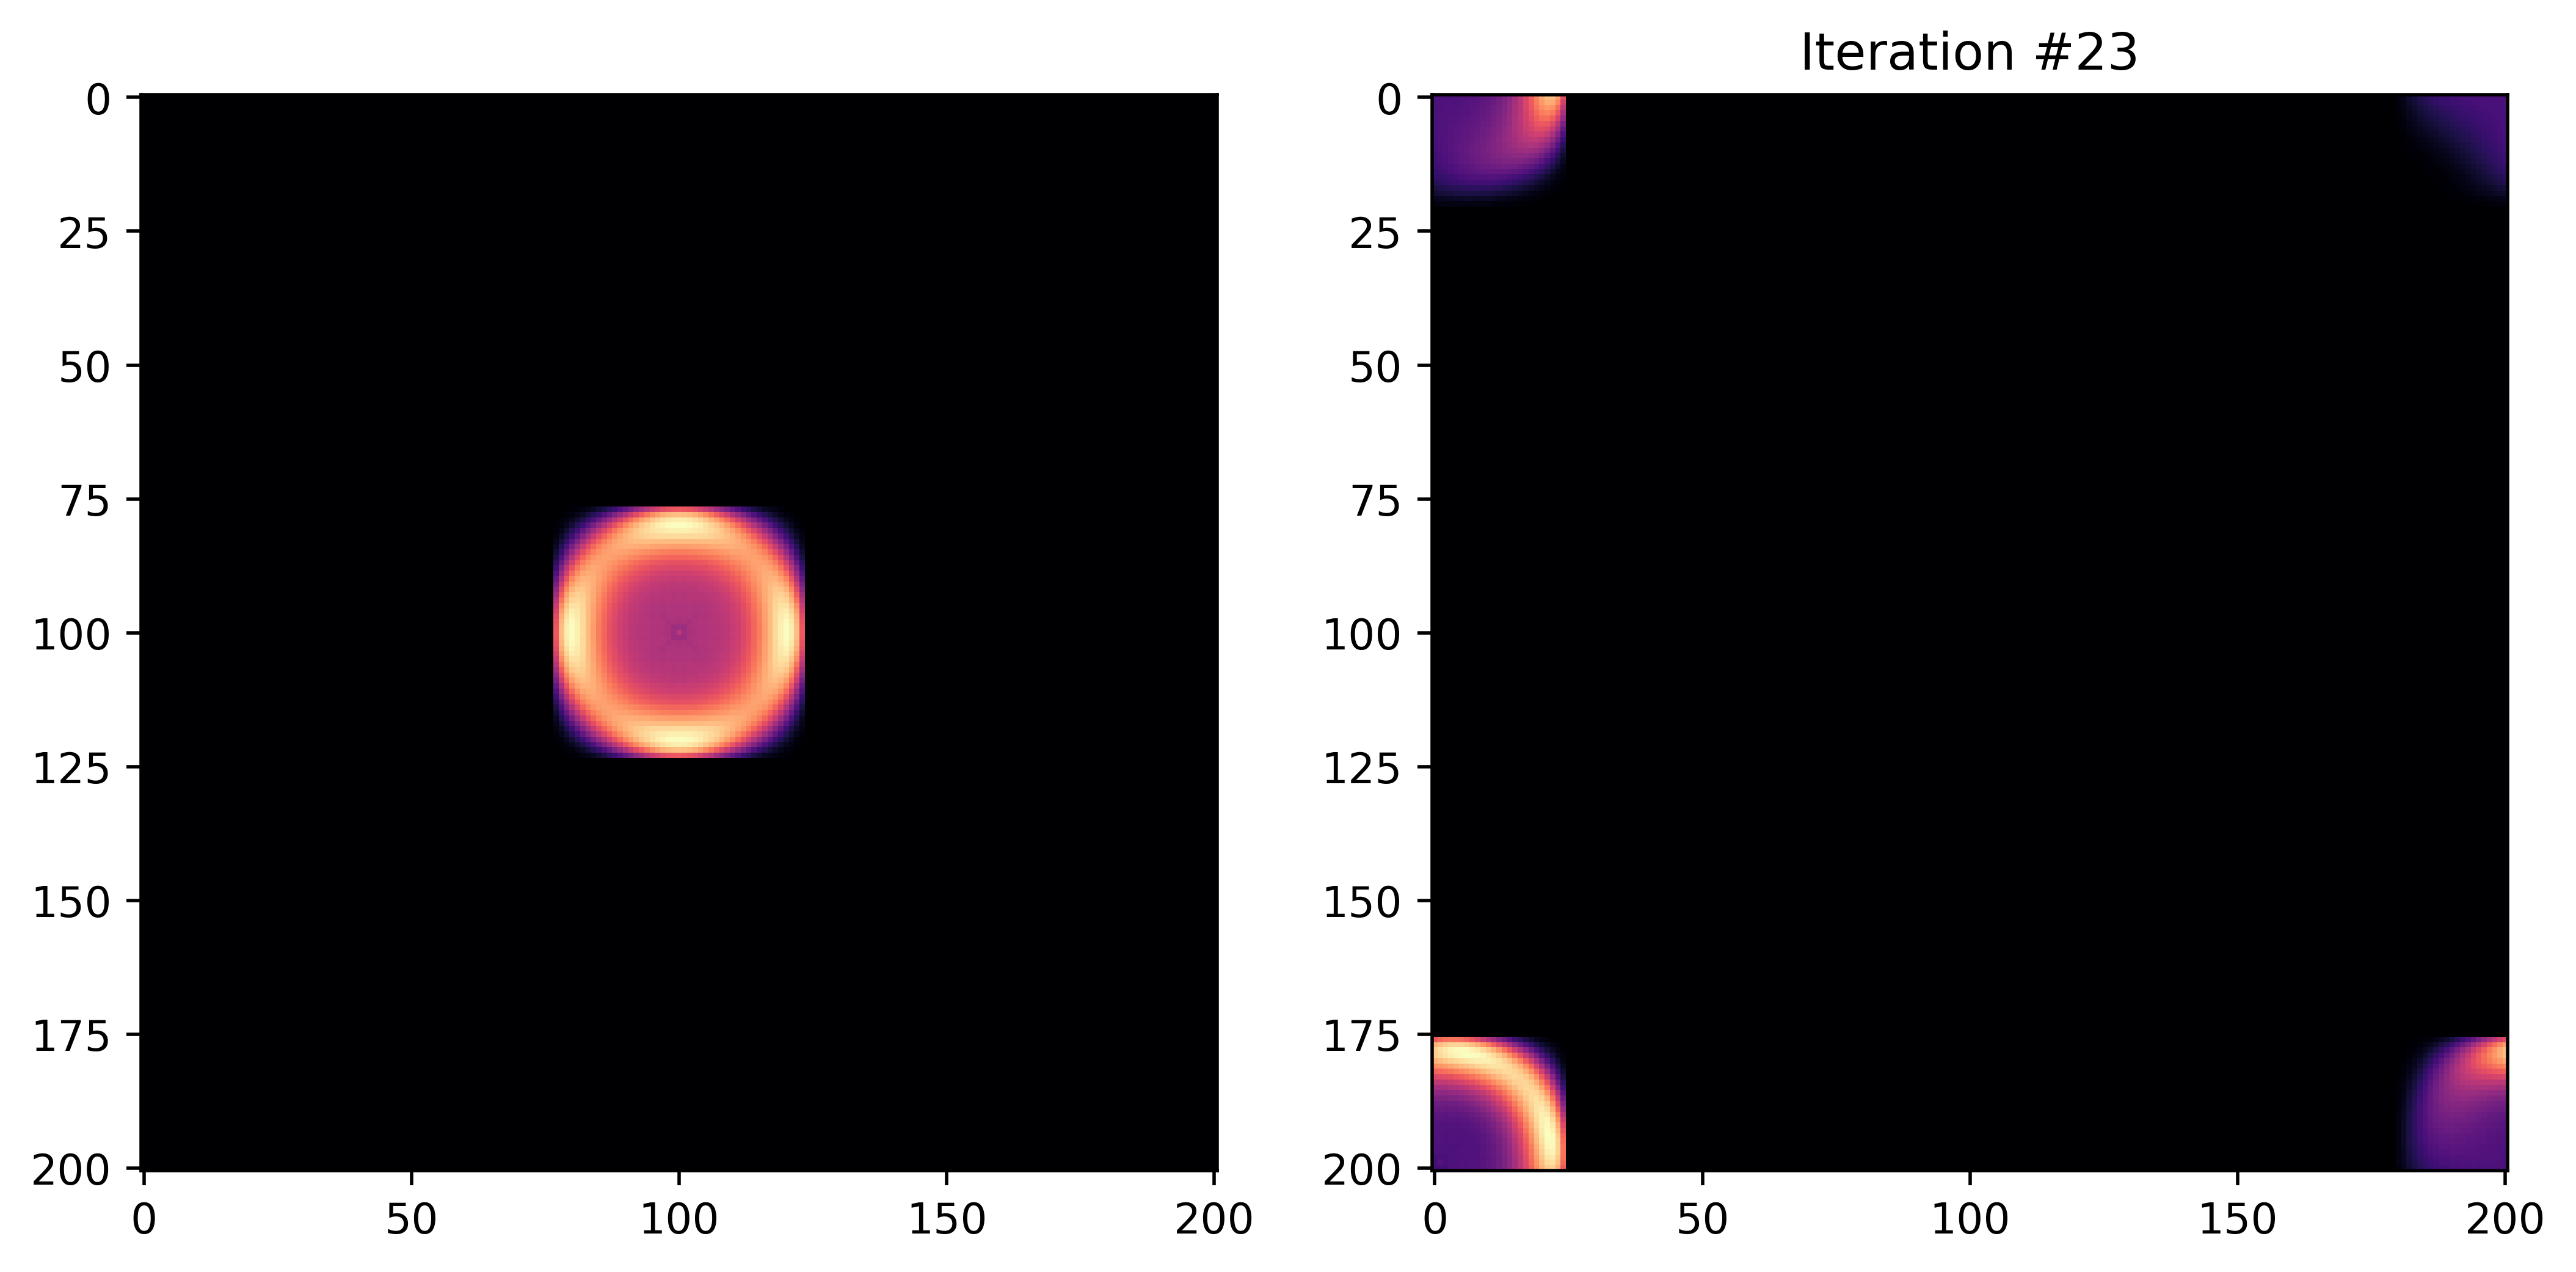

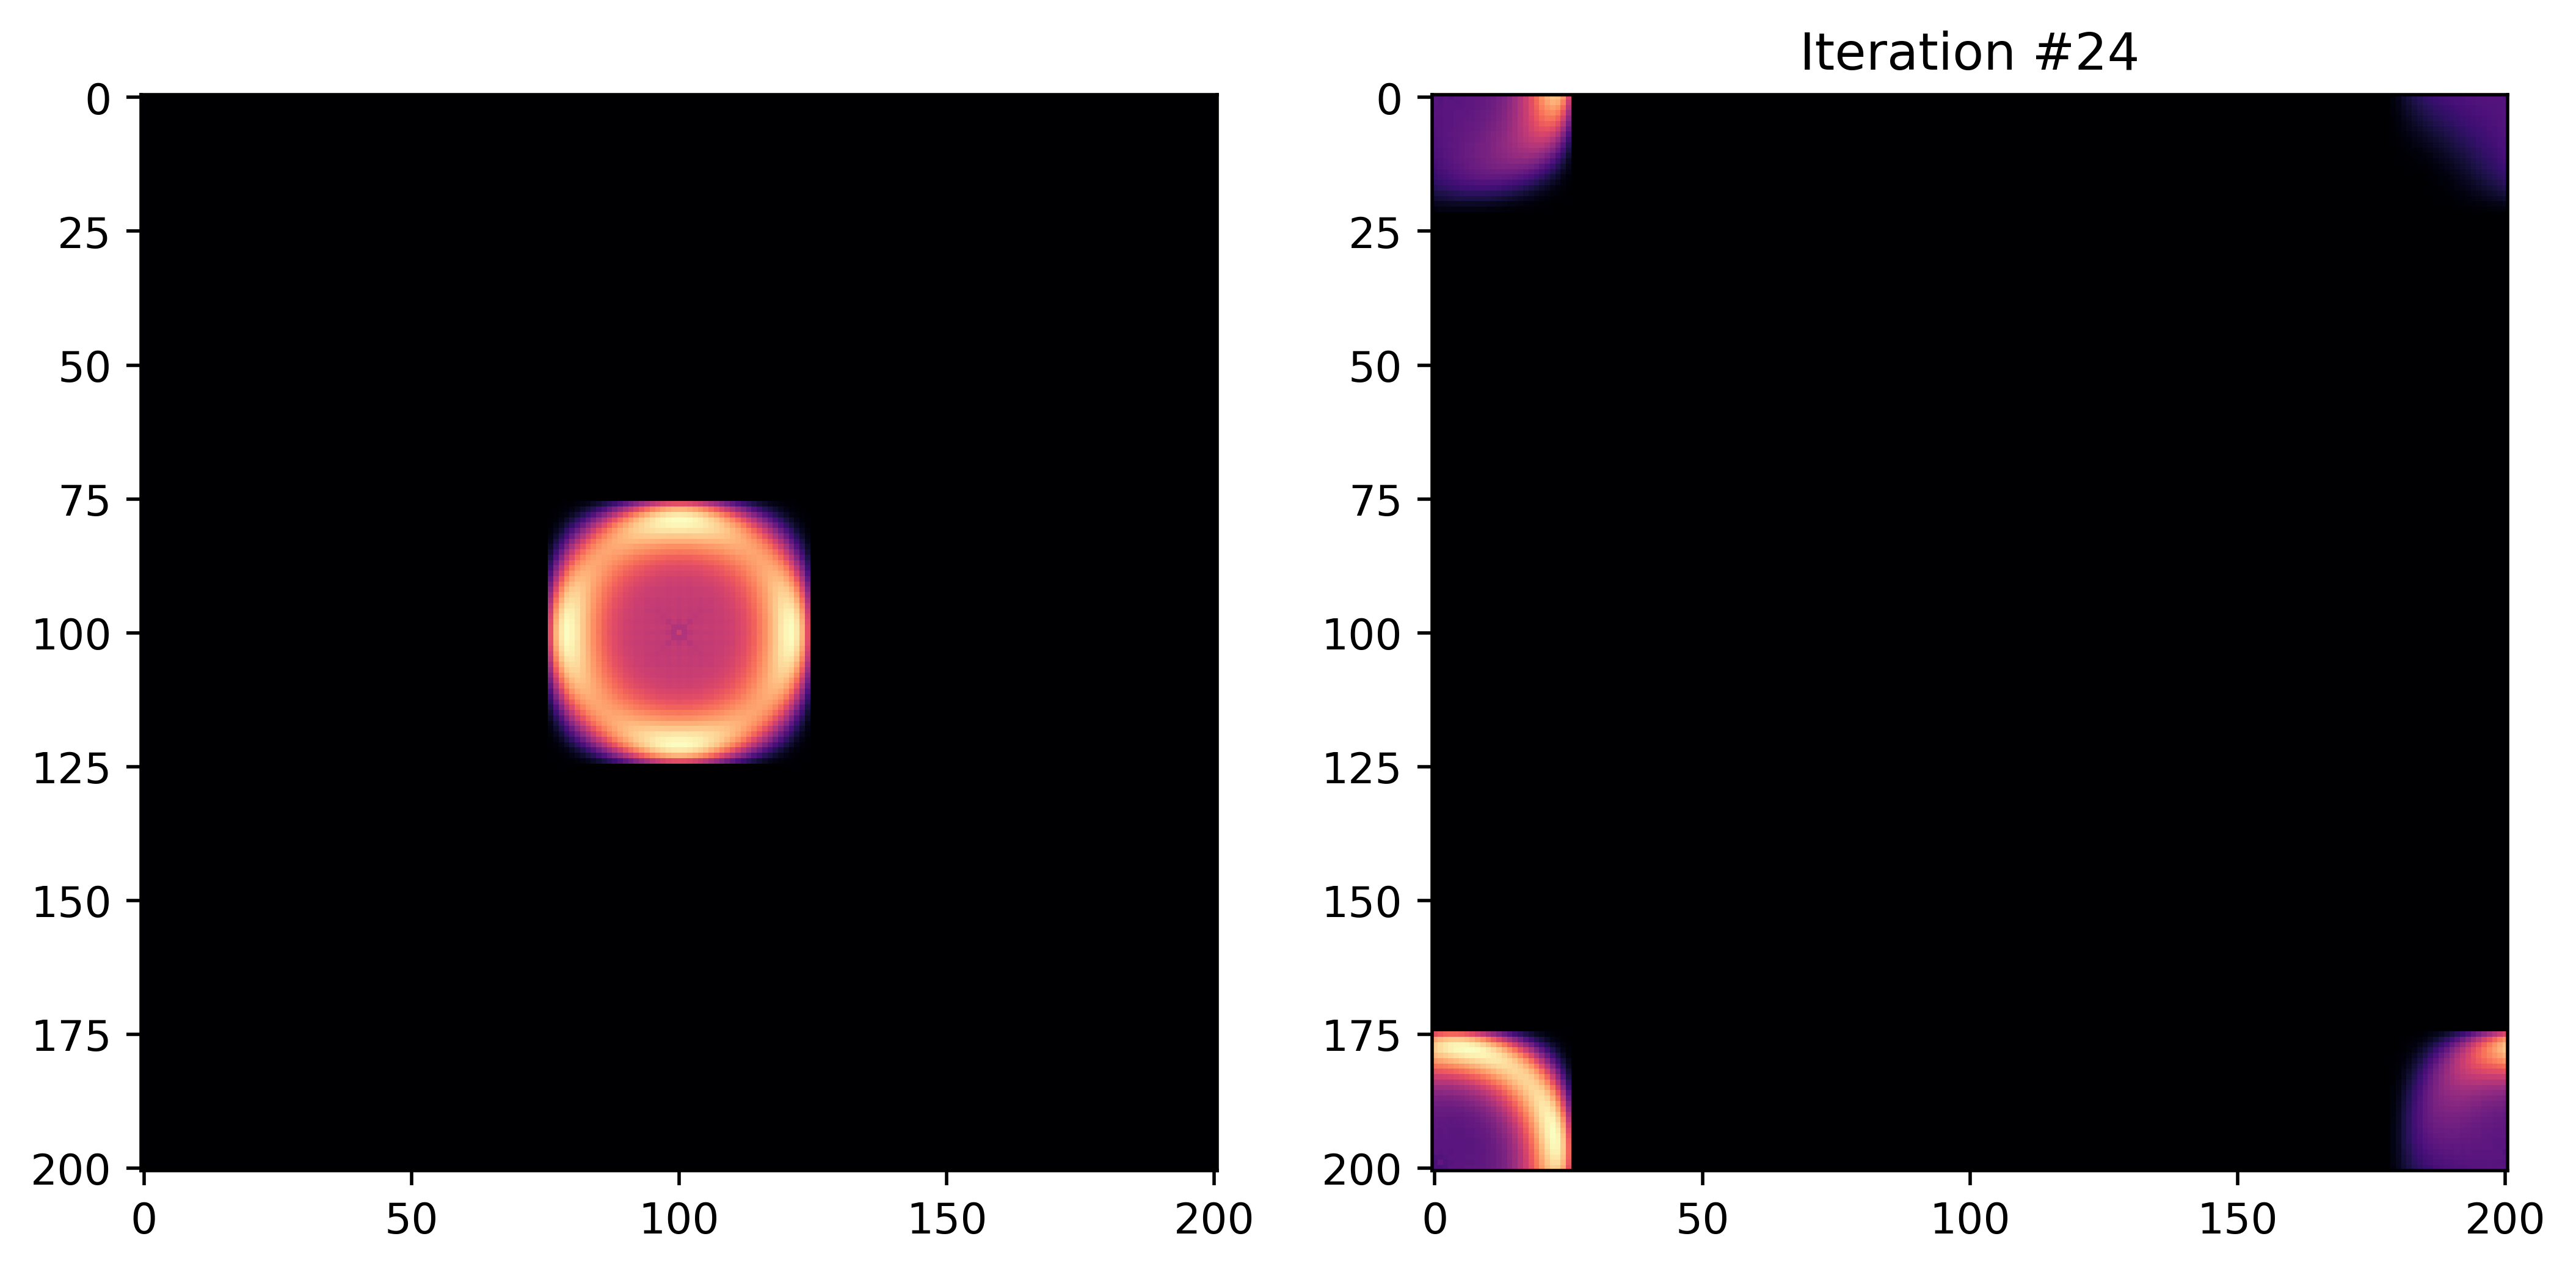

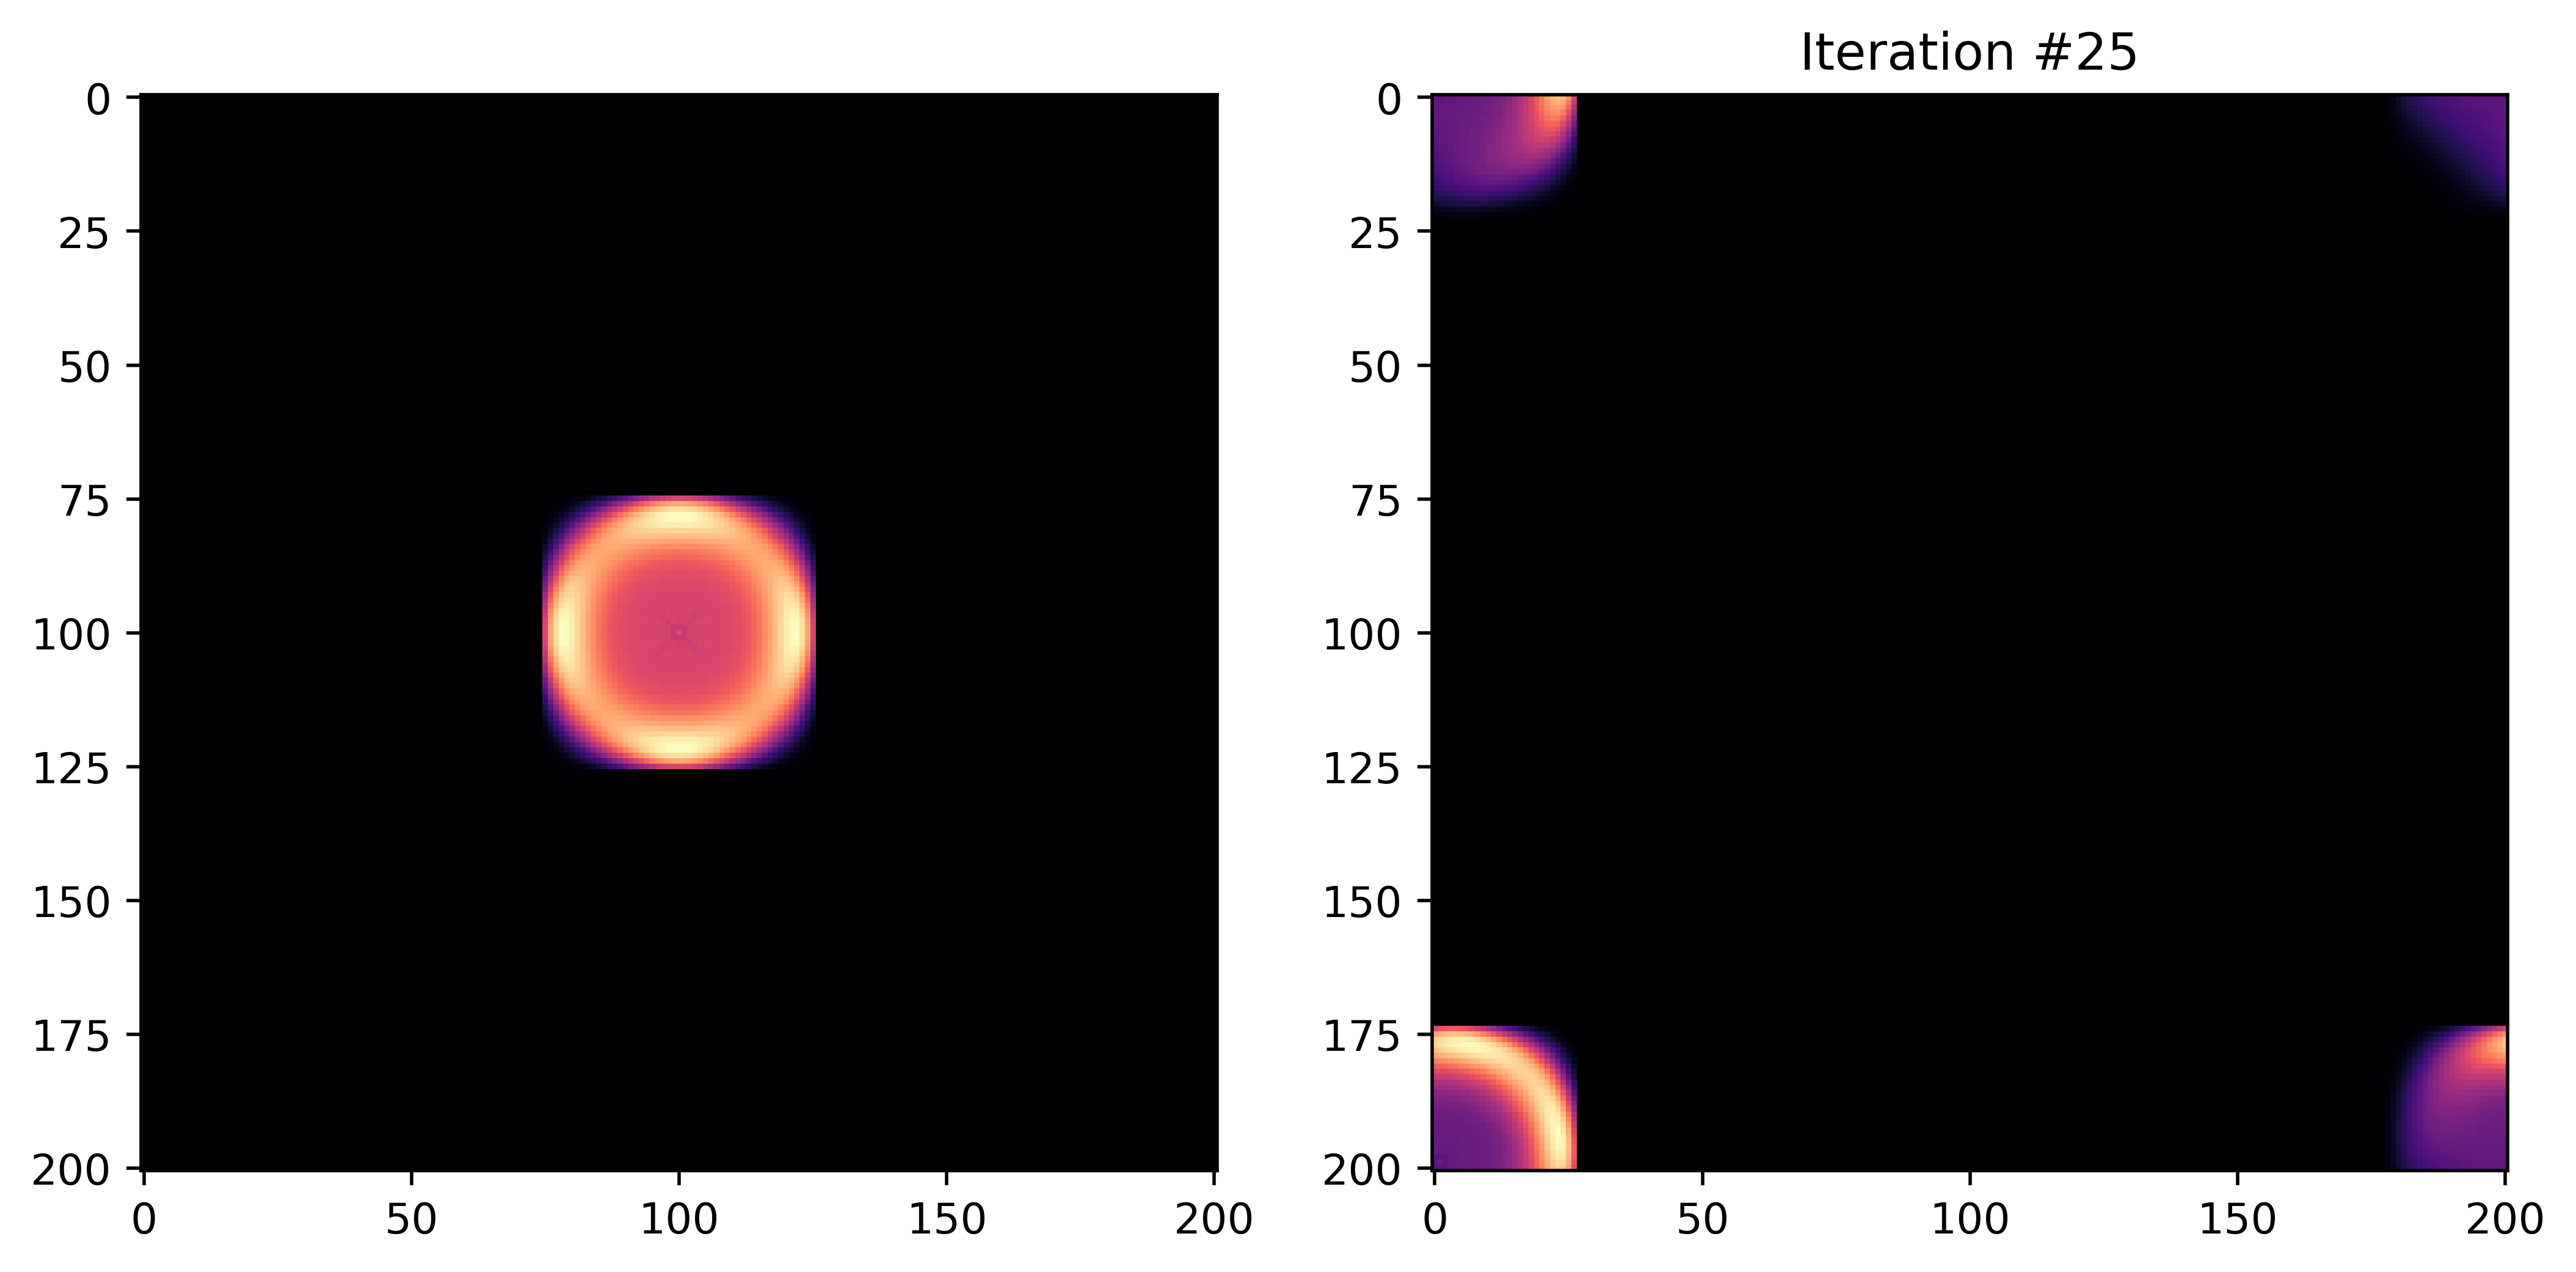

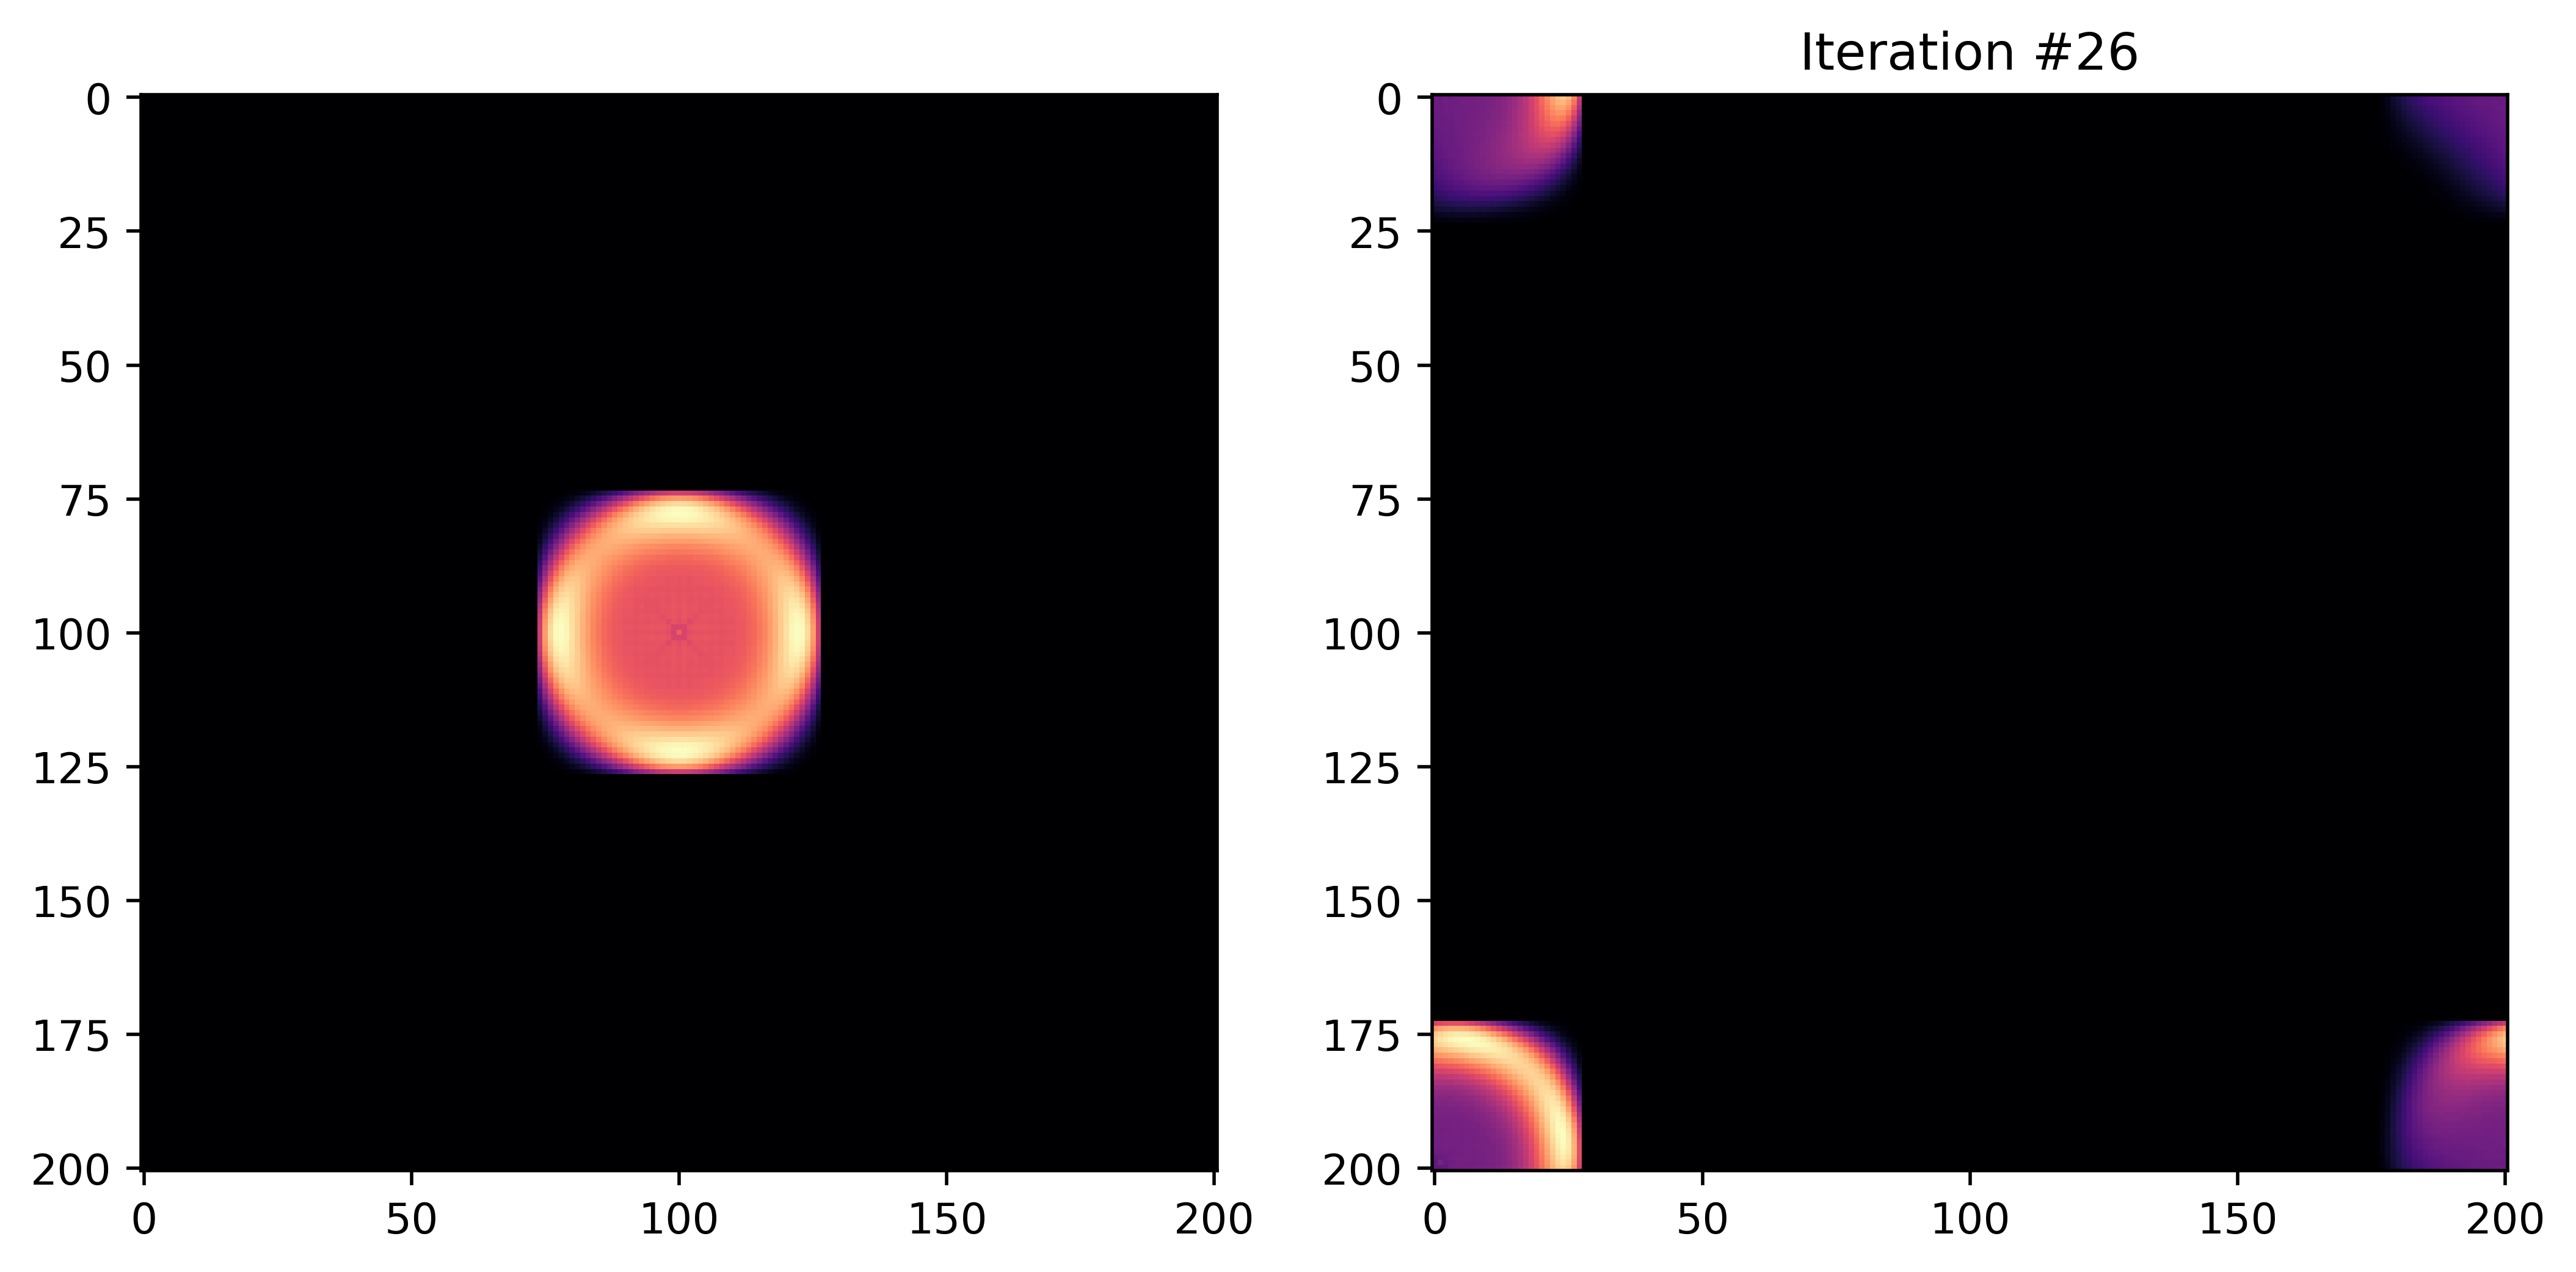

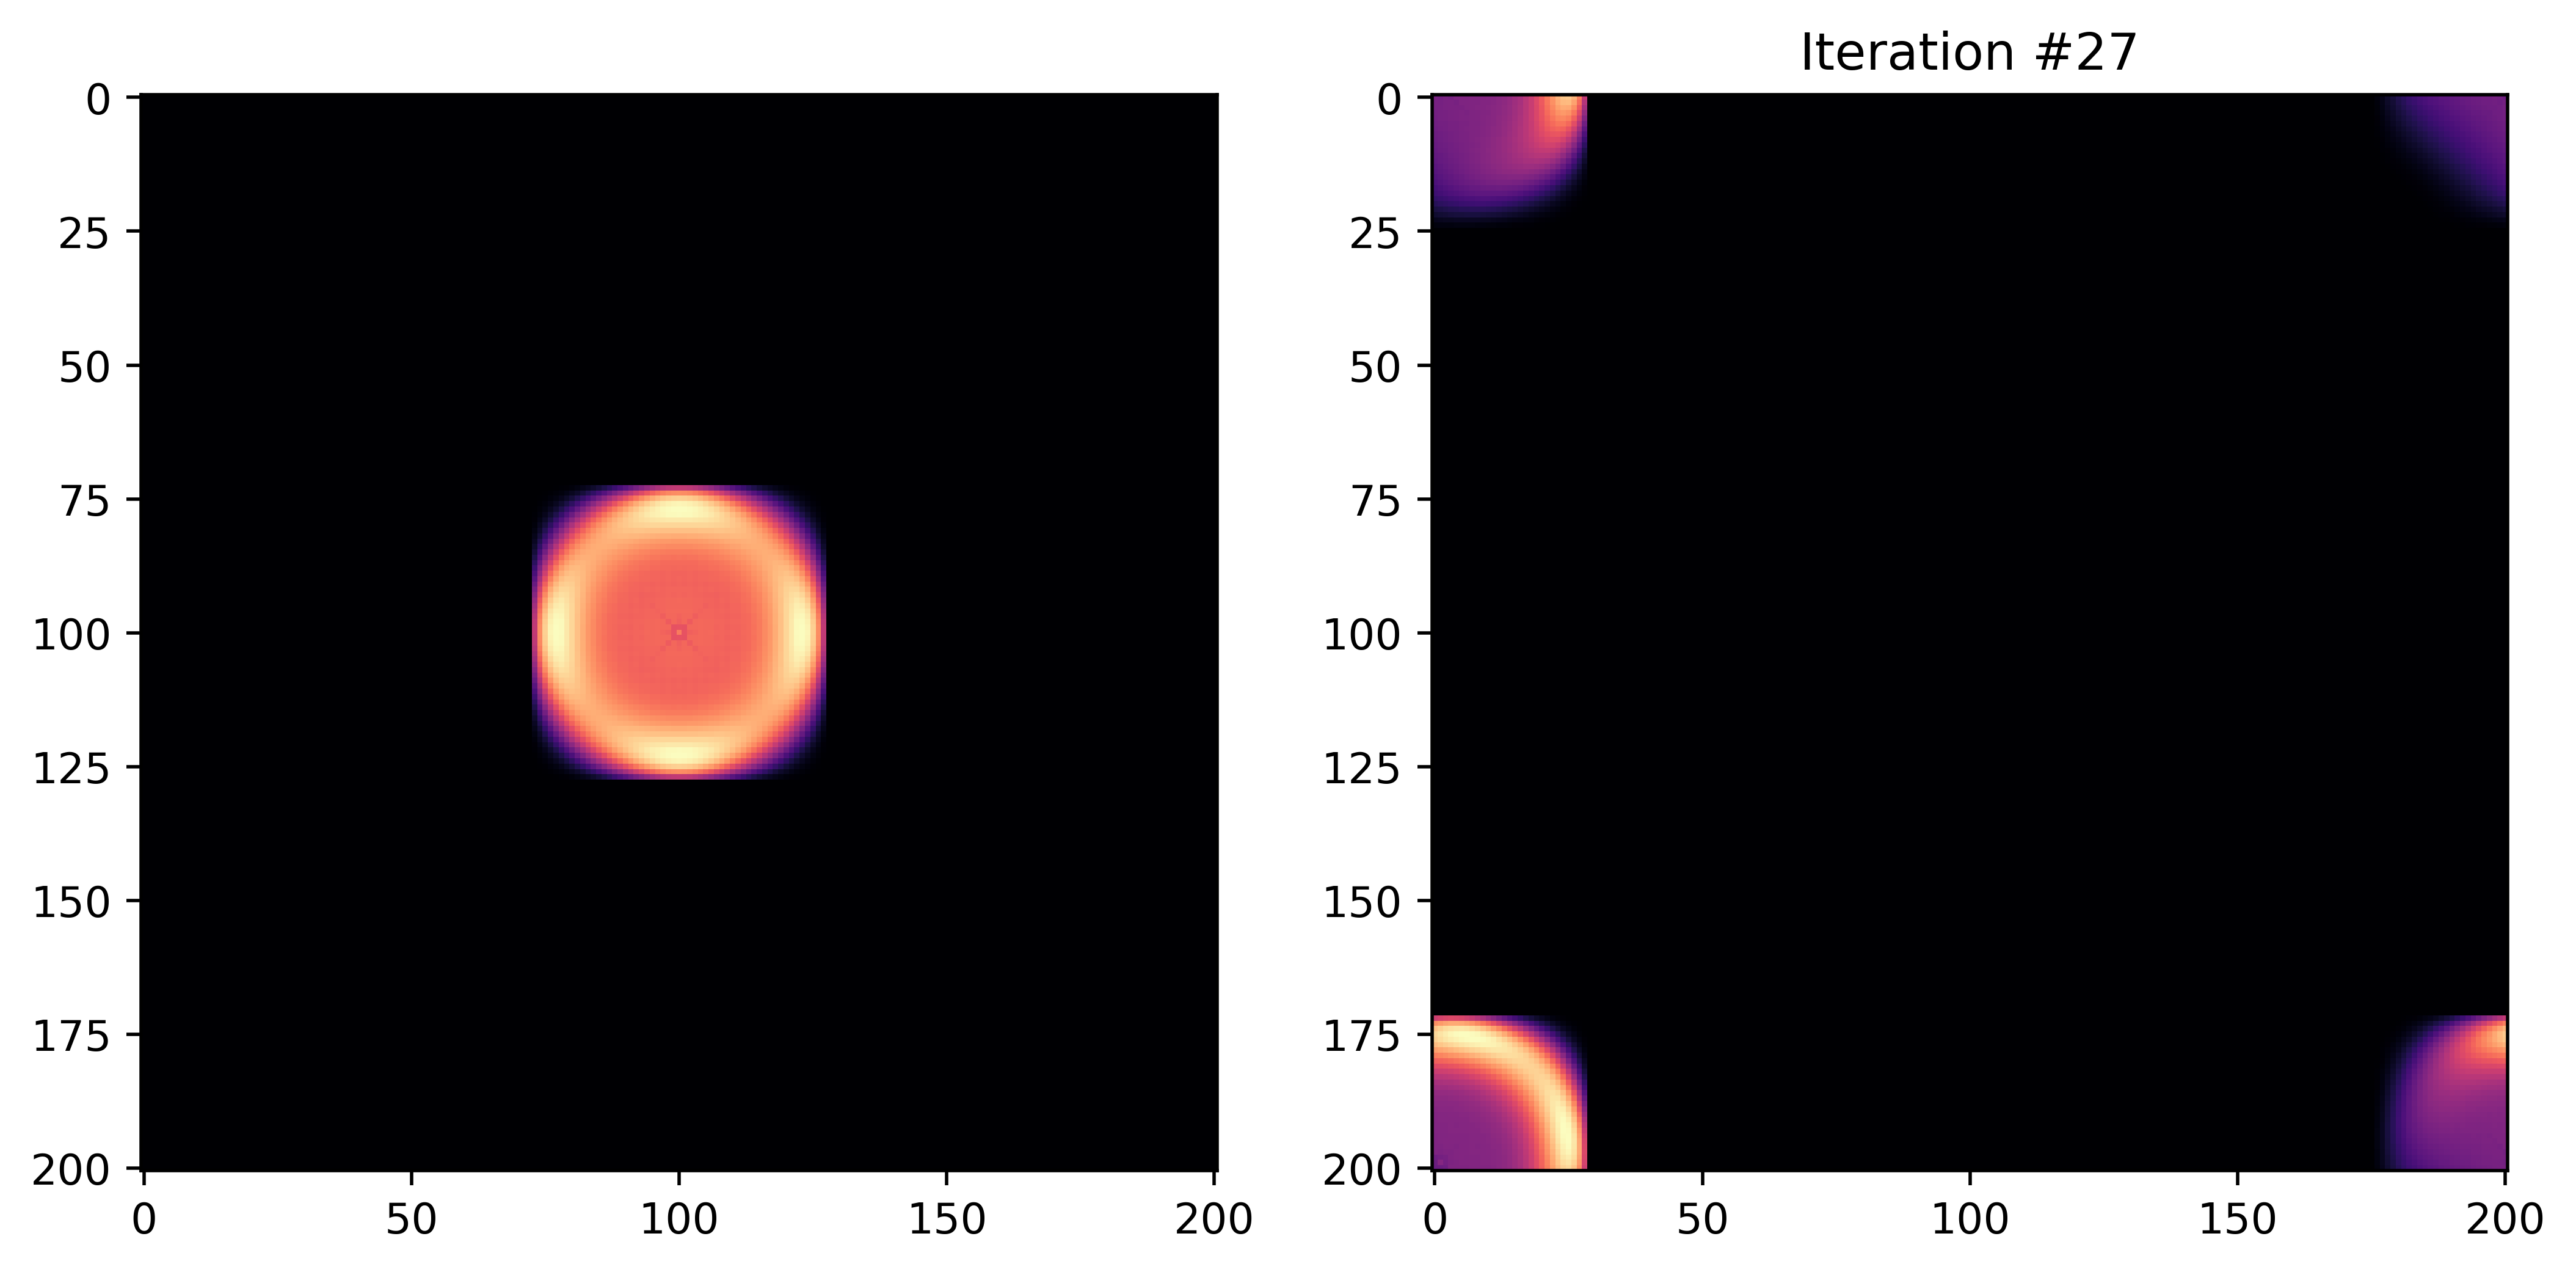

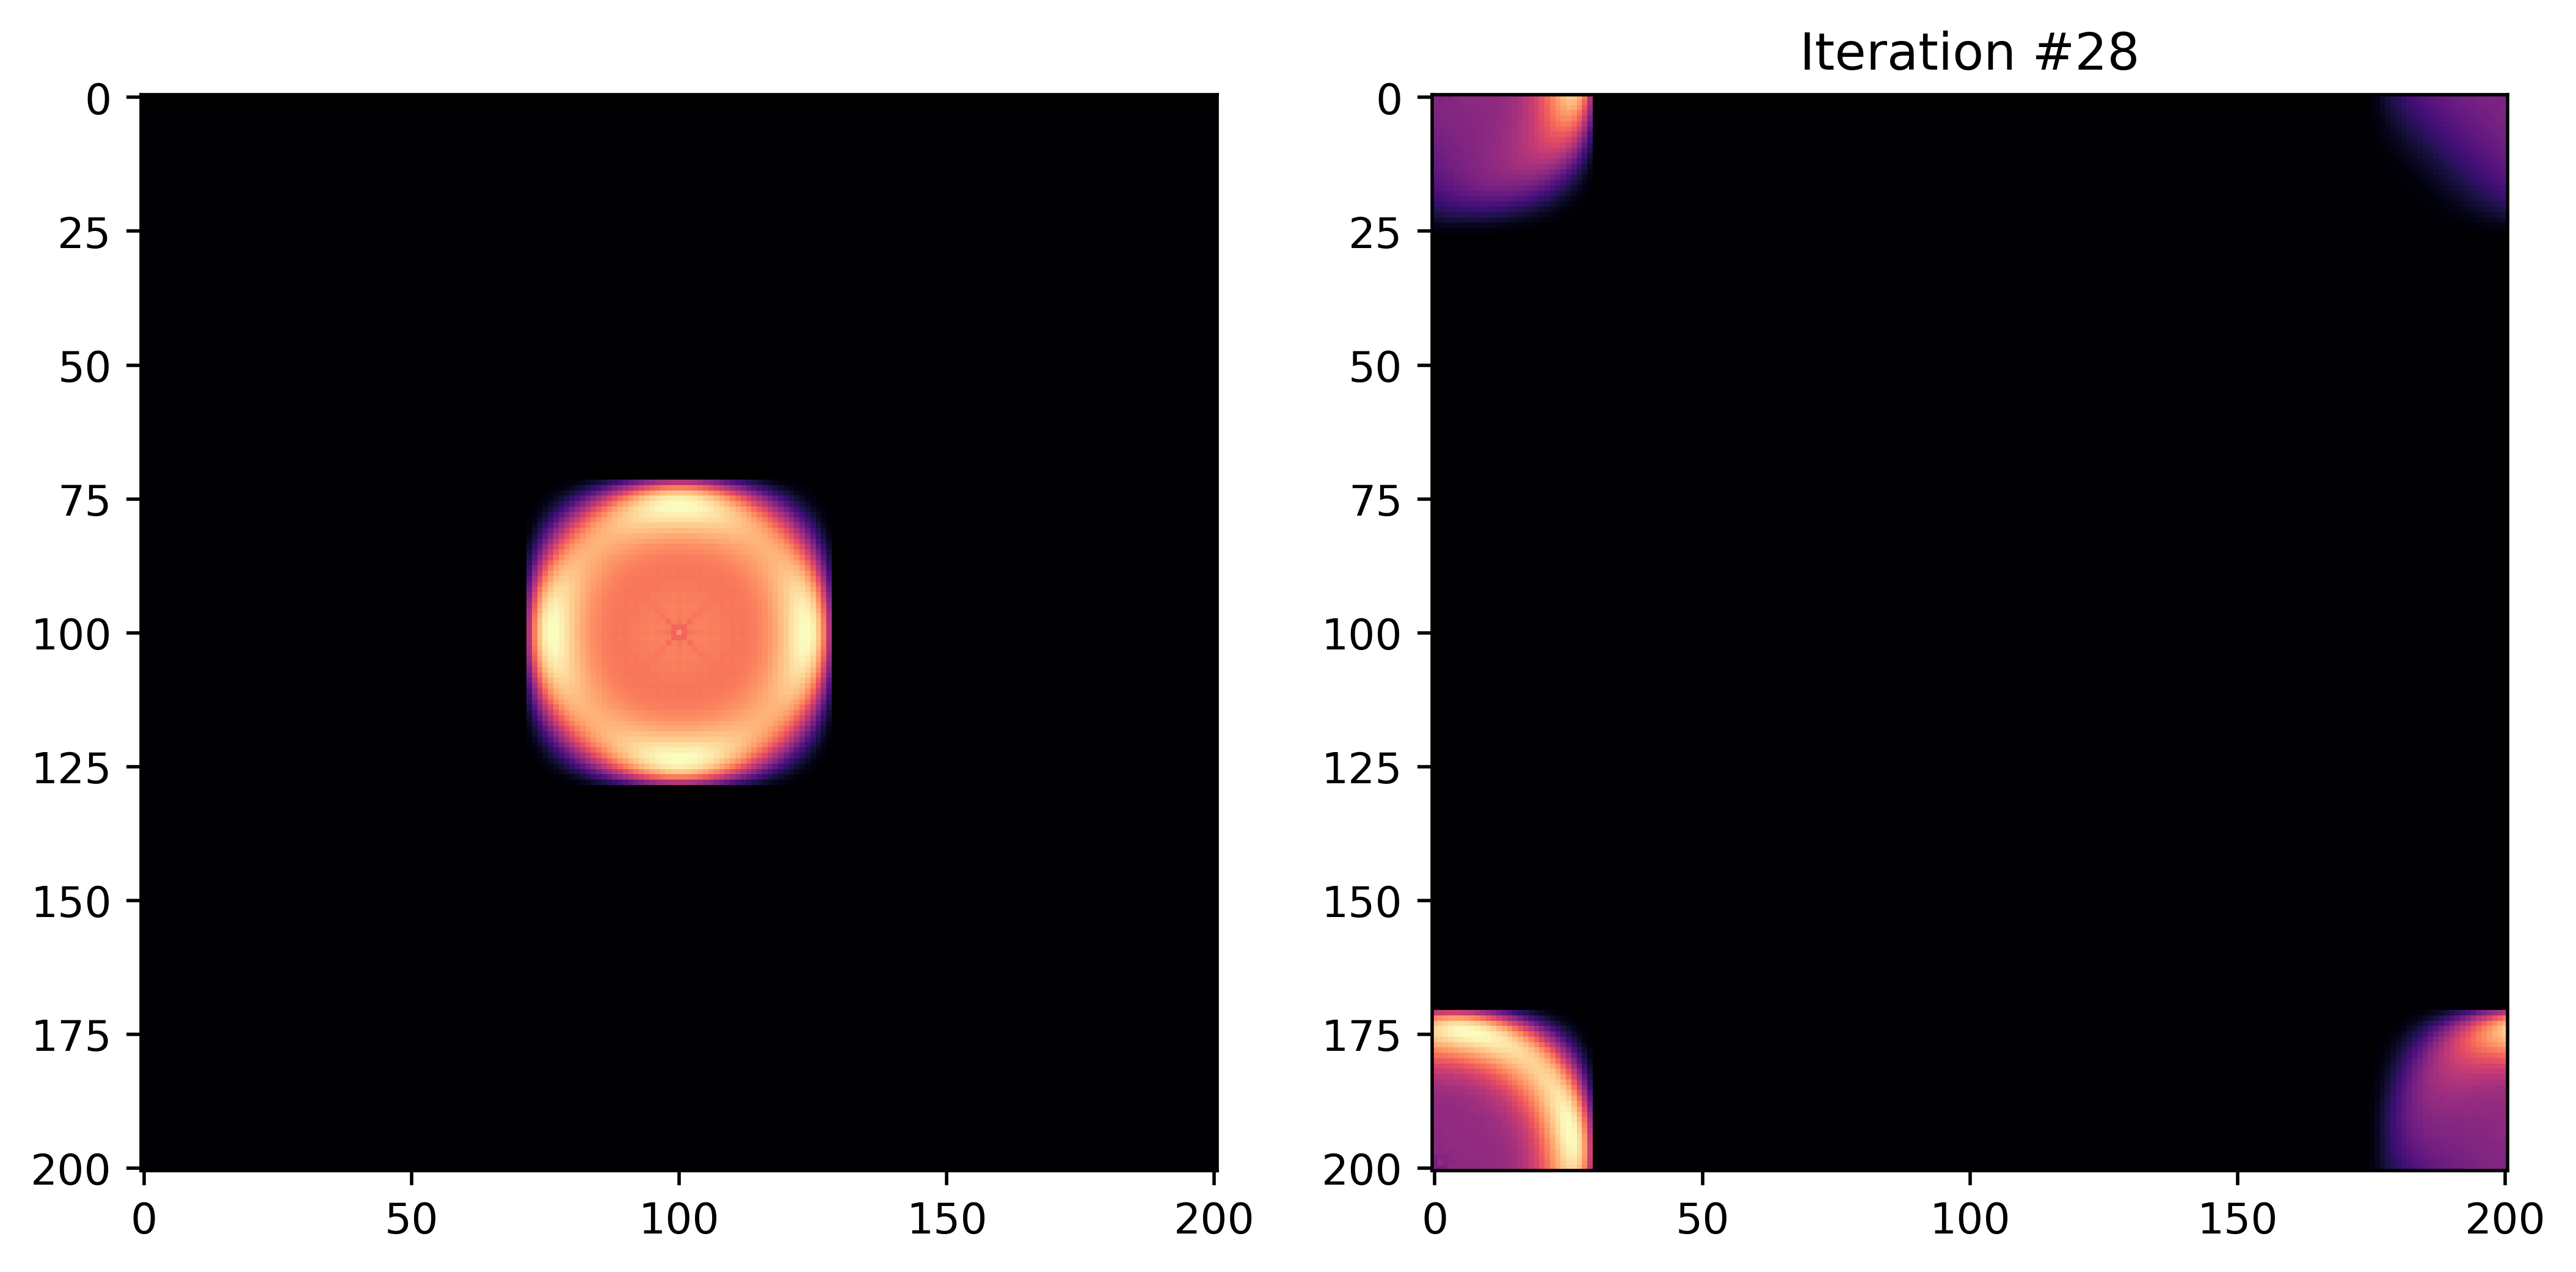

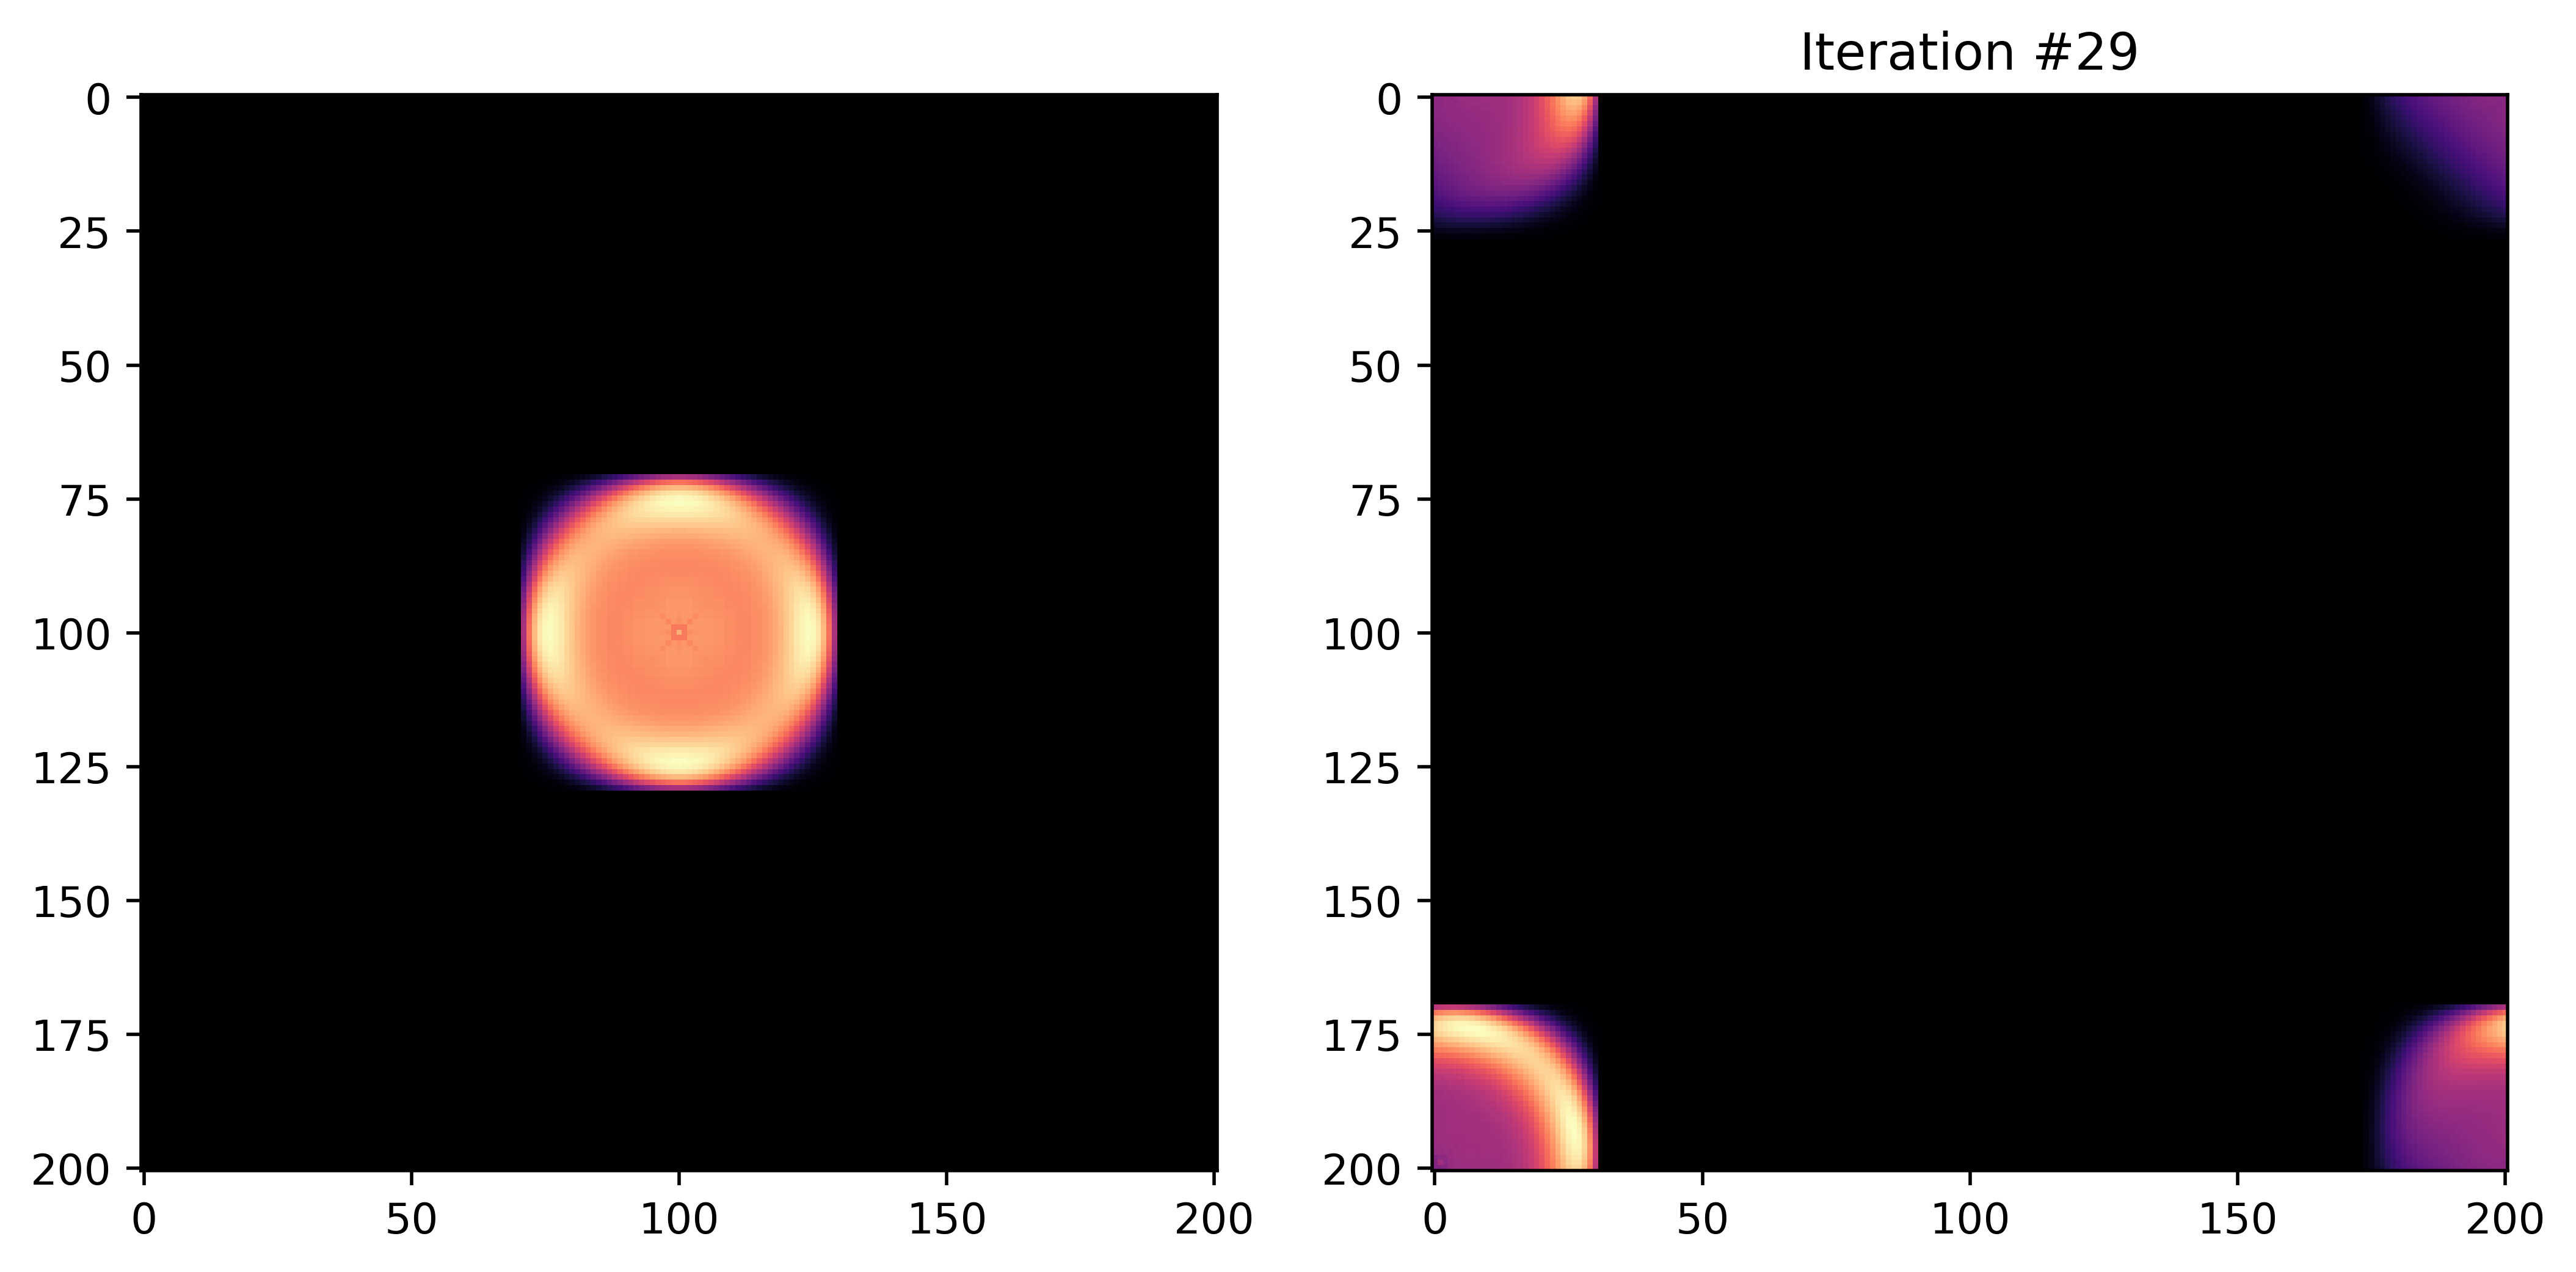

In [52]:
n_it = 30

x_is_list = []
x_beam_list = []

# Isotropic source setup
src_pos_is = (NY//2,NX//2)
src_val_is = [1] * NL

x0_is = np.zeros((NY, NX, NL))
x0_is[src_pos_is] = src_val_is

# Radiation beam setup
src_pos_beam = (NY-2,1)
src_val_beam = [0] * NL
if NL >= 8:
    src_val_beam[7] = 1
if NL >= 16:
    src_val_beam[14] = 1
    src_val_beam[15] = 1

x0_beam = np.zeros((NY, NX, NL))
x0_beam[src_pos_beam] = src_val_beam

x_is_list.append(x0_is)
x_beam_list.append(x0_beam)

alpha = 0.33

# Simulate
for it in range(n_it):
    if it >= 1:
        # Isotropic source
        x_is = np.copy(x_is_list[-1])
        x_is[src_pos_is] = src_val_is
        x_is = stream(x_is, redist_coeff=alpha, adjust_velocity=False)
        # x_is += x_is_list[-1]
        x_is_list.append(x_is)
    
        # Radiation beam
        x_beam = np.copy(x_beam_list[-1])
        x_beam[src_pos_beam] = src_val_beam
        x_beam = stream(x_beam, redist_coeff=alpha, adjust_velocity=False)
        # x_beam += x_beam_list[-1]
        x_beam_list.append(x_beam)

    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=500)
    ax[0].imshow(np.sum(x_is_list[-1], axis=2), cmap="magma")
    ax[1].imshow(np.sum(x_beam_list[-1], axis=2), cmap="magma")
    plt.title(f"Iteration #{it}")
    plt.show()